In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 압축된 파일 업로드
from google.colab import files
uploaded = files.upload()  # GSE77962_series_matrix.txt.gz 선택

# 압축 해제
import gzip
import shutil

with gzip.open("GSE77962_series_matrix.txt.gz", 'rb') as f_in:
    with open("GSE77962_series_matrix.txt", 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [ ]:
import pandas as pd
df = pd.read_csv("GSE77962_series_matrix.txt", sep="\t", comment='!')
print(df)

In [ ]:
import pickle

# 예: expression DataFrame 저장
with open('/content/drive/MyDrive/GeneExpression33297_Subject53x3.pkl', 'wb') as f:
    pickle.dump(df, f)

In [ ]:
import pickle

with open('/content/drive/MyDrive/GeneExpression33297_Subject53x3.pkl', 'rb') as f:
    expression = pickle.load(f)

In [ ]:
platform_path = "/content/drive/MyDrive/GPL11532-32230.txt"

with open(platform_path, 'r') as f:
    for i in range(40):
        line = f.readline()
        print(f"{i}: {line.strip()}")

In [ ]:
expression

In [ ]:
expression.to_csv("expression.csv", index=False)

In [ ]:
import pandas as pd

# 예시: 다운로드한 플랫폼 파일 경로
platform_path = "/content/drive/MyDrive/GPL11532-32230.txt"

# 플랫폼 파일은 보통 앞에 설명 줄이 있으므로 skiprows 사용
platform = pd.read_csv(platform_path, sep="\t", skiprows=12, low_memory=False)

In [ ]:
# 구조 확인
print(platform.columns)
print(platform)

In [ ]:
platform.head()

In [ ]:
import pickle

# 예: expression DataFrame 저장
with open('/content/drive/MyDrive/includingGeneName.pkl', 'wb') as f:
    pickle.dump(platform, f)

In [ ]:
with open('/content/drive/MyDrive/includingGeneName.pkl', 'rb') as f:
    platform = pickle.load(f)

In [ ]:
platform

In [ ]:
platform.to_csv("platform.csv", index=False)

In [ ]:
platform

# 실험자의 메타데이터 크롤링
키, 몸무게 등


In [ ]:
!pip install GEOparse

In [ ]:
import GEOparse
import pandas as pd

gse = GEOparse.get_GEO("GSE77962", destdir="./")

metadata = []

for gsm_id, gsm in gse.gsms.items():
    sample_info = {"gsm_id": gsm_id}

    for line in gsm.metadata.get("characteristics_ch1", []):
        if ":" in line:
            key, value = line.split(":", 1)
            key = key.strip().lower().replace(" ", "_").replace("(", "").replace(")", "")
            value = value.strip()
            sample_info[key] = value

    metadata.append(sample_info)

metadata= pd.DataFrame(metadata)

In [ ]:
metadata

In [ ]:
metadata.shape

In [ ]:
metadata.columns

In [ ]:
# CSV로 저장
metadata.to_csv("metadata.csv", index=False)

# 또는 Pickle로 저장
metadata.to_pickle("metadata.pkl")

In [ ]:
import pandas as pd

# 파일 불러오기
metadata_df = pd.read_csv("metadata.csv")

# Expression, Platform, Metadata<- SQL로 연결하기

### expression, platform, metadata CSV 한번에 다운로드

In [ ]:
import pandas as pd

# CSV 파일 읽기
expression = pd.read_csv("/content/drive/MyDrive/expression.csv")
platform = pd.read_csv("/content/drive/MyDrive/platform.csv")
metadata = pd.read_csv("/content/drive/MyDrive/metadata_purefat.csv")

In [ ]:
expression.head()

In [ ]:
expression.shape

In [ ]:
expression["ID_REF"].duplicated().sum()

In [ ]:
platform.head()

In [ ]:
platform.shape

In [ ]:
platform.columns

In [ ]:
metadata.head()

In [ ]:
metadata.columns

In [ ]:
metadata.shape

In [ ]:
# 수치형으로 변환 (문자열인 경우 처리)
metadata["weight_kg"] = pd.to_numeric(metadata["weight_kg"], errors="coerce")
metadata["body_fat_%"] = pd.to_numeric(metadata["body_fat_%"], errors="coerce")

# 체지방량 (kg) 열 추가
metadata["pure_fat_kg"] = metadata["weight_kg"] * (metadata["body_fat_%"] / 100)

In [ ]:
metadata.shape

In [ ]:
metadata.to_csv("/content/drive/MyDrive/metadata_purefat.csv", index=False)

In [ ]:
db_path = "/content/drive/MyDrive/obesitygene_project.db"

In [ ]:
import sqlite3
import pandas as pd

# ✅ 저장할 SQLite 파일명 설정 (예: 'bio_project.db')
db_path = "/content/drive/MyDrive/obesitygene_project.db"
conn = sqlite3.connect(db_path)

# ✅ SQLite DB에 테이블로 저장
expression.to_sql("expression_change", conn, index=False, if_exists="replace")
metadata.to_sql("metadata", conn, index=False, if_exists="replace")
platform.to_sql("weight_bmi_changes", conn, index=False, if_exists="replace")
conn.close()

In [ ]:
import pandas as pd

# 테이블 목록 보기
table_list = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(table_list)

# 특정 테이블 구조 보기 (예: expression)
schema = pd.read_sql("PRAGMA table_info(weight_bmi_changes);", conn)
print(schema)

### expression데이터프레임 행/열 변환

In [ ]:
expression_long = expression.melt(
    id_vars="ID_REF",
    var_name="gsm_id",       # GSM ID를 열 이름에서 값으로 녹임
    value_name="expression"  # 발현량
)

In [ ]:
# 1. expression_long에 metadata 조인 (time_point, subject_id 추가)
expr_meta = expression_long.merge(
    metadata[['gsm_id', 'subject_id', 'time_point']],
    on='gsm_id',
    how='left'
)

# 2. 피벗: subject_id, ID_REF별로 time_point를 열로 만들기
expr_pivot = expr_meta.pivot_table(
    index=['subject_id', 'ID_REF'],
    columns='time_point',
    values='expression'
).reset_index()

# 열 이름 정리
expr_pivot.columns.name = None
expr_pivot = expr_pivot.rename(columns={
    'after weight stable period': 'C',
    'after weight loss period': 'B',
    'at study start': 'A'
})

# 3. 시간대 간 expression 변화량 계산
expr_pivot['exp_C_A'] = expr_pivot['C'] - expr_pivot['A']
expr_pivot['exp_C_B'] = expr_pivot['C'] - expr_pivot['B']
expr_pivot['exp_B_A'] = expr_pivot['B'] - expr_pivot['A']

In [ ]:
# 4. 결과 보기
expression_change = expr_pivot[['subject_id', 'ID_REF', 'exp_C_A', 'exp_C_B', 'exp_B_A']]

In [ ]:
expression_change.columns

In [ ]:
conn = sqlite3.connect(db_path)

conn.executescript('''
DROP TABLE IF EXISTS expression_change;

CREATE TABLE expression_change (
    ID_REF TEXT,
    subject_id TEXT,
    exp_C_A REAL,
    exp_C_B REAL,
    exp_B_A REAL,
    PRIMARY KEY (ID_REF, subject_id),
    FOREIGN KEY (ID_REF) REFERENCES platform(ID),
    FOREIGN KEY (subject_id) REFERENCES metadata(subject_id)
);
''')
expression_change.to_sql(
    name="expression_change",
    con=conn,
    if_exists="append",  # 구조를 바꾸지 않고 데이터만 삽입
    index=False
)

conn.close()

In [ ]:
import sqlite3

conn = sqlite3.connect(db_path)

expression_long.to_sql(
    name="expression_long",
    con=conn,
    index=False,
    if_exists="replace"
)

conn.close()

In [ ]:
conn = sqlite3.connect(db_path)

conn.executescript('''
 -- 1. 기존 테이블 이름 변경
ALTER TABLE expression_long RENAME TO expression_long_old;

-- 2. 새로운 테이블 생성 (PK 포함)
CREATE TABLE expression_long (
    ID_REF TEXT,
    gsm_id TEXT,
    expression REAL,
    PRIMARY KEY (ID_REF, gsm_id)
);

-- 3. 기존 데이터 복사
INSERT INTO expression_long (ID_REF, gsm_id, expression)
SELECT ID_REF, gsm_id, expression FROM expression_long_old;

-- 4. 임시 테이블 제거
DROP TABLE expression_long_old;
''')

conn.close()

### 데이터베이스 정리하기

In [ ]:
import sqlite3
db_path = "/content/drive/MyDrive/obesitygene_project.db"
conn = sqlite3.connect(db_path)

conn.executescript('''
DROP TABLE IF EXISTS expression;
DROP TABLE IF EXISTS platform;
DROP TABLE IF EXISTS metadata;

CREATE TABLE platform (
    ID TEXT PRIMARY KEY,
    GB_LIST TEXT,
    SPOT_ID TEXT,
    seqname TEXT,
    RANGE_GB TEXT,
    RANGE_STRAND TEXT,
    RANGE_START INTEGER,
    RANGE_STOP INTEGER,
    total_probes INTEGER,
    gene_assignment TEXT,
    mrna_assignment TEXT,
    category TEXT,
    gene_symbol TEXT
);

CREATE TABLE metadata (
    gsm_id TEXT PRIMARY KEY,
    subject_id TEXT,
    tissue TEXT,
    treatment TEXT,
    time_point TEXT,
    sex TEXT,
    age_yrs REAL,
    height_cm REAL,
    weight_kg REAL,
    bmi_kg_m2 REAL,
    body_fat_pct REAL,
    pure_fat_kg REAL
);

 DROP TABLE IF EXISTS weight_bmi_changes;

CREATE TABLE weight_bmi_changes (
    subject_id TEXT PRIMARY KEY,

    weight_kg_C_A REAL,
    weight_kg_C_B REAL,
    weight_kg_B_A REAL,

    bmi_C_A REAL,
    bmi_C_B REAL,
    bmi_B_A REAL,

    fat_C_A REAL,
    fat_C_B REAL,
    fat_B_A REAL,

    pure_fat_C_A REAL,
    pure_fat_C_B REAL,
    pure_fat_B_A REAL,

    FOREIGN KEY(subject_id) REFERENCES metadata(subject_id)
);
''')

# platform 데이터 삽입
platform.to_sql("platform", conn, if_exists="append", index=False)

# metadata 데이터 삽입
metadata = metadata.rename(columns={
    "bmi_kg/m2": "bmi_kg_m2",  # SQL 테이블 정의에 맞게
    "body_fat_%": "body_fat_pct"
})
metadata.to_sql("metadata", conn, if_exists="append", index=False)

conn.close()

# 체중, BMI, 체지방률 변화량 구하기

In [ ]:
metadata.columns

In [ ]:
# 필요한 열만 선택
df = metadata[['subject_id', 'time_point', 'weight_kg', 'bmi_kg_m2', 'body_fat_pct', 'pure_fat_kg']]

# time_point 기준으로 pivot
pivoted = df.pivot(index='subject_id', columns='time_point')

# 열 이름 정리
pivoted.columns = ['_'.join(col).strip().replace(' ', '_') for col in pivoted.columns.values]
pivoted = pivoted.reset_index()

In [ ]:
pivoted.columns

In [ ]:
pivoted.shape

In [ ]:
# 변화량 계산
pivoted['weight_kg_C_A'] = pivoted['weight_kg_after_weight_stable_period'] - pivoted['weight_kg_at_study_start']
pivoted['weight_kg_C_B'] = pivoted['weight_kg_after_weight_stable_period'] - pivoted['weight_kg_after_weight_loss_period']
pivoted['weight_kg_B_A'] = pivoted['weight_kg_after_weight_loss_period'] - pivoted['weight_kg_at_study_start']

pivoted['bmi_C_A'] = pivoted['bmi_kg_m2_after_weight_stable_period'] - pivoted['bmi_kg_m2_at_study_start']
pivoted['bmi_C_B'] = pivoted['bmi_kg_m2_after_weight_stable_period'] - pivoted['bmi_kg_m2_after_weight_loss_period']
pivoted['bmi_B_A'] = pivoted['bmi_kg_m2_after_weight_loss_period'] - pivoted['bmi_kg_m2_at_study_start']

pivoted['pure_fat_C_A'] = pivoted['pure_fat_kg_after_weight_stable_period'] - pivoted['pure_fat_kg_at_study_start']
pivoted['pure_fat_C_B'] = pivoted['pure_fat_kg_after_weight_stable_period'] - pivoted['pure_fat_kg_after_weight_loss_period']
pivoted['pure_fat_B_A'] = pivoted['pure_fat_kg_after_weight_loss_period'] - pivoted['pure_fat_kg_at_study_start']

In [ ]:
# 수치형으로 변환
cols_to_convert = [
    'body_fat_pct_after_weight_stable_period',
    'body_fat_pct_at_study_start',
    'body_fat_pct_after_weight_loss_period'
]

for col in cols_to_convert:
    pivoted[col] = pd.to_numeric(pivoted[col], errors='coerce')  # 숫자로 변환, 오류는 NaN으로 처리

pivoted['fat_C_A'] = pivoted['body_fat_pct_after_weight_stable_period'] - pivoted['body_fat_pct_at_study_start']
pivoted['fat_C_B'] = pivoted['body_fat_pct_after_weight_stable_period'] - pivoted['body_fat_pct_after_weight_loss_period']
pivoted['fat_B_A'] = pivoted['body_fat_pct_after_weight_loss_period'] - pivoted['body_fat_pct_at_study_start']

In [ ]:
weight_bmi_changes = pivoted[[
    'subject_id',
    'weight_kg_C_A', 'weight_kg_C_B', 'weight_kg_B_A',
    'bmi_C_A', 'bmi_C_B', 'bmi_B_A',
    'fat_C_A', 'fat_C_B', 'fat_B_A',
    'pure_fat_C_A', 'pure_fat_C_B', 'pure_fat_B_A'
]].copy()

In [ ]:
conn = sqlite3.connect(db_path)

weight_bmi_changes.to_sql("weight_bmi_changes", conn, if_exists="append", index=False)

conn.close()

In [ ]:
expression

In [ ]:
conn = sqlite3.connect(db_path)

tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

conn.close()

In [ ]:
# 테이블 구조 보기
conn = sqlite3.connect(db_path)

schema1 = pd.read_sql("PRAGMA table_info(expression_long);", conn)
schema2 = pd.read_sql("PRAGMA table_info(platform);", conn)
schema3 = pd.read_sql("PRAGMA table_info(metadata);", conn)
schema4 = pd.read_sql("PRAGMA table_info(weight_bmi_changes);", conn)
schema5 = pd.read_sql("PRAGMA table_info(expression_change);", conn)

conn.close()

In [ ]:
print(schema1)
print(schema2)
print(schema3)
print(schema4)
print(schema5)

# **Expression_change테이블 만듦-> 피어슨 상관계수 및 히트맵 시각화**

In [ ]:
# 비만 유전자 리스트
obesity_genes = ['FTO', 'MC4R', 'LEP', 'LEPR', 'ADIPOQ', 'PPARG', 'UCP1', 'UCP2', 'BDNF', 'GNPDA2', 'TMEM18', 'NEGR1']

In [ ]:
# gene_list_str: SQL에서 사용할 수 있게 따옴표 붙여줌
gene_list_str = ','.join([f"'{gene}'" for gene in obesity_genes])

# 쿼리 작성 (f-string으로 포매팅 적용)
query_expr = f"""
SELECT e.ID_REF, e.subject_id, e.exp_C_A, p.gene_symbol
FROM expression_change e
JOIN platform p ON e.ID_REF = p.ID
WHERE p.gene_symbol IN ({gene_list_str})
"""

# 실행 (params 필요 없음 — 이미 문자열에 삽입됨)
expression_change_df = pd.read_sql(query_expr, conn)

In [ ]:
expression_change_df

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 피벗: 세로 = gene, 가로 = subject_id, 값 = 발현량
pivot_gene_expr = expression_change_df.pivot(index="gene_symbol", columns="subject_id", values="exp_C_A")

# 예측값 불러오기
weight_df = pd.read_sql("SELECT * FROM weight_bmi_changes", conn)

In [ ]:
pivot_gene_expr

In [ ]:
pivot_gene_expr.shape

In [ ]:
weight_df.shape

In [ ]:
# 1. 체중 변화
heatmap_data_w = pivot_gene_expr.copy()
heatmap_data_bmi = pivot_gene_expr.copy()
heatmap_data_fat = pivot_gene_expr.copy()

# subject_id 기준 정렬
heatmap_data_w = heatmap_data_w[sorted(heatmap_data_w.columns)]
heatmap_data_bmi = heatmap_data_bmi[sorted(heatmap_data_bmi.columns)]
heatmap_data_fat = heatmap_data_fat[sorted(heatmap_data_fat.columns)]

In [ ]:
# 2. 시각화 함수
def plot_heatmap(data, title):
    plt.figure(figsize=(14, 6))
    sns.heatmap(data, cmap="coolwarm", annot=False, cbar=True)
    plt.title(title)
    plt.xlabel("Subject ID")
    plt.ylabel("Gene")
    plt.tight_layout()
    plt.show()

유전자 발현량의 변화량 (시간 C - 시간 A)
= 한 유전자가 특정 실험자에서 어느 정도 활성화되었는지를 수치화한 것

In [ ]:
# 3. 그리기
plot_heatmap(heatmap_data_w, "Gene Expression (exp_C_A) by Subject — for Weight Change (C-A)")
plot_heatmap(heatmap_data_bmi, "Gene Expression (exp_C_A) by Subject — for BMI Change (C-A)")
plot_heatmap(heatmap_data_fat, "Gene Expression (exp_C_A) by Subject — for Body Fat Change (C-A)")

### **피어슨 상관계수 히트맵 시각화!!**

In [ ]:
# 가로축 맞추기: subject_id 기준으로 인덱스 설정
pivot_gene_expr_T = pivot_gene_expr.T  # shape: (subjects × genes)
weight_df.set_index("subject_id", inplace=True)  # shape: (subjects × 3)

# 병합: 유전자 발현량 + 체중/BMI/체지방 변화량
merged_df = pd.concat([pivot_gene_expr_T, weight_df], axis=1)

In [ ]:
merged_df.shape

In [ ]:
pivot_gene_expr.index

In [ ]:
merged_df.columns

In [ ]:
merged_df[obesity_genes]

In [ ]:
merged_df

In [ ]:
# 유전자와 타겟 변수들 간의 피어슨 상관계수
corr_matrix = merged_df.corr(method='pearson')

# 유전자명 추출
gene_names = pivot_gene_expr.index  # 또는 pivot_gene_expr_T.columns

# 예측 대상 변수만 선택 (세로 = gene, 가로 = target)
corr_matrix_filtered = corr_matrix.loc[gene_names, ["weight_kg_C_A", "bmi_C_A", "fat_C_A", "pure_fat_C_A"]]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_filtered, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Gene Expression vs. Weight/BMI/Fat Change (Pearson Correlation)")
plt.xlabel("Phenotype")
plt.ylabel("Gene Symbol")
plt.tight_layout()
plt.show()

### 가로축: subject_id, 세로축: 비만유전자-> 53* 12 히트맵 4개 작성

In [ ]:
# 2. 시각화 함수 정의
def plot_sorted_heatmap(df, target_col, title):
    sorted_df = df.sort_values(by=target_col)
    heatmap_data = sorted_df[obesity_genes].T  # 유전자 x 실험자 (세로: 유전자)
    heatmap_data.columns = sorted_df['subject_id'].astype(str)  # 가로: subject_id

    plt.figure(figsize=(14, 6))
    sns.heatmap(heatmap_data, cmap="coolwarm", cbar=True)
    plt.title(title)
    plt.xlabel("Subject ID (Sorted by " + target_col + ")")
    plt.ylabel("Gene Symbol")
    plt.tight_layout()
    plt.show()

In [ ]:
# 3. 4개의 히트맵 출력
merged_df = merged_df.reset_index()

plot_sorted_heatmap(merged_df, 'weight_kg_C_A', "Gene Expression Sorted by Weight Change (C-A)")
plot_sorted_heatmap(merged_df, 'bmi_C_A', "Gene Expression Sorted by BMI Change (C-A)")
plot_sorted_heatmap(merged_df, 'fat_C_A', "Gene Expression Sorted by Fat % Change (C-A)")
plot_sorted_heatmap(merged_df, 'pure_fat_C_A', "Gene Expression Sorted by Pure Fat (kg) Change (C-A)")

### 피어슨 상관계수 적용한거

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(df, target_cols, title):
    # 유전자 열만 추출
    gene_cols = obesity_genes

    # 결과 저장용 DataFrame
    corr_matrix = pd.DataFrame(index=gene_cols)

    for target in target_cols:
        correlations = []
        for gene in gene_cols:
            # 피어슨 상관계수 계산 (결측치 제거)
            corr = df[[gene, target]].dropna().corr().iloc[0, 1]
            correlations.append(corr)
        corr_matrix[target] = correlations

    # 히트맵 출력
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
    plt.title(title)
    plt.xlabel("Phenotype")
    plt.ylabel("Gene Symbol")
    plt.tight_layout()
    plt.show()


In [ ]:
# 적용
plot_correlation_heatmap(
    merged_df,
    ["weight_kg_C_A", "bmi_C_A", "fat_C_A", "pure_fat_C_A"],
    "Gene Expression vs Phenotype Change (Pearson Correlation)"
)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# [1] 발현량 피벗: gene_symbol × subject_id
pivot_gene_expr = expression_change_df.pivot(index="gene_symbol", columns="subject_id", values="exp_C_A")

# [2] target 값 불러오기
weight_df = pd.read_sql("""
    SELECT subject_id, weight_kg_C_A, bmi_C_A, fat_C_A
    FROM weight_bmi_changes
""", conn).set_index("subject_id")

# [3] subject_id 기준 정렬
subject_ids_sorted = weight_df.sort_values("weight_kg_C_A").index.tolist()

In [ ]:
# [4] 히트맵 그리는 함수
def plot_expression_heatmap(target_name, title):
    sorted_subjects = weight_df.sort_values(target_name).index
    heatmap_data = pivot_gene_expr[sorted_subjects]  # 열 = subject, 행 = gene
    plt.figure(figsize=(14, 6))
    sns.heatmap(heatmap_data, cmap="coolwarm", center=0, cbar=True)
    plt.title(f"Gene Expression by Subject — sorted by {title}")
    plt.xlabel("Subject ID")
    plt.ylabel("Gene Symbol")
    plt.tight_layout()
    plt.show()

In [ ]:
# [5] 히트맵 3개 출력
plot_expression_heatmap("weight_kg_C_A", "Weight Change (C-A)")
plot_expression_heatmap("bmi_C_A", "BMI Change (C-A)")
plot_expression_heatmap("fat_C_A", "Body Fat % Change (C-A)")

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 준비: 유전자 발현량 + target 변수
merged_df = pd.concat([pivot_expr.T, target], axis=1)  # pivot_expr.T: subject_id가 index
corr_matrix = merged_df.corr().loc[pivot_expr.columns, ["weight_kg_C_A", "bmi_kg_m2_C_A", "body_fat_pct_C_A"]]

# 2. 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Pearson Correlation between Gene Expression and Weight/BMI/Fat Change")
plt.xlabel("Target Variable")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()


# **머신러닝**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [ ]:
db_path="/content/drive/MyDrive/BIO_MEDICAL_PROJECT/obesitygene_project.db"

In [ ]:
# ✅ 2. SQL로 조인 및 머신러닝용 X, y 추출
query_expression = """
SELECT subject_id,
       exp_C_A,
       exp_C_B,
       exp_B_A
FROM expression_change
GROUP BY subject_id
"""

query_metadata = """
SELECT subject_id, treatment, sex, age_yrs, height_cm, weight_kg
FROM metadata
WHERE time_point = 'at study start'
"""

query_weight = "SELECT * FROM weight_bmi_changes"

conn = sqlite3.connect(db_path)
expression_df = pd.read_sql_query(query_expression, conn)
metadata_df = pd.read_sql_query(query_metadata, conn)
weight_df = pd.read_sql_query(query_weight, conn)

merged_df = expression_df.merge(metadata_df, on='subject_id', how='inner')
merged_df = merged_df.merge(weight_df, on='subject_id', how='inner')
conn.close()

In [ ]:
merged_df.shape

(51, 21)

In [ ]:
merged_df.columns

In [ ]:
# ✅ 3. X, y 정의 및 전처리
X_cols = ['exp_C_A', 'exp_C_B', 'exp_B_A', 'treatment', 'sex', 'age_yrs', 'height_cm', 'weight_kg']
y_cols = [
    'weight_kg_C_A', 'weight_kg_C_B', 'weight_kg_B_A',
    'bmi_C_A', 'bmi_C_B', 'bmi_B_A',
    'fat_C_A', 'fat_C_B', 'fat_B_A',
    'pure_fat_C_A', 'pure_fat_C_B', 'pure_fat_B_A'
]

df = merged_df[X_cols + y_cols].dropna()
df = pd.get_dummies(df, columns=['treatment', 'sex'], drop_first=True)

X = df.drop(columns=y_cols)
y = df[y_cols]

In [ ]:
df

In [ ]:
X.shape

In [ ]:
X.columns

In [ ]:
y.shape

In [ ]:
y.columns

In [ ]:
df.shape

### **머신러닝 하이퍼파라미터 튜닝 필요!!**
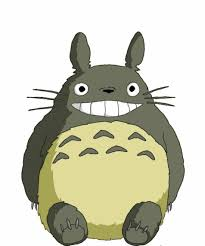

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
# X, y 분리
gene_expression=['exp_C_A', 'exp_C_B', 'exp_B_A']
result_C_A=['weight_kg_C_A','bmi_C_A', 'fat_C_A', 'pure_fat_C_A']

X_train, X_test, y_train, y_test = train_test_split(X[gene_expression], y[result_C_A], test_size=0.2, random_state=42)

# ✅ Multi-output 모델 정의
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

# ✅ 예측
y_pred = model.predict(X_test)

In [ ]:
# ✅ 평가 (각 열별 R² 출력)
r2_scores = {}
for i, col in enumerate(result_C_A):
    r2_scores[col] = r2_score(y_test[col], y_pred[:, i])

# 결과 보기 좋게 정리
r2_df = pd.DataFrame(list(r2_scores.items()), columns=["Target", "R2_Score"]).sort_values(by="R2_Score", ascending=False)

In [ ]:
r2_df

Target  R2_Score
3   pure_fat_C_A  0.213655
0  weight_kg_C_A  0.080443
1        bmi_C_A  0.070399
2        fat_C_A  0.059889

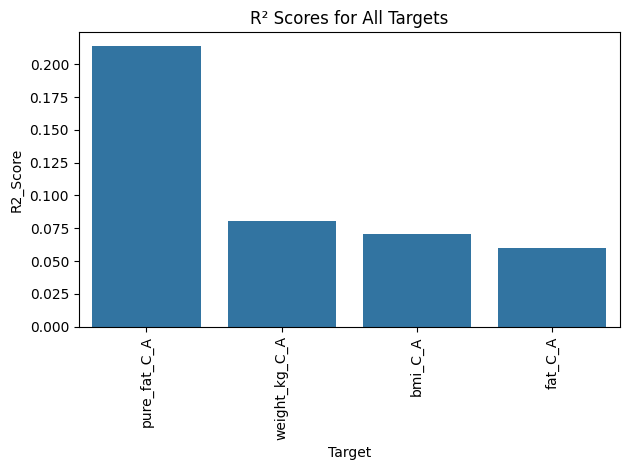

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(data=r2_df, x="Target", y="R2_Score")
plt.xticks(rotation=90)
plt.title("R² Scores for All Targets")
plt.tight_layout()
plt.show()

# **SHAP 해석**

In [ ]:
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 1. X와 y 정의 (너가 이미 설정한 기준)
X_selected = X[['exp_C_A', 'exp_C_B', 'exp_B_A']]
y_selected = y['pure_fat_C_A']

# 2. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.2, random_state=42)

# 3. 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

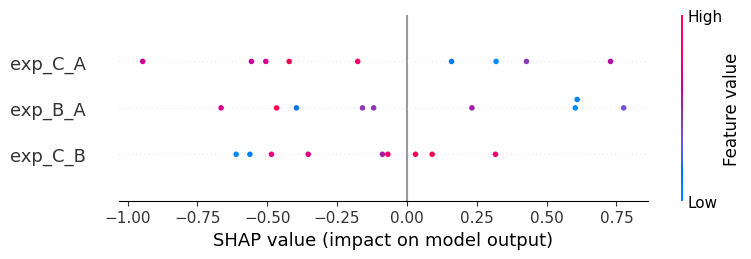

In [ ]:
# 4. SHAP 해석 준비
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# 5. Summary Plot (영향력 높은 feature 순서대로 시각화)
shap.summary_plot(shap_values, X_test)# 4. SHAP 해석 준비

In [ ]:
metadata.columns

In [ ]:
weight_bmi_changes.columns

# GPT 개짜증나게 하네

In [ ]:
# 비만 유전자 리스트
obesity_genes = ['FTO', 'MC4R', 'LEP', 'LEPR', 'ADIPOQ', 'PPARG', 'UCP1', 'UCP2', 'BDNF', 'GNPDA2', 'TMEM18', 'NEGR1']

In [ ]:
conn = sqlite3.connect(db_path)

df_exp_C_A = pd.read_sql_query("""
    SELECT
        E.subject_id,
        P.gene_symbol AS gene,
        E.exp_C_A
    FROM expression_change AS E
    JOIN platform AS P ON E.ID_REF = P.ID
    WHERE P.gene_symbol IN ('FTO', 'MC4R', 'LEP', 'LEPR', 'ADIPOQ', 'PPARG', 'UCP1', 'UCP2', 'BDNF', 'GNPDA2', 'TMEM18', 'NEGR1')
""", conn)

conn.close()

In [ ]:
df_exp_C_A.shape

(636, 3)

In [ ]:
# pivot: rows = subject, columns = gene, values = exp_C_A
exp_C_A_matrix = df_exp_C_A.pivot(index='subject_id', columns='gene', values='exp_C_A')

In [ ]:
# target 가져오기
conn = sqlite3.connect(db_path)
pure_fat_target = pd.read_sql_query("""
    SELECT subject_id, pure_fat_C_A
    FROM weight_bmi_changes
""", conn)
conn.close()

In [ ]:
# 병합
df_model = exp_C_A_matrix.merge(pure_fat_target, on='subject_id', how='inner')
df_model=df_model.dropna()
df_model.drop(columns='subject_id')

# X, y 분리
X = df_model.drop(columns='pure_fat_C_A')
y = df_model['pure_fat_C_A']

In [ ]:
df_model.shape

(47, 14)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

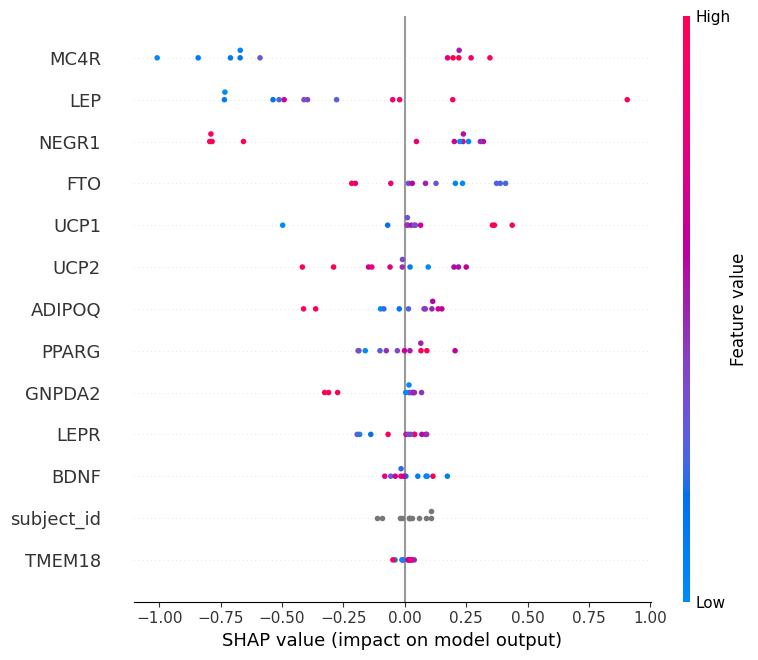

In [ ]:
# SHAP 해석
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# SHAP 시각화
shap.summary_plot(shap_values, X_test)

# 음 뭐지? 처음부터인가 다시


In [ ]:
!pip install xgboost shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sqlite3
import pandas as pd

conn = sqlite3.connect(db_path)

df_exp_C_A = pd.read_sql_query("""
    SELECT
        E.subject_id,
        P.gene_symbol AS gene,
        E.exp_C_A
    FROM expression_change AS E
    JOIN platform AS P ON E.ID_REF = P.ID
    WHERE P.gene_symbol IN ('FTO', 'MC4R', 'LEP', 'LEPR', 'ADIPOQ', 'PPARG', 'UCP1', 'UCP2', 'BDNF', 'GNPDA2', 'TMEM18', 'NEGR1')
""", conn)

conn.close()

In [ ]:
# pivot: rows = subject, columns = gene, values = exp_C_A
exp_C_A_matrix = df_exp_C_A.pivot(index='subject_id', columns='gene', values='exp_C_A')

In [ ]:
# target 가져오기
conn = sqlite3.connect(db_path)
pure_fat_target = pd.read_sql_query("""
    SELECT subject_id, pure_fat_C_A
    FROM weight_bmi_changes
""", conn)
conn.close()

In [ ]:
# 병합
df_model = exp_C_A_matrix.merge(pure_fat_target, on='subject_id', how='inner')
df_model_2=df_model.dropna()
df_model_3=df_model_2.drop(columns='subject_id')

# X, y 분리
X = df_model_3.drop(columns='pure_fat_C_A')
y = df_model_3['pure_fat_C_A']

In [ ]:
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# (이미 정의되어 있어야 함: X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
# 🔧 object 컬럼 제거
X_train = X_train.select_dtypes(include=['number'])
X_test = X_test.select_dtypes(include=['number'])

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
# XGBoost 모델 학습
model = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

R² score: 0.2951900614822385


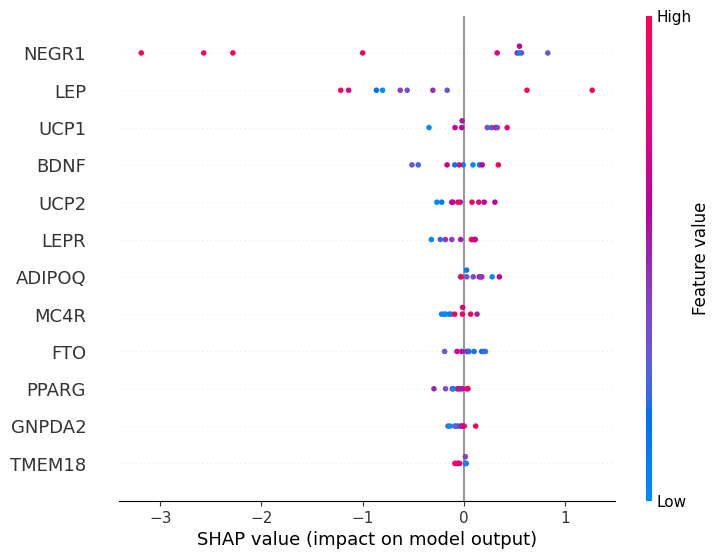

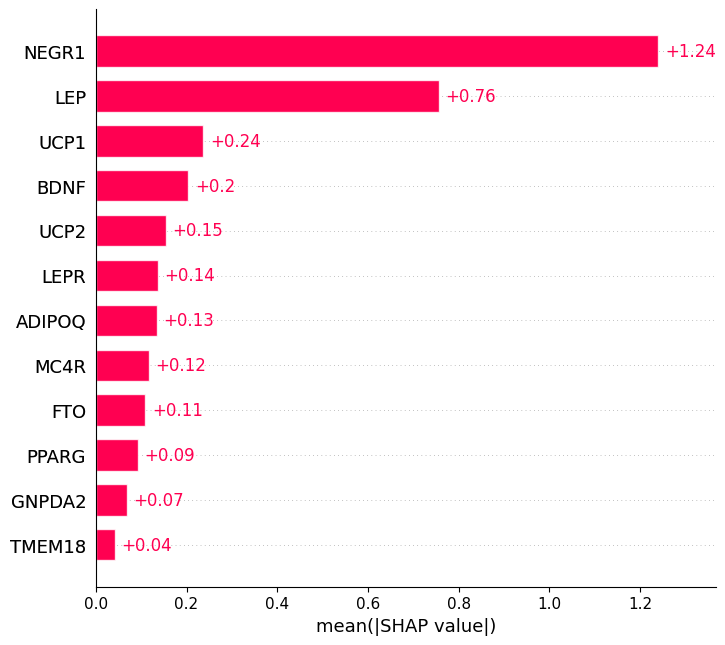

In [ ]:
# 예측 및 성능 확인
y_pred = model.predict(X_test)
print("R² score:", r2_score(y_test, y_pred))

# SHAP 값 계산
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# SHAP 시각화
shap.plots.beeswarm(shap_values, max_display=12)  # 중요도 순 전체
shap.plots.bar(shap_values, max_display=12)       # 평균 절대값 기준 top

In [ ]:
import shap
import xgboost as xgb
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score

# 그룹 설정
groups = df_model_2['subject_id'].values
X = df_model_2.drop(columns=['pure_fat_C_A', 'subject_id'])
y = df_model_2['pure_fat_C_A']

r2_list = []
shap_all_values = []

# 모델과 GroupKFold 정의
model = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
gkf = GroupKFold(n_splits=5)

In [ ]:
for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups)):
    print(f"\n📂 Fold {fold+1}")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    r2_list.append(r2)
    print("R²:", r2)

    # SHAP 계산 (1개 fold만 예시 시각화로 사용)
    if fold == 0:
        explainer = shap.Explainer(model)
        shap_values = explainer(X_test)
        shap_all_values = shap_values  # 저장


📂 Fold 1
R²: -2.1565452858907395

📂 Fold 2
R²: -1.9650063431681946

📂 Fold 3
R²: 0.2265677184325703

📂 Fold 4
R²: -2.871455977961891

📂 Fold 5
R²: 0.4124543738651256



📊 평균 R²: -1.2708


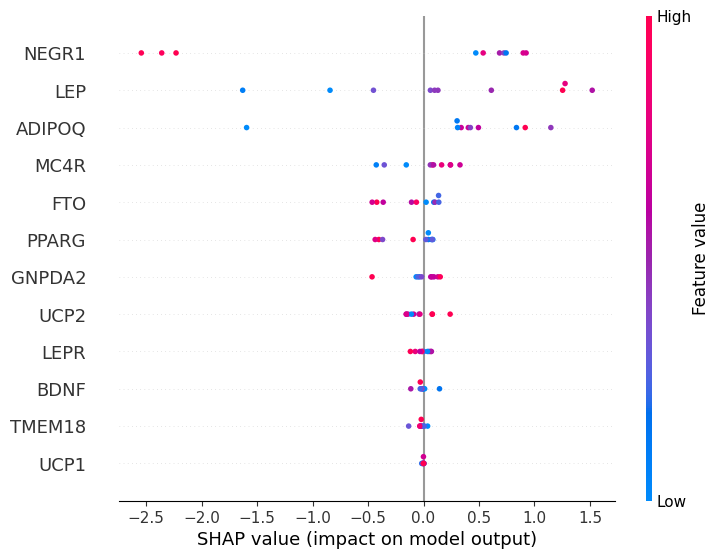

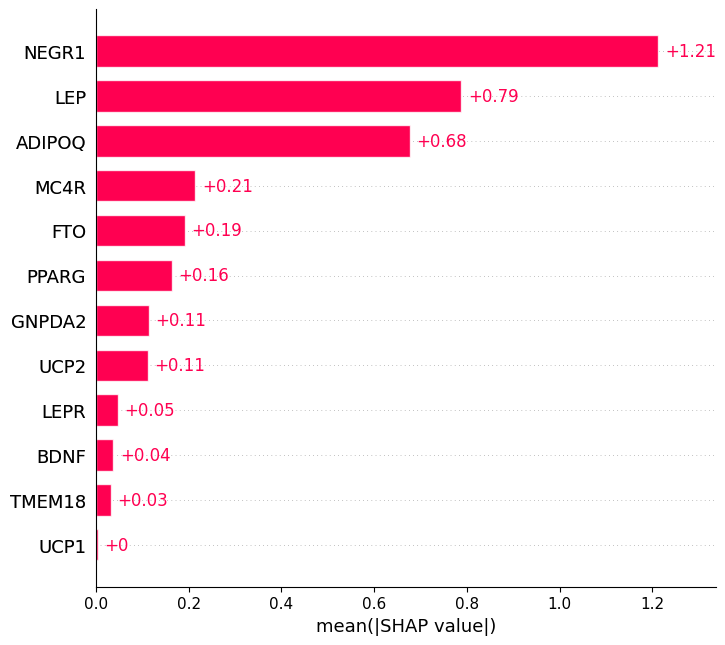

In [ ]:
# 평균 R²
print(f"\n📊 평균 R²: {np.mean(r2_list):.4f}")

# SHAP 시각화
shap.plots.beeswarm(shap_all_values, max_display=12)
shap.plots.bar(shap_all_values, max_display=12)

# treatment, sex, age, height, base_weight 중 어떤 feature가 가장 영향력이 큰지

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sqlite3
import pandas as pd

# SQLite DB 파일 경로
db_path="/content/drive/MyDrive/BIO_MEDICAL_PROJECT/obesitygene_project.db"
conn = sqlite3.connect(db_path)

# 1. 전체 테이블 목록 확인
tables_df = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("📦 전체 테이블 목록:")
print(tables_df)

# 2. 각 테이블별 컬럼 구조 출력
for table_name in tables_df['name']:
    print(f"\n📄 테이블: {table_name}")
    columns_df = pd.read_sql_query(f"PRAGMA table_info({table_name});", conn)
    print(columns_df)

conn.close()

📦 전체 테이블 목록:
                  name
0    expression_change
1  expression_long_old
2      expression_long
3             platform
4             metadata
5   weight_bmi_changes

📄 테이블: expression_change
   cid        name  type  notnull dflt_value  pk
0    0      ID_REF  TEXT        0       None   1
1    1  subject_id  TEXT        0       None   2
2    2     exp_C_A  REAL        0       None   0
3    3     exp_C_B  REAL        0       None   0
4    4     exp_B_A  REAL        0       None   0

📄 테이블: expression_long_old
   cid        name     type  notnull dflt_value  pk
0    0      ID_REF  INTEGER        0       None   0
1    1      gsm_id     TEXT        0       None   0
2    2  expression     REAL        0       None   0

📄 테이블: expression_long
   cid        name  type  notnull dflt_value  pk
0    0      ID_REF  TEXT        0       None   1
1    1      gsm_id  TEXT        0       None   2
2    2  expression  REAL        0       None   0

📄 테이블: platform
    cid             name     type

In [ ]:
import sqlite3
import pandas as pd

# DB 연결
conn = sqlite3.connect(db_path)

# 테이블 목록
tables = [
    "expression_change",
    "expression_long_old",
    "expression_long",
    "platform",
    "metadata",
    "weight_bmi_changes"
]

# 각 테이블별 행 수 가져오기
table_counts = []

for table in tables:
    count = pd.read_sql_query(f"SELECT COUNT(*) AS row_count FROM {table}", conn)
    table_counts.append((table, count['row_count'][0]))

# 결과 DataFrame으로 출력
df_counts = pd.DataFrame(table_counts, columns=["Table", "Row Count"])
conn.close()

df_counts

Table  Row Count
0    expression_change    1764741
1  expression_long_old    5061144
2      expression_long          0
3             platform      33297
4             metadata        152
5   weight_bmi_changes         53

In [ ]:
import sqlite3
import pandas as pd
import numpy as np

conn = sqlite3.connect(db_path)

# 1. 메타데이터 불러오기 (at study start)
subject_meta = pd.read_sql_query("""
SELECT subject_id, treatment, sex, age_yrs, height_cm,
       weight_kg AS base_weight, bmi_kg_m2 AS base_bmi,
       body_fat_pct AS base_fat_pct, pure_fat_kg AS base_pure_fat
FROM metadata
WHERE time_point = 'at study start'
""", conn)

# 2. 유전자 발현 데이터 (expression_long + metadata + platform)
gene_expr = pd.read_sql_query("""
SELECT M.subject_id, M.time_point, P.gene_symbol, E.expression
FROM expression_long_old E
JOIN metadata M ON E.gsm_id = M.gsm_id
JOIN platform P ON E.ID_REF = P.ID
WHERE P.gene_symbol IS NOT NULL
""", conn)

# 3. 체성분 데이터
bodycomp = pd.read_sql_query("""
SELECT subject_id, time_point, weight_kg, bmi_kg_m2, body_fat_pct, pure_fat_kg
FROM metadata
WHERE time_point IN ('at study start', 'after weight loss period', 'after weight stable period')
""", conn)

conn.close()

In [ ]:
subject_meta.to_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/subject_metadata.csv", index=False)
gene_expr.to_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/gene_expr.csv", index=False)
bodycomp.to_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/bodycomp.csv", index=False)

In [ ]:
subject_meta = pd.read_csv("/content/drive/MyDrive/subject_metadata.csv")
gene_expr = pd.read_csv("/content/drive/MyDrive/gene_expr.csv")
bodycomp = pd.read_csv("/content/drive/MyDrive/bodycomp.csv")

In [ ]:
subject_meta

subject_id              treatment     sex  age_yrs  height_cm  base_weight  \
0           1  very-low-calorie diet  female     46.0      167.0        83.38   
1           2  very-low-calorie diet  female     45.0      164.0        80.94   
2           3  very-low-calorie diet    male     52.0      178.5        99.62   
3           4  very-low-calorie diet  female     41.0      154.0        80.34   
4           5  very-low-calorie diet    male     56.0      179.0        96.67   
5           6       low-calorie diet  female     66.0      158.5        82.09   
6           8       low-calorie diet  female     48.0      165.0        78.25   
7           9       low-calorie diet  female     53.0      169.5        97.56   
8          10       low-calorie diet  female     40.0      172.0       100.01   
9          11       low-calorie diet    male     43.0      180.0        94.28   
10         12  very-low-calorie diet  female     51.0      165.0        85.04   
11         13       low-calorie diet  female     53.0      169.0       102.92   
12         14       low-calorie diet    male     63.0      185.5       119.63   
13         18  very-low-calorie diet  female     47.0      182.0        96.25   
14         19       low-calorie diet  female     67.0      155.5        86.03   
15         20       low-calorie diet    male     60.0      169.5        94.98   
16         21  very-low-calorie diet  female     42.0      158.5        87.40   
17         22  very-low-calorie diet    male     48.0      186.0       107.12   
18         23       low-calorie diet    male     66.0      178.0        99.85   
19         24       low-calorie diet  female     58.0      168.5        91.06   
20         25  very-low-calorie diet    male     50.0      175.5        94.24   
21         26  very-low-calorie diet    male     65.0      188.5       114.08   
22         27  very-low-calorie diet  female     42.0      169.5        81.43   
23         28  very-low-calorie diet  female     43.0      163.5        79.23   
24         29  very-low-calorie diet    male     59.0      186.0        98.66   
25         30  very-low-calorie diet    male     50.0      186.5       104.00   
26         31       low-calorie diet  female     50.0      164.0        90.06   
27         33       low-calorie diet    male     48.0      180.0        93.66   
28         34       low-calorie diet  female     50.0      159.0        72.87   
29         35       low-calorie diet  female     32.0      169.5        82.83   
30         36       low-calorie diet  female     53.0      170.0        79.31   
31         37  very-low-calorie diet  female     50.0      168.0        90.10   
32         38  very-low-calorie diet  female     60.0      169.5        96.72   
33         39       low-calorie diet  female     47.0      165.0        92.75   
34         40  very-low-calorie diet  female     56.0      158.0        83.60   
35         41       low-calorie diet  female     56.0      162.5        76.21   
36         42  very-low-calorie diet    male     52.0      180.5        93.56   
37         43  very-low-calorie diet    male     61.0      182.5       105.43   
38         45  very-low-calorie diet  female     53.0      165.0        85.66   
39         46  very-low-calorie diet  female     43.0      173.5        98.10   
40         47  very-low-calorie diet  female     66.0      170.0        79.63   
41         48       low-calorie diet    male     41.0      181.0       105.07   
42         49       low-calorie diet    male     39.0      177.0        99.32   
43         50       low-calorie diet  female     62.0      174.5       101.96   
44         51       low-calorie diet    male     65.0      176.0        94.28   
45         52  very-low-calorie diet    male     45.0      179.0        91.85   
46         53       low-calorie diet    male     34.0      184.0        94.09   
47         55  very-low-calorie diet    male     35.0      165.0        86.70   
48         56       low-calorie di

In [ ]:
gene_expr

subject_id                  time_point gene_symbol  expression
0                1              at study start      OR4F17    1.920236
1                1    after weight loss period      OR4F17    1.721877
2                1  after weight stable period      OR4F17    1.695896
3                2              at study start      OR4F17    2.046497
4                2    after weight loss period      OR4F17    1.747273
...            ...                         ...         ...         ...
3366491         56  after weight stable period       YIPF4    9.384527
3366492         59              at study start       YIPF4    8.852478
3366493         59    after weight loss period       YIPF4    9.029392
3366494         61              at study start       YIPF4    8.736060
3366495         61  after weight stable period       YIPF4    8.992191

[3366496 rows x 4 columns]

In [ ]:
bodycomp

subject_id                  time_point  weight_kg  bmi_kg_m2  \
0            1              at study start      83.38      29.90   
1            1    after weight loss period      75.16      26.95   
2            1  after weight stable period      73.79      26.46   
3            2              at study start      80.94      30.09   
4            2    after weight loss period      71.92      26.74   
..         ...                         ...        ...        ...   
147         56  after weight stable period      89.98      30.77   
148         59              at study start      82.42      29.03   
149         59    after weight loss period      75.01      26.42   
150         61              at study start      94.26      28.46   
151         61  after weight stable period      88.50      26.72   

     body_fat_pct  pure_fat_kg  
0            39.9     33.26862  
1            35.8     26.90728  
2            32.4     23.90796  
3            46.7     37.79898  
4            43.0     30.92560  
..            ...          ...  
147          36.5     32.84270  
148          28.2     23.24244  
149          21.2     15.90212  
150          31.1     29.31486  
151          26.6     23.54100  

[152 rows x 6 columns]

In [ ]:
gene_expr = pd.read_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/gene_expr.csv")
genes = sorted(gene_expr['gene_symbol'].unique())
subjects = sorted(gene_expr['subject_id'].unique())
timepoints = ['at study start', 'after weight loss period', 'after weight stable period']

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/gene_expr.csv'

In [ ]:
# === 1️⃣ gene_expression_tensor ===
genes = sorted(gene_expr['gene_symbol'].unique())
subjects = sorted(gene_expr['subject_id'].unique())
timepoints = ['at study start', 'after weight loss period', 'after weight stable period']

gene_tensor = np.full((len(subjects), len(genes), len(timepoints)), np.nan)
subj_idx = {s: i for i, s in enumerate(subjects)}
gene_idx = {g: i for i, g in enumerate(genes)}
time_idx = {t: i for i, t in enumerate(timepoints)}

for _, row in gene_expr.iterrows():
    s, g, t, val = row['subject_id'], row['gene_symbol'], row['time_point'], row['expression']
    if s in subj_idx and g in gene_idx and t in time_idx:
        gene_tensor[subj_idx[s], gene_idx[g], time_idx[t]] = val

# === 2️⃣ bodycomp_tensor ===
metrics = ['weight_kg', 'bmi_kg_m2', 'body_fat_pct', 'pure_fat_kg']
body_tensor = np.full((len(subjects), len(metrics), len(timepoints)), np.nan)

for _, row in bodycomp.iterrows():
    s = row['subject_id']
    if s in subj_idx and row['time_point'] in time_idx:
        for j, m in enumerate(metrics):
            body_tensor[subj_idx[s], j, time_idx[row['time_point']]] = row[m]

# === 3️⃣ subject_metadata ===
subject_meta.set_index('subject_id', inplace=True)
subject_meta = subject_meta.reindex(subjects)  # 순서 맞추기

In [ ]:
# 결과 확인
print("✅ gene_expression_tensor:", gene_tensor.shape)
print("✅ bodycomp_tensor:", body_tensor.shape)
print("✅ subject_metadata:", subject_meta.shape)

✅ gene_expression_tensor: (53, 20074, 3)
✅ bodycomp_tensor: (53, 4, 3)
✅ subject_metadata: (53, 8)


In [ ]:
import numpy as np
import pandas as pd

# gene_expression_tensor에서 비만 유전자 12개만 추출 후 시계열 C-A 차이 계산
# (이미 저장된 파일이 있다면 생략 가능)
np.save('/content/drive/MyDrive/BIO_MEDICAL_PROJECT/gene_expression_tensor.npy', gene_tensor)
np.save('/content/drive/MyDrive/BIO_MEDICAL_PROJECT/bodycomp_tensor.npy', body_tensor)
subject_meta.to_csv('/content/drive/MyDrive/BIO_MEDICAL_PROJECT/subject_metadata.csv', index=False)

In [ ]:
import numpy as np
import pandas as pd

# tensor 불러오기
gene_expression_tensor = np.load('gene_expression_tensor.npy')
bodycomp_tensor = np.load('bodycomp_tensor.npy')

# metadata 불러오기
subject_metadata = pd.read_csv('subject_metadata.csv')

In [ ]:
db_path="/content/drive/MyDrive/obesitygene_project.db"
conn = sqlite3.connect(db_path)

test_df= pd.read_sql_query('''
SELECT DISTINCT time_point FROM metadata
''', conn)

conn.close()

In [ ]:
test_df

time_point
0              at study start
1    after weight loss period
2  after weight stable period

# SHAP (GPU 가능 환경)으로 Feature Importance 분석

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [ ]:
# 1. 데이터 불러오기
X = pd.read_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/subject_metadata.csv")
gene_tensor = np.load("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/gene_expression_tensor.npy")  # (53, 20074, 3)
platform = pd.read_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/platform (1).csv")

In [ ]:
gene_tensor.shape

(53, 20074, 3)

In [ ]:
gene_expr = pd.read_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/gene_expr.csv")

In [ ]:
# 1. gene_symbol 순서와 인덱스 매핑
genes = sorted(gene_expr['gene_symbol'].unique())
gene_idx = {g: i for i, g in enumerate(genes)}  # 이름 → 인덱스 매핑

# 2. 비만 유전자 리스트
obesity_genes = ['FTO', 'MC4R', 'LEP', 'LEPR', 'ADIPOQ', 'PPARG',
                 'UCP1', 'UCP2', 'BDNF', 'GNPDA2', 'TMEM18', 'NEGR1']

# 3. 해당 인덱스만 추출
obesity_gene_indices = [gene_idx[g] for g in obesity_genes if g in gene_idx]

# 💾 나중에 재사용 가능!
print("비만 유전자 인덱스:", obesity_gene_indices)

비만 유전자 인덱스: [6600, 10364, 9288, 9289, 324, 13646, 18682, 18683, 1436, 7066, 17811, 11611]


In [ ]:
# 데이터 불러오기
X = pd.read_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/subject_metadata.csv")  # (53, 8)

# 범주형 컬럼 자동 인코딩 (drop_first=True는 다중공선성 방지용)
X_encoded = pd.get_dummies(X, columns=['treatment', 'sex'], drop_first=True)

# 타겟 Y: gene_expression_tensor에서 C-A (axis=2, index 2 - 0)
gene_tensor = np.load("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/gene_expression_tensor.npy")  # (53, 20074, 3)

y = gene_tensor[:, obesity_gene_indices, 2] - gene_tensor[:, obesity_gene_indices, 0]  # (53, 12)

In [ ]:
X

subject_id              treatment     sex  age_yrs  height_cm  \
0            1  very-low-calorie diet  female     46.0      167.0   
1            2  very-low-calorie diet  female     45.0      164.0   
2            3  very-low-calorie diet    male     52.0      178.5   
3            4  very-low-calorie diet  female     41.0      154.0   
4            5  very-low-calorie diet    male     56.0      179.0   
5            6       low-calorie diet  female     66.0      158.5   
6            8       low-calorie diet  female     48.0      165.0   
7            9       low-calorie diet  female     53.0      169.5   
8           10       low-calorie diet  female     40.0      172.0   
9           11       low-calorie diet    male     43.0      180.0   
10          12  very-low-calorie diet  female     51.0      165.0   
11          13       low-calorie diet  female     53.0      169.0   
12          14       low-calorie diet    male     63.0      185.5   
13          18  very-low-calorie diet  female     47.0      182.0   
14          19       low-calorie diet  female     67.0      155.5   
15          20       low-calorie diet    male     60.0      169.5   
16          21  very-low-calorie diet  female     42.0      158.5   
17          22  very-low-calorie diet    male     48.0      186.0   
18          23       low-calorie diet    male     66.0      178.0   
19          24       low-calorie diet  female     58.0      168.5   
20          25  very-low-calorie diet    male     50.0      175.5   
21          26  very-low-calorie diet    male     65.0      188.5   
22          27  very-low-calorie diet  female     42.0      169.5   
23          28  very-low-calorie diet  female     43.0      163.5   
24          29  very-low-calorie diet    male     59.0      186.0   
25          30  very-low-calorie diet    male     50.0      186.5   
26          31       low-calorie diet  female     50.0      164.0   
27          33       low-calorie diet    male     48.0      180.0   
28          34       low-calorie diet  female     50.0      159.0   
29          35       low-calorie diet  female     32.0      169.5   
30          36       low-calorie diet  female     53.0      170.0   
31          37  very-low-calorie diet  female     50.0      168.0   
32          38  very-low-calorie diet  female     60.0      169.5   
33          39       low-calorie diet  female     47.0      165.0   
34          40  very-low-calorie diet  female     56.0      158.0   
35          41       low-calorie diet  female     56.0      162.5   
36          42  very-low-calorie diet    male     52.0      180.5   
37          43  very-low-calorie diet    male     61.0      182.5   
38          45  very-low-calorie diet  female     53.0      165.0   
39          46  very-low-calorie diet  female     43.0      173.5   
40          47  very-low-calorie diet  female     66.0      170.0   
41          48       low-calorie diet    male     41.0      181.0   
42          49       low-calorie diet    male     39.0      177.0   
43          50       low-calorie diet  female     62.0      174.5   
44          51       low-calorie diet    male     65.0      176.0   
45          52  very-low-calorie diet    male     45.0      179.0   
46          53       low-calorie diet    male     34.0      184.0   
47          55  very-low-calorie diet    male     35.0      165.0   
48          56       low-calorie diet    male     56.0      171.0   
49          59       low-calorie diet    male     67.0      168.5   
50          61  very-low-calorie diet    male     52.0      182.0   

    base_weight  base_bmi  base_fat_pct  base_pure_fat  
0         83.38     29.90          39.9       33.26862  
1         80.94     30.09          46.7       37.79898  
2         99.62     31.27          27.2       27.09664  
3         80.34     33.88          46.5       37.35810  
4         96.67     30.17          32.9       31.80443  
5         82.09     32.68          47.4       38.91066  
6         78.25 

In [ ]:
y

array([[-1.33006390e-02, -1.90319460e-01, -4.65870119e-01,
        -2.47953250e-02, -1.96041420e-01,  2.29769295e-01,
         1.24142897e-01, -2.28979874e-01, -5.25471865e-01,
        -9.63855620e-02, -1.15466434e-01,  5.93887080e-02],
       [ 4.13252860e-02,  1.93809950e-01, -3.38549102e-01,
         7.49022580e-02,  1.15678200e-01,  4.44118990e-02,
         9.16438720e-02, -2.32967508e-01,  1.29058775e-01,
        -2.48119913e-01,  4.26790902e-01,  8.45082410e-02],
       [-3.05398310e-02, -2.20394039e-01, -4.77161841e-01,
         8.17103020e-02, -4.27139000e-03,  2.14200898e-01,
        -7.08614100e-03, -4.62435750e-02, -4.15119712e-01,
         1.14345189e-01, -4.73997920e-02,  1.02649189e-01],
       [ 1.21298093e-01, -9.77749669e-01, -1.15722149e-01,
         4.52690030e-01,  2.74725290e-01,  3.30164859e-01,
        -1.03062320e-01,  6.03682926e-01,  2.79585763e-01,
         5.39321381e-01,  8.68885890e-02, -7.09195860e-02],
       [ 3.56441520e-01, -7.07448835e-01, -2.9234463

In [ ]:
gene_diff.shape

(53, 12)

In [ ]:
y.shape[1]

12

In [ ]:
# 1. X와 y를 임시로 합치기
y_df = pd.DataFrame(y, columns=[f"gene_{i}" for i in range(y.shape[1])])
df = pd.concat([X_encoded, y_df], axis=1)

# 2. NaN이 포함된 행 삭제
df_clean = df.dropna()

# 3. 다시 X, y로 나누기
X_clean = df_clean[X_encoded.columns]
X_clean = X_clean.drop(columns=["subject_id"]) if "subject_id" in X_clean.columns else X_clean
y_clean = df_clean[y_df.columns]  # 여기를 y_df.columns로 바꾸면 OK

In [ ]:
X_clean

age_yrs  height_cm  base_weight  base_bmi  base_fat_pct  base_pure_fat  \
0      46.0      167.0        83.38     29.90          39.9       33.26862   
1      45.0      164.0        80.94     30.09          46.7       37.79898   
2      52.0      178.5        99.62     31.27          27.2       27.09664   
3      41.0      154.0        80.34     33.88          46.5       37.35810   
4      56.0      179.0        96.67     30.17          32.9       31.80443   
5      66.0      158.5        82.09     32.68          47.4       38.91066   
7      53.0      169.5        97.56     33.96          55.0       53.65800   
8      40.0      172.0       100.01     33.81          45.3       45.30453   
9      43.0      180.0        94.28     29.10          30.3       28.56684   
10     51.0      165.0        85.04     31.24          49.4       42.00976   
11     53.0      169.0       102.92     36.04          51.8       53.31256   
12     63.0      185.5       119.63     34.77          37.3       44.62199   
13     47.0      182.0        96.25     29.06          42.6       41.00250   
14     67.0      155.5        86.03     35.58          55.7       47.91871   
15     60.0      169.5        94.98     33.06          37.0       35.14260   
16     42.0      158.5        87.40     34.79          45.8       40.02920   
18     66.0      178.0        99.85     31.51          28.3       28.25755   
19     58.0      168.5        91.06     32.07          48.1       43.79986   
20     50.0      175.5        94.24     30.60          37.9       35.71696   
21     65.0      188.5       114.08     32.10          30.6       34.90848   
22     42.0      169.5        81.43     28.34          42.9       34.93347   
23     43.0      163.5        79.23     29.64          42.5       33.67275   
24     59.0      186.0        98.66     28.52          31.0       30.58460   
25     50.0      186.5       104.00     29.90          25.7       26.72800   
26     50.0      164.0        90.06     33.48          50.4       45.39024   
27     48.0      180.0        93.66     28.91          32.0       29.97120   
28     50.0      159.0        72.87     28.82          43.0       31.33410   
29     32.0      169.5        82.83     28.83          44.6       36.94218   
30     53.0      170.0        79.31     27.44          38.4       30.45504   
31     50.0      168.0        90.10     31.92          47.9       43.15790   
32     60.0      169.5        96.72     33.66          49.6       47.97312   
33     47.0      165.0        92.75     34.07          51.2       47.48800   
34     56.0      158.0        83.60     33.49          51.0       42.63600   
35     56.0      162.5        76.21     28.86          34.4       26.21624   
36     52.0      180.5        93.56     28.72          32.8       30.68768   
37     61.0      182.5       105.43     31.65          33.9       35.74077   
38     53.0      165.0        85.66     31.46          49.5       42.40170   
39     43.0      173.5        98.10     32.59          46.0       45.12600   
40     66.0      170.0        79.63     27.55          43.1       34.32053   
42     39.0      177.0        99.32     31.70          31.5       31.28580   
43     62.0      174.5       101.96     33.48          49.9       50.87804   
46     34.0      184.0        94.09     27.79          22.4       21.07616   
47     35.0      165.0        86.70     31.85          31.4       27.22380   
49     67.0      168.5        82.42     29.03          28.2       23.24244   
50     52.0      182.0        94.26     28.46          31.1       29.31486   

   treatment_very-low-calorie diet sex_male  
0                             True    False  
1                             True    False  
2                             True     True  
3                             True    False  
4                             True     True  
5                            False    False  
7                            False    False  
8                            False    False  
9

In [ ]:
y_clean

gene_0    gene_1    gene_2    gene_3    gene_4    gene_5    gene_6  \
0  -0.013301 -0.190319 -0.465870 -0.024795 -0.196041  0.229769  0.124143   
1   0.041325  0.193810 -0.338549  0.074902  0.115678  0.044412  0.091644   
2  -0.030540 -0.220394 -0.477162  0.081710 -0.004271  0.214201 -0.007086   
3   0.121298 -0.977750 -0.115722  0.452690  0.274725  0.330165 -0.103062   
4   0.356442 -0.707449 -0.292345  0.354884  0.381785  0.249043 -0.492953   
5  -0.081788  0.172764 -0.346569 -0.210482 -0.224576 -0.007982 -0.593889   
7   0.122677 -0.248531 -0.229164  0.405684  0.267665  0.394284 -0.673655   
8   0.176622 -0.084552 -0.031183 -0.017908  0.177774  0.235191  0.023198   
9  -0.356816  0.708908 -0.979490 -0.217327 -0.518054 -0.143799 -0.034194   
10 -0.173498  0.362516 -0.837343 -0.301594 -0.246423 -0.138474  0.052075   
11  0.130392  0.459919 -0.069449  0.187249  0.675289  0.300133 -0.116819   
12  0.278440 -0.092864 -0.406941  0.144761 -0.055102  0.258738  0.094418   
13  0.273306 -0.530811  0.106646  0.117624  0.718589  0.588460  0.115129   
14 -0.239625 -0.400058 -0.751408 -0.137368  0.034511 -0.002528  0.024568   
15 -0.105405 -0.067876 -0.293568  0.382373 -0.113871 -0.049880  0.015650   
16 -0.162053  0.214223 -0.693865  0.153336  0.092030 -0.000102 -0.308563   
18 -0.268319 -0.109556 -0.423308  0.069892 -0.164132 -0.238539  0.349214   
19  0.103171 -0.332635 -0.342792 -0.095258  0.225819  0.093823  0.182046   
20 -0.346506  0.561015 -0.856264 -0.171752 -0.175765 -0.265013  0.020825   
21 -0.192039 -0.805311 -0.706295 -0.060711 -0.304040  0.071046  0.310576   
22 -0.252485  0.039358 -0.526457  0.056751 -0.119829  0.052861 -0.275440   
23  0.376346  0.117773  0.713343  0.511323  0.238169  0.587793 -0.323645   
24 -0.069844  0.193960 -0.609728  0.107450 -0.187742 -0.164333  0.151842   
25 -0.267340 -0.096947 -0.252802 -0.120998 -0.072039  0.038792  0.340957   
26 -0.228211  0.584844 -0.840043  0.036690 -0.110008 -0.089884  0.239724   
27 -0.062133 -0.700997 -0.314468  0.051909 -0.085973 -0.007191  0.129465   
28 -0.023815 -0.661680 -0.946836  0.304409  0.088830  0.052338 -0.209858   
29 -0.162058 -0.065330 -0.257475  0.191496  0.041035 -0.524440  0.405400   
30  0.199921  0.149483  0.363810  0.097061  0.076487  0.569511 -0.184525   
31  0.013704 -0.191936 -0.430908  0.195762 -0.203140 -0.120960 -0.050270   
32  0.030204  0.189079 -0.919521 -0.090866  0.110760  0.036412  0.032406   
33  0.073315  0.113212 -0.563828  0.003301  0.273440  0.110558 -0.002374   
34  0.003875 -0.315851 -1.660715 -0.181667 -0.137499  0.224692 -0.060530   
35 -0.075218 -0.396995 -0.657420  0.025052 -0.077212  0.015980  0.189079   
36 -0.023963 -0.185417 -0.894632  0.246825 -0.132228 -0.104141 -0.015316   
37 -0.003753 -0.439173 -0.691701 -0.252273 -0.185659 -0.030286  0.179108   
38  0.194707  0.187006 -0.709940  0.066630  0.007903 -0.038143  0.136339   
39 -0.417525  0.649030 -1.199631 -0.658657 -0.243024 -0.107561 -0.112085   
40  0.835166 -0.343142  0.799537  0.690802  1.300431  0.848258 -0.435016   
42  0.070089  0.298276 -0.831378 -0.154059 -0.211989 -0.171042  0.059662   
43 -0.357452  0.373280 -0.077448 -0.539576 -0.078117 -0.035176 -0.020797   
46 -0.183659  0.261473 -0.509459  0.471152 -0.115100 -0.112659 -0.365076   
47 -0.094094  0.403948  0.681304 -0.002767  0.092120  0.055129  0.228732   
49 -0.225121  0.466712 -0.476599 -0.305968 -0.049754 -0.039589 -0.088010   
50  0.165903  0.280778  0.380700 -0.047348 -0.082024  0.221693  0.246989   

      gene_7    gene_8    gene_9   gene_10   gene_11  
0  -0.228980 -0.525472 -0.096386 -0.115466  0.059389  
1  -0.232968  0.129059 -0.248120  0.426791  0.084508  
2  -0.046244 -0.415120  0.114345 -0.047400  0.102649  
3   0.603683  0.279586  0.539321  0.086889 -0.070920  
4  -0.440636 -0.002045  0.561500  0.003735  0.445684  
5  -0.235135 -0.359239 -0.411572 -0.018277 -0.088919  
7  -0.327299 -0.093116  0.517616 -0.039706  0.346883  
8   0.099396 -0.112251  0.217103  0.018446  0.076812  
9  -0.115870 -

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# 멀티타겟 회귀
base_model = RandomForestRegressor(n_estimators=100, random_state=42)
model = MultiOutputRegressor(base_model)

model.fit(X_clean, y_clean)  # gene_diff shape: (53, 12)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

In [ ]:
import shap
import pandas as pd
import numpy as np
from tqdm import tqdm

# 결과 저장용 딕셔너리
gene_shap_dict = {}

# 유전자별로 SHAP 계산 (총 12개 모델)
for i, gene_name in tqdm(enumerate(obesity_genes), total=len(obesity_genes)):
    # i번째 유전자 모델 추출
    single_model = model.estimators_[i]

    # SHAP explainer
    explainer = shap.TreeExplainer(single_model)
    shap_values = explainer.shap_values(X_clean)  # (n_samples, n_features)

    # 평균 절댓값 SHAP
    mean_abs_shap = np.abs(shap_values).mean(axis=0)  # (n_features,)

    # 저장
    gene_shap_dict[gene_name] = mean_abs_shap

# 최종 DataFrame 생성
gene_feature_shap_df = pd.DataFrame(gene_shap_dict, index=X_clean.columns).T

# 확인
display(gene_feature_shap_df.head())

100%|██████████| 12/12 [00:00<00:00, 13.92it/s]


age_yrs  height_cm  base_weight  base_bmi  base_fat_pct  \
FTO     0.033860   0.045974     0.015560  0.029399      0.011752   
MC4R    0.043708   0.031271     0.038073  0.045311      0.119989   
LEP     0.026998   0.104899     0.095625  0.053599      0.027614   
LEPR    0.052496   0.012386     0.031001  0.031822      0.019891   
ADIPOQ  0.032847   0.049212     0.025169  0.044472      0.021996   

        base_pure_fat  treatment_very-low-calorie diet  sex_male  
FTO          0.017314                         0.011702  0.001087  
MC4R         0.050093                         0.038423  0.004937  
LEP          0.032505                         0.009864  0.017548  
LEPR         0.014155                         0.018608  0.000760  
ADIPOQ       0.026067                         0.002744  0.001839

In [ ]:
gene_feature_shap_df.to_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/gene_feature_shap_df.csv")

In [ ]:
import pandas as pd
gene_feature_shap_df=pd.read_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/gene_feature_shap_df.csv")

In [ ]:
gene_feature_shap_df.shape

(12, 8)

### Feature 중요도 vs 편차 시각화 코드

In [ ]:
import matplotlib.pyplot as plt

# 평균 중요도와 표준편차 계산
mean_importance = gene_feature_shap_df.mean(axis=0)
std_importance = gene_feature_shap_df.std(axis=0)

# 중요도 기준으로 정렬
sorted_features = mean_importance.sort_values(ascending=False).index
mean_sorted = mean_importance[sorted_features]
std_sorted = std_importance[sorted_features]

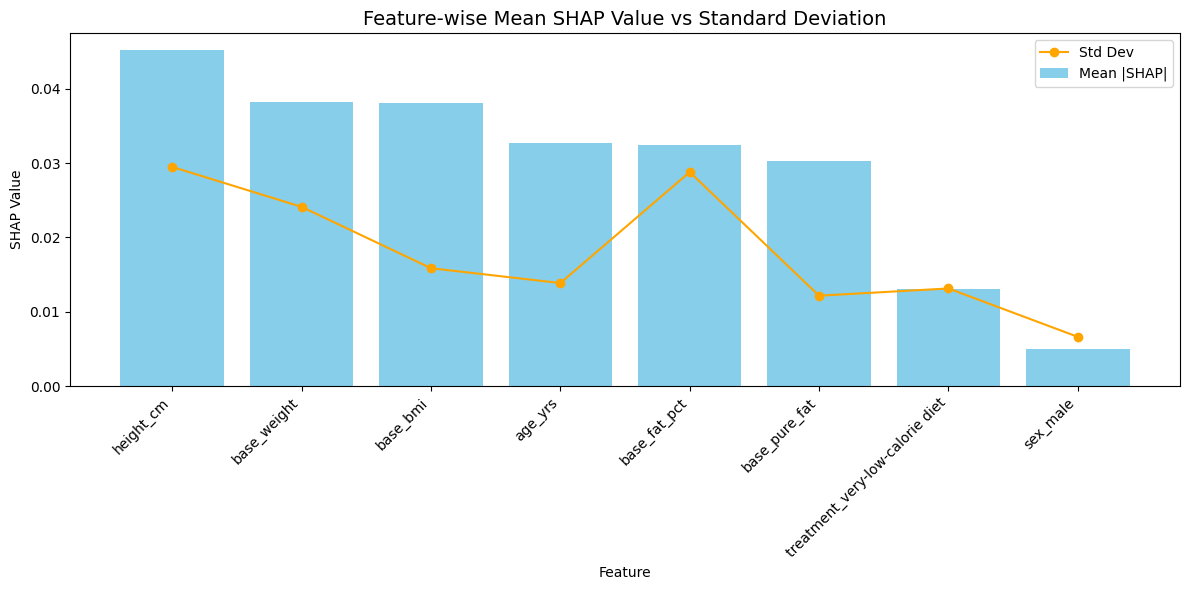

In [ ]:
# 시각화
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Bar: 평균 중요도
ax.bar(sorted_features, mean_sorted, color='skyblue', label='Mean |SHAP|')

# Line: 표준편차
ax.plot(sorted_features, std_sorted, color='orange', marker='o', label='Std Dev')

plt.title("Feature-wise Mean SHAP Value vs Standard Deviation", fontsize=14)
plt.ylabel("SHAP Value")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

### z-score

In [ ]:
from scipy.stats import zscore

# z-score 계산 (axis=1 또는 0, 너의 목적에 따라)
z_array_1 = zscore(gene_feature_shap_df, axis=1)
z_array_0 = zscore(gene_feature_shap_df, axis=0)

# DataFrame으로 다시 변환
gene_shap_zscore_df_1 = pd.DataFrame(z_array_1, index=gene_feature_shap_df.index, columns=gene_feature_shap_df.columns)
gene_shap_zscore_df_0 = pd.DataFrame(z_array_0, index=gene_feature_shap_df.index, columns=gene_feature_shap_df.columns)

# -------------------------------
# ✅ [1] 유전자별로 가장 민감한 Feature Top-3
topk_gene_to_feature = {}

for gene in gene_shap_zscore_df_1.index:
    top_features = gene_shap_zscore_df_1.loc[gene].sort_values(ascending=False).head(3)
    topk_gene_to_feature[gene] = top_features

# 결과 확인
print("🧬 유전자별 Top-3 민감 Feature:")
for gene, feats in topk_gene_to_feature.items():
    print(f"{gene}: {list(feats.index)} (z: {feats.values.round(2)})")

# -------------------------------
# ✅ [2] Feature별로 가장 민감한 유전자 Top-3
topk_feature_to_gene = {}

for feature in gene_shap_zscore_df_0.columns:
    top_genes = gene_shap_zscore_df_0[feature].sort_values(ascending=False).head(3)
    topk_feature_to_gene[feature] = top_genes

# 결과 확인
print("\n📊 Feature별 Top-3 민감 유전자:")
for feat, genes in topk_feature_to_gene.items():
    print(f"{feat}: {list(genes.index)} (z: {genes.values.round(2)})")

🧬 유전자별 Top-3 민감 Feature:
FTO: ['height_cm', 'age_yrs', 'base_bmi'] (z: [1.85 0.96 0.63])
MC4R: ['base_fat_pct', 'base_pure_fat', 'base_bmi'] (z: [ 2.4   0.12 -0.04])
LEP: ['height_cm', 'base_weight', 'base_bmi'] (z: [1.75 1.48 0.22])
LEPR: ['age_yrs', 'base_bmi', 'base_weight'] (z: [2.03 0.63 0.57])
ADIPOQ: ['height_cm', 'base_bmi', 'age_yrs'] (z: [1.47 1.18 0.45])
PPARG: ['height_cm', 'base_bmi', 'base_pure_fat'] (z: [ 2.54  0.04 -0.12])
UCP1: ['base_weight', 'base_bmi', 'height_cm'] (z: [1.51 1.34 0.64])
UCP2: ['base_weight', 'height_cm', 'base_pure_fat'] (z: [1.59 0.68 0.58])
BDNF: ['base_bmi', 'base_pure_fat', 'age_yrs'] (z: [2.2 0.8 0.3])
GNPDA2: ['age_yrs', 'base_weight', 'base_pure_fat'] (z: [1.37 0.82 0.44])
TMEM18: ['height_cm', 'base_pure_fat', 'base_weight'] (z: [1.33 0.48 0.44])
NEGR1: ['height_cm', 'base_weight', 'base_fat_pct'] (z: [1.4  1.17 0.31])

📊 Feature별 Top-3 민감 유전자:
age_yrs: ['GNPDA2', 'LEPR', 'MC4R'] (z: [1.75 1.49 0.83])
height_cm: ['LEP', 'PPARG', 'ADIPOQ'] (z

In [ ]:
import pandas as pd

# 1. 유전자 기준 데이터
gene_data = {
    'FTO': [('height_cm', 1.85), ('age_yrs', 0.96), ('base_bmi', 0.63)],
    'MC4R': [('base_fat_pct', 2.4), ('base_pure_fat', 0.12), ('base_bmi', -0.04)],
    'LEP': [('height_cm', 1.75), ('base_weight', 1.48), ('base_bmi', 0.22)],
    'LEPR': [('age_yrs', 2.03), ('base_bmi', 0.63), ('base_weight', 0.57)],
    'ADIPOQ': [('height_cm', 1.47), ('base_bmi', 1.18), ('age_yrs', 0.45)],
    'PPARG': [('height_cm', 2.54), ('base_bmi', 0.04), ('base_pure_fat', -0.12)],
    'UCP1': [('base_weight', 1.51), ('base_bmi', 1.34), ('height_cm', 0.64)],
    'UCP2': [('base_weight', 1.59), ('height_cm', 0.68), ('base_pure_fat', 0.58)],
    'BDNF': [('base_bmi', 2.2), ('base_pure_fat', 0.8), ('age_yrs', 0.3)],
    'GNPDA2': [('age_yrs', 1.37), ('base_weight', 0.82), ('base_pure_fat', 0.44)],
    'TMEM18': [('height_cm', 1.33), ('base_pure_fat', 0.48), ('base_weight', 0.44)],
    'NEGR1': [('height_cm', 1.4), ('base_weight', 1.17), ('base_fat_pct', 0.31)],
}

# 2. Feature 기준 데이터
feature_data = {
    'age_yrs': [('GNPDA2', 1.75), ('LEPR', 1.49), ('MC4R', 0.83)],
    'height_cm': [('LEP', 2.12), ('PPARG', 1.9), ('ADIPOQ', 0.14)],
    'base_weight': [('LEP', 2.49), ('UCP2', 1.08), ('GNPDA2', 0.4)],
    'base_bmi': [('BDNF', 2.55), ('LEP', 1.02), ('MC4R', 0.47)],
    'base_fat_pct': [('MC4R', 3.18), ('UCP2', 0.33), ('GNPDA2', 0.04)],
    'base_pure_fat': [('MC4R', 1.7), ('UCP2', 1.29), ('BDNF', 1.11)],
    'treatment_very-low-calorie diet': [('MC4R', 2.02), ('GNPDA2', 1.98), ('TMEM18', 0.48)],
    'sex_male': [('LEP', 1.97), ('UCP2', 1.91), ('NEGR1', 1.13)],
}

# 3. 유전자 기준 테이블 생성
gene_rows = []
for gene, feats in gene_data.items():
    for feat, z in feats:
        gene_rows.append({'Gene': gene, 'Feature': feat, 'Z_gene': z})
gene_df = pd.DataFrame(gene_rows)

# 4. Feature 기준 테이블 생성
feat_rows = []
for feat, genes in feature_data.items():
    for gene, z in genes:
        feat_rows.append({'Gene': gene, 'Feature': feat, 'Z_feat': z})
feat_df = pd.DataFrame(feat_rows)

# 5. 병합
merged_df = pd.merge(gene_df, feat_df, on=['Gene', 'Feature'], how='outer')

# 6. Z-score 구간에 따라 필터링
def classify_relation(row):
    g, f = row['Z_gene'], row['Z_feat']
    g_valid = pd.notna(g) and g >= 1.48
    f_valid = pd.notna(f) and f >= 1.48
    if g_valid and f_valid:
        return '🔵 교집합'
    elif g_valid:
        return '🟢 유전자 기준만 민감'
    elif f_valid:
        return '🟡 Feature 기준만 민감'
    else:
        return None

merged_df['Group'] = merged_df.apply(classify_relation, axis=1)
final_df = merged_df[merged_df['Group'].notnull()].sort_values('Group')

In [ ]:
final_df

Gene                          Feature  Z_gene  Z_feat             Group
4     BDNF                         base_bmi    2.20    2.55             🔵 교집합
15     LEP                      base_weight    1.48    2.49             🔵 교집합
16     LEP                        height_cm    1.75    2.12             🔵 교집합
18    LEPR                          age_yrs    2.03    1.49             🔵 교집합
23    MC4R                     base_fat_pct    2.40    3.18             🔵 교집합
32   PPARG                        height_cm    2.54    1.90             🔵 교집합
9   GNPDA2                          age_yrs    1.37    1.75  🟡 Feature 기준만 민감
13  GNPDA2  treatment_very-low-calorie diet     NaN    1.98  🟡 Feature 기준만 민감
17     LEP                         sex_male     NaN    1.97  🟡 Feature 기준만 민감
24    MC4R                    base_pure_fat    0.12    1.70  🟡 Feature 기준만 민감
25    MC4R  treatment_very-low-calorie diet     NaN    2.02  🟡 Feature 기준만 민감
44    UCP2                         sex_male     NaN    1.91  🟡 Feature 기준만 민감
8      FTO                        height_cm    1.85     NaN      🟢 유전자 기준만 민감
38    UCP1                      base_weight    1.51     NaN      🟢 유전자 기준만 민감
42    UCP2                      base_weight    1.59    1.08      🟢 유전자 기준만 민감

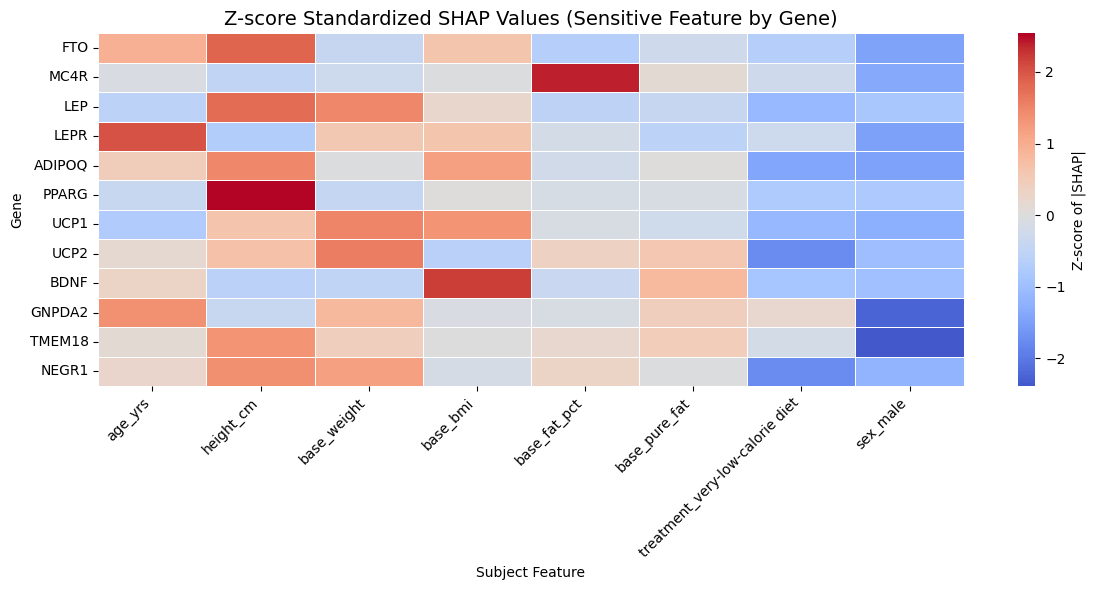

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(gene_shap_zscore_df_1, cmap='coolwarm', center=0, annot=False, fmt=".2f",
            linewidths=0.5, cbar_kws={'label': 'Z-score of |SHAP|'})

plt.title("Z-score Standardized SHAP Values (Sensitive Feature by Gene)", fontsize=14)
plt.xlabel("Subject Feature")
plt.ylabel("Gene")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

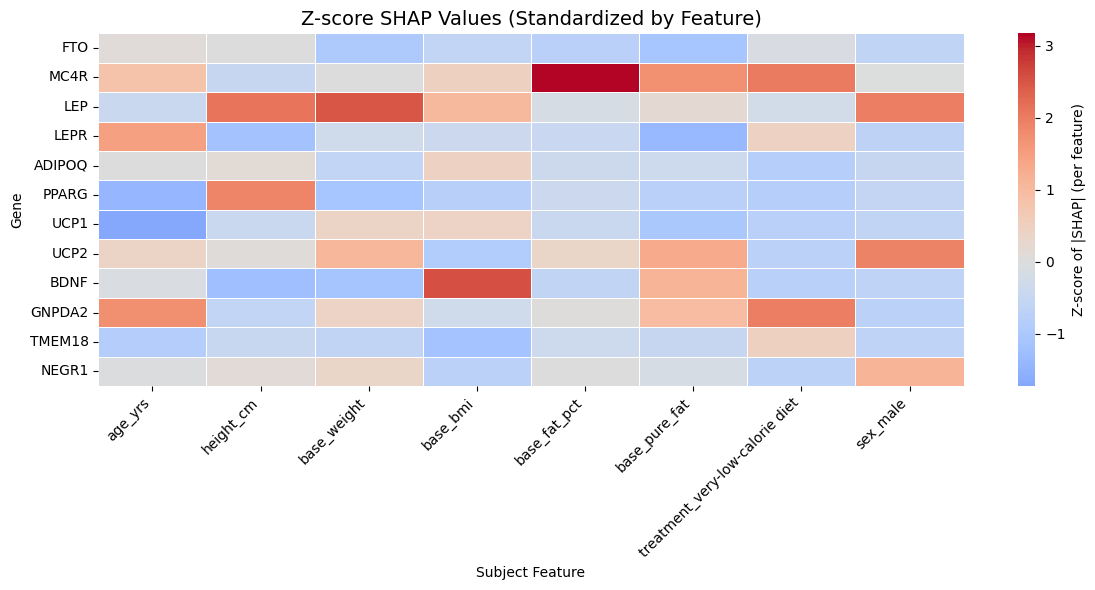

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(gene_shap_zscore_df_0, cmap='coolwarm', center=0, annot=False, fmt=".2f",
            linewidths=0.5, cbar_kws={'label': 'Z-score of |SHAP| (per feature)'})

plt.title("Z-score SHAP Values (Standardized by Feature)", fontsize=14)
plt.xlabel("Subject Feature")
plt.ylabel("Gene")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

🧬 SHAP for: FTO


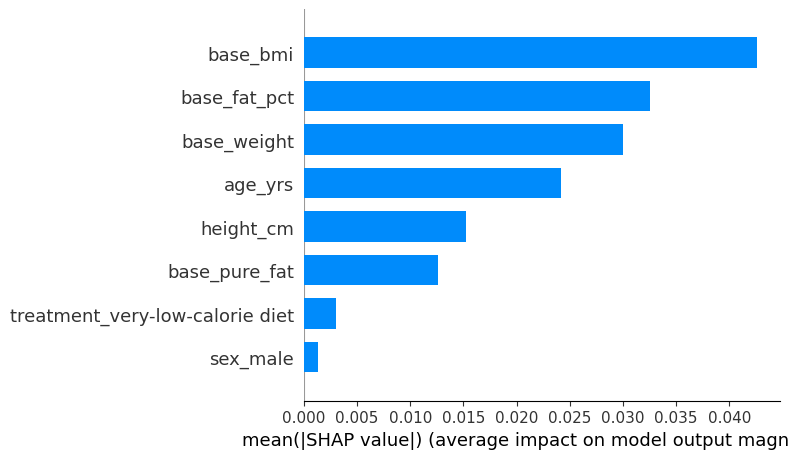

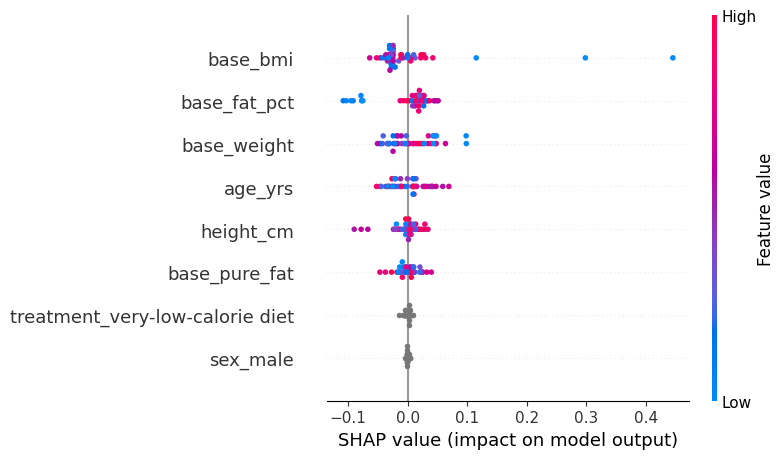

🧬 SHAP for: MC4R


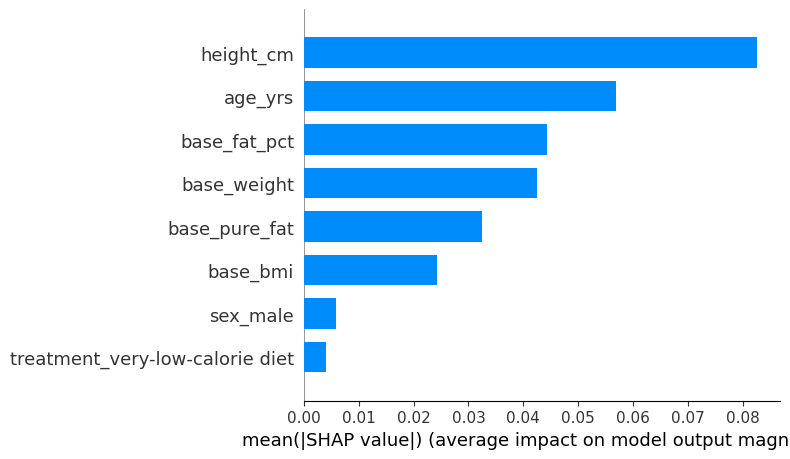

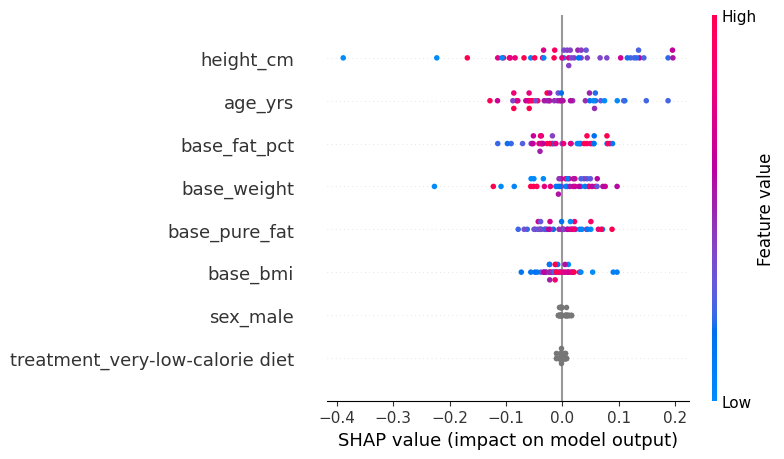

🧬 SHAP for: LEP


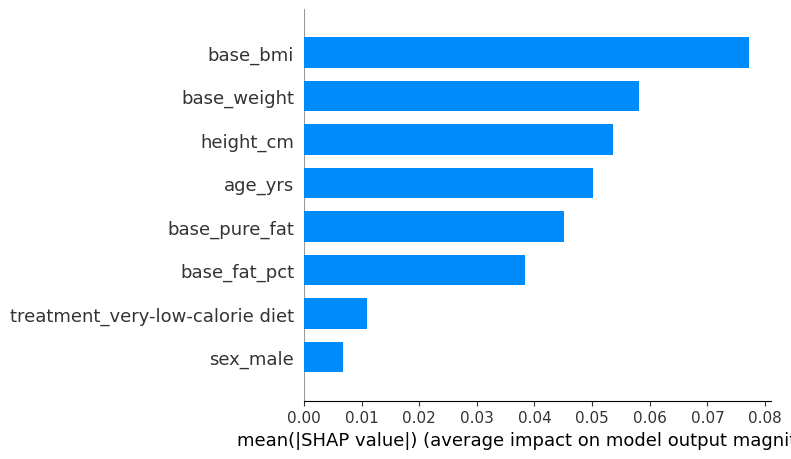

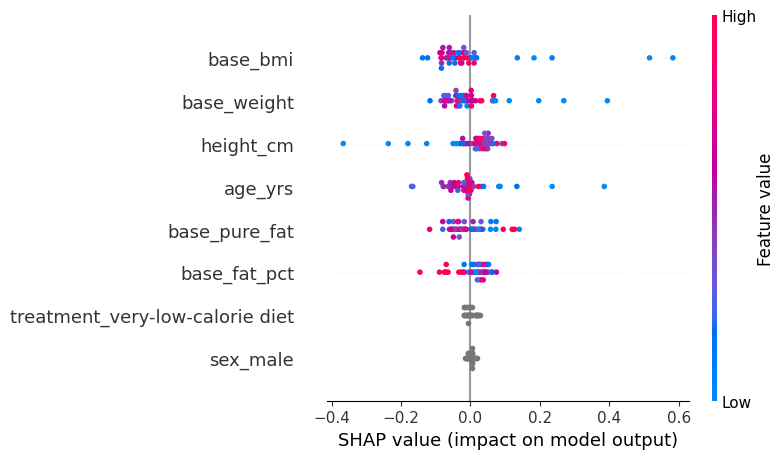

🧬 SHAP for: LEPR


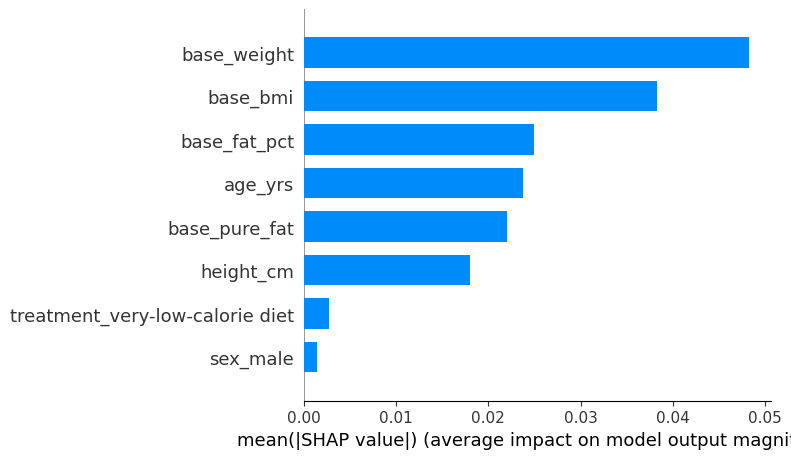

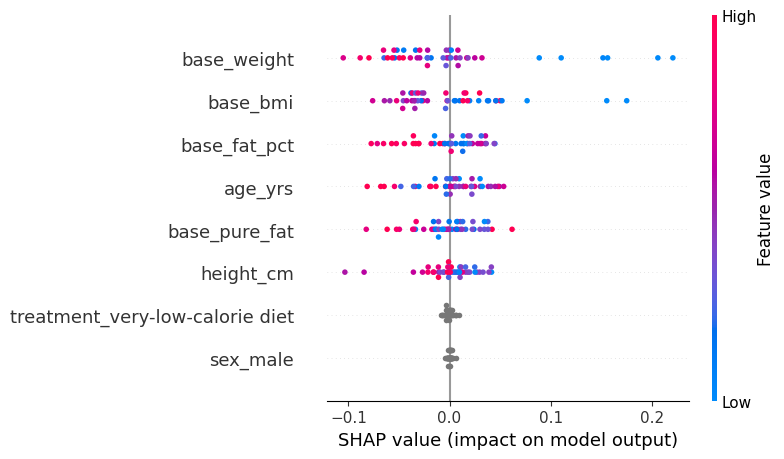

🧬 SHAP for: ADIPOQ


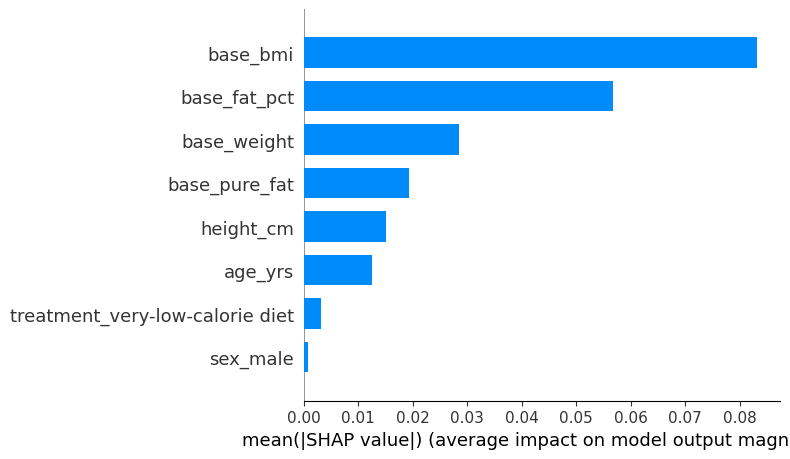

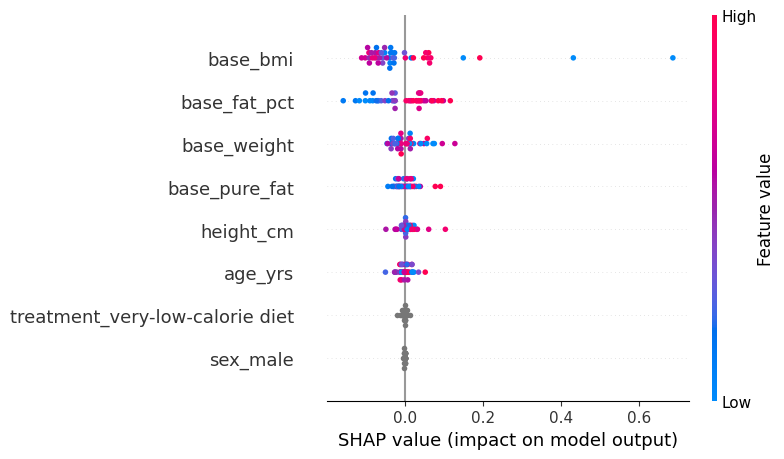

🧬 SHAP for: PPARG


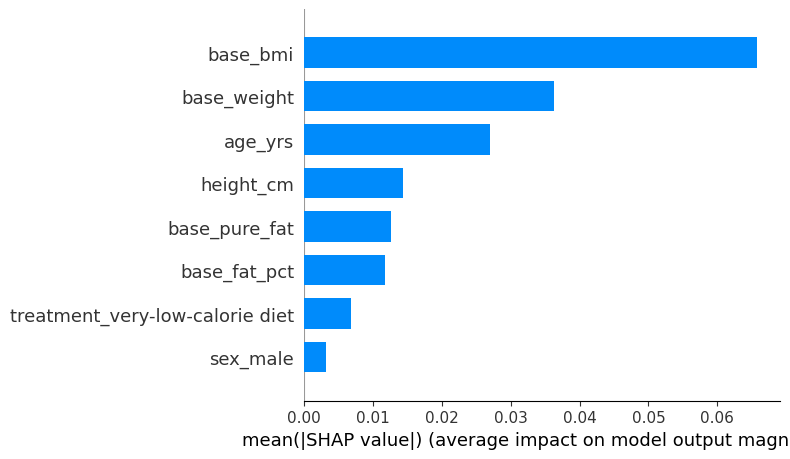

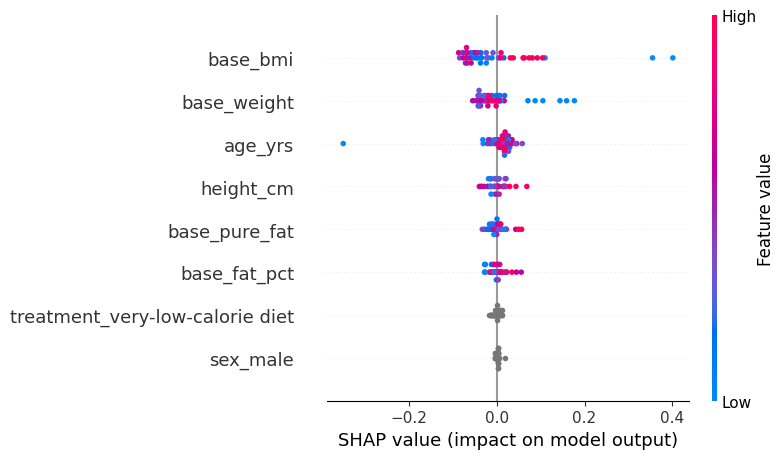

🧬 SHAP for: UCP1


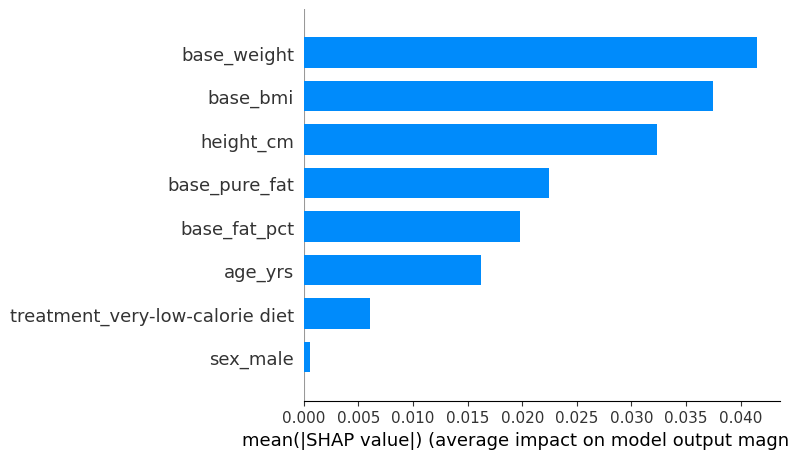

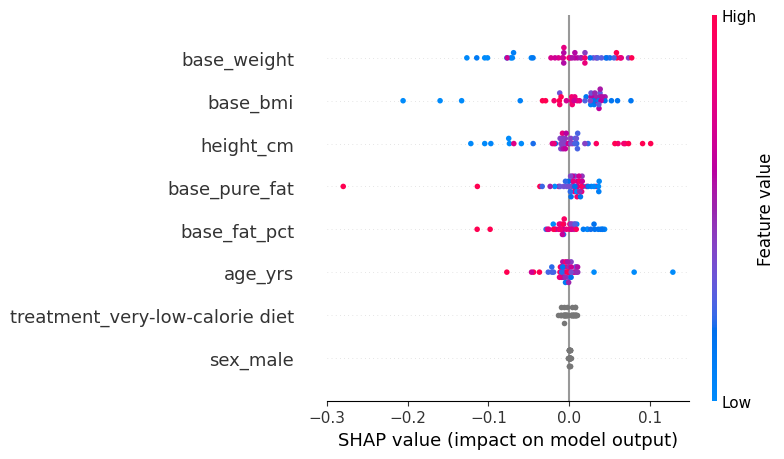

🧬 SHAP for: UCP2


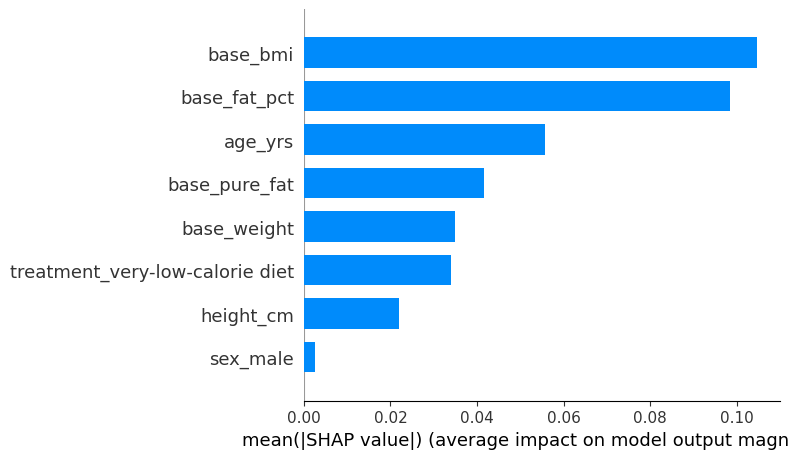

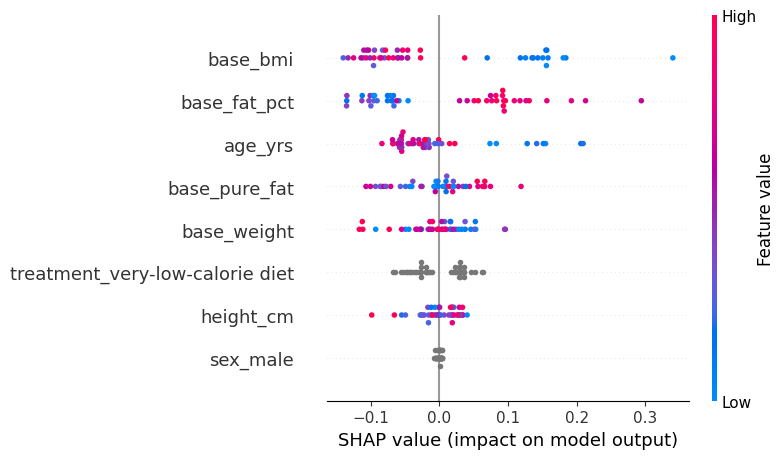

🧬 SHAP for: BDNF


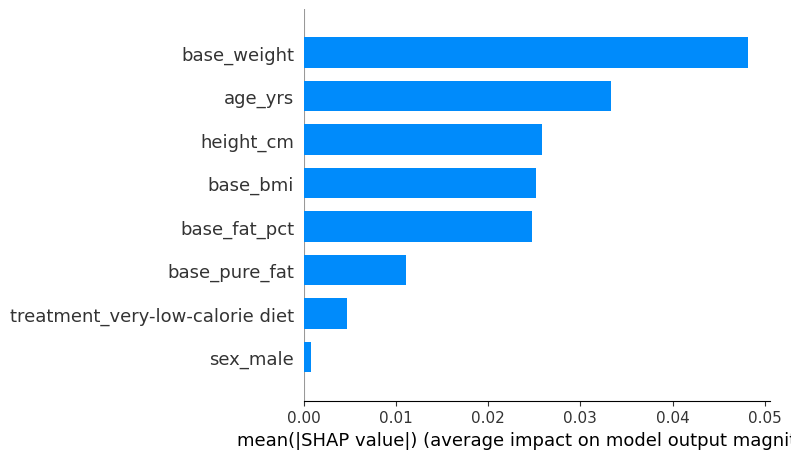

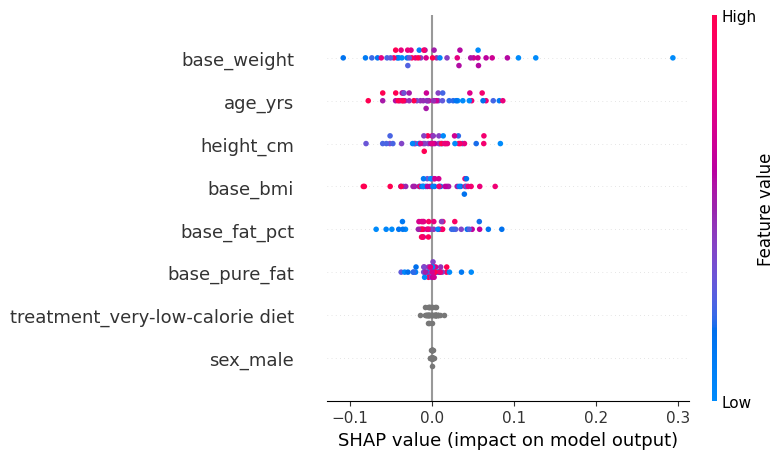

🧬 SHAP for: GNPDA2


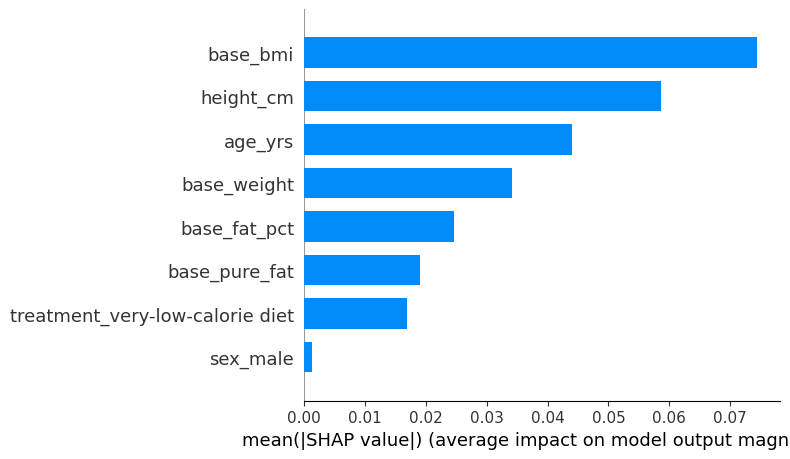

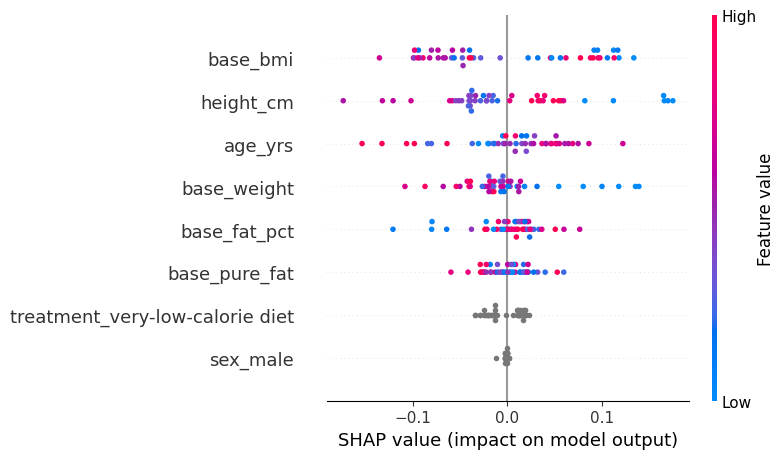

🧬 SHAP for: TMEM18


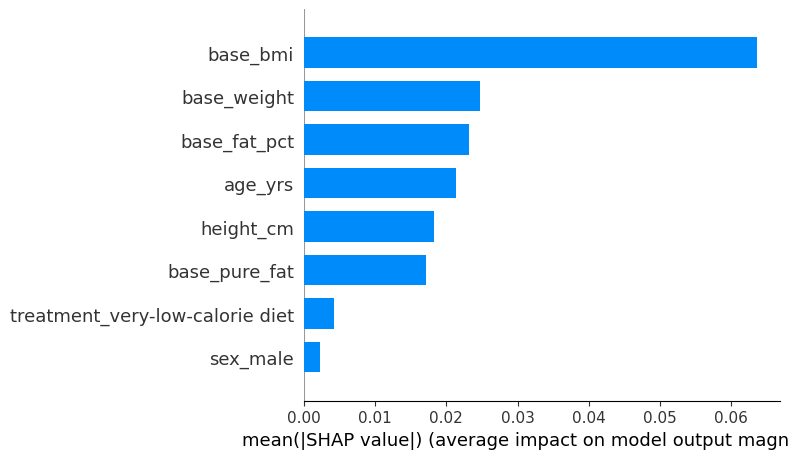

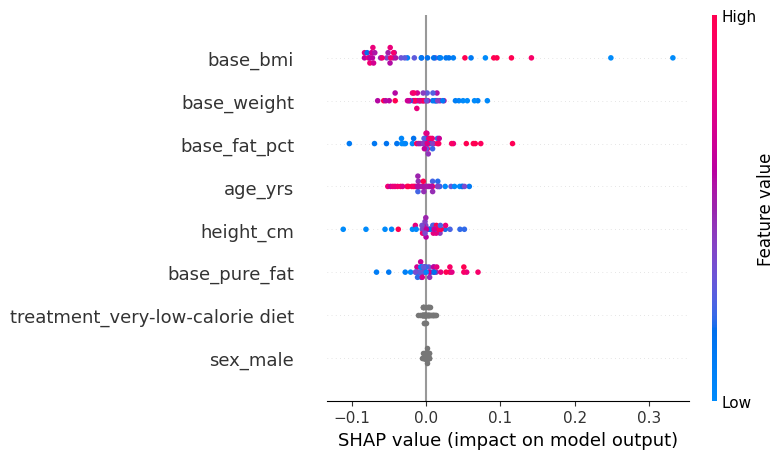

🧬 SHAP for: NEGR1


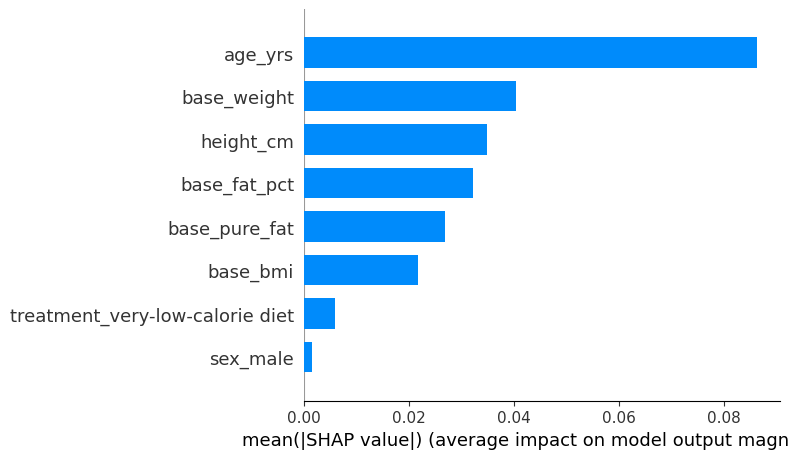

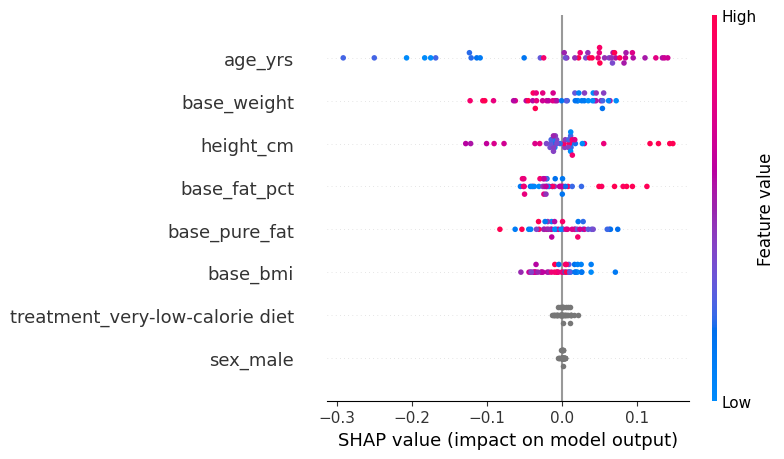

In [ ]:
obesity_genes = ['FTO', 'MC4R', 'LEP', 'LEPR', 'ADIPOQ', 'PPARG',
                 'UCP1', 'UCP2', 'BDNF', 'GNPDA2', 'TMEM18', 'NEGR1']

# 유전자별로 SHAP 시각화
for i, gene_name in enumerate(obesity_genes):  # 여기서 바로 유전자 이름 사용!
    print(f"🧬 SHAP for: {gene_name}")

    explainer = shap.TreeExplainer(model.estimators_[i])
    shap_values = explainer.shap_values(X_clean)

    # summary plot with gene name as title
    shap.summary_plot(shap_values, X_clean, plot_type="bar", show=True)
    shap.summary_plot(shap_values, X_clean, show=True)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


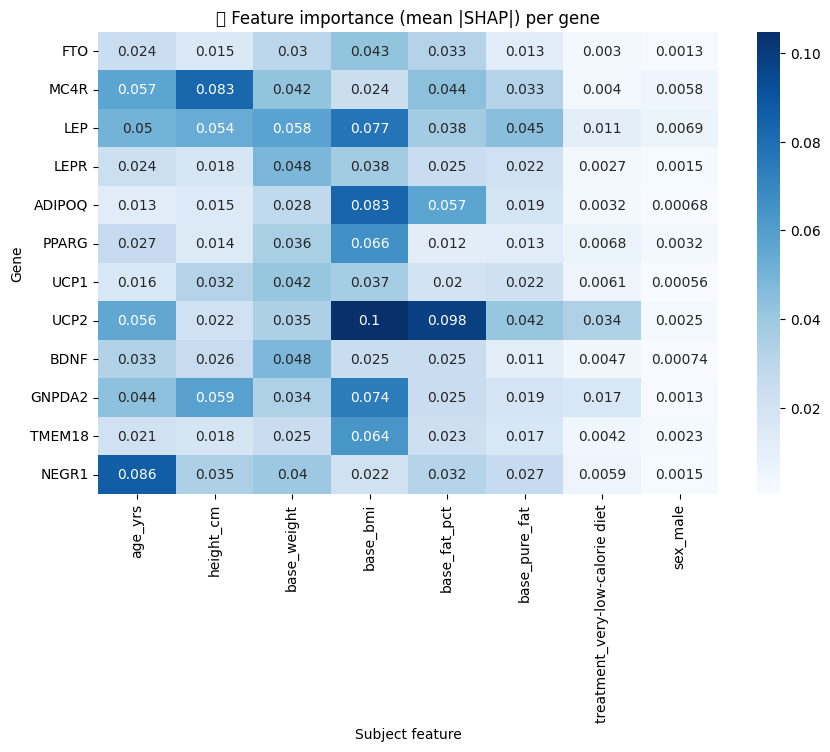

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

shap_matrix = pd.DataFrame(
    [np.abs(shap.TreeExplainer(model.estimators_[i]).shap_values(X_clean)).mean(axis=0)
     for i in range(12)],
    columns=X_clean.columns,
    index=obesity_genes  # 유전자 이름
)

plt.figure(figsize=(10, 6))
sns.heatmap(shap_matrix, cmap="Blues", annot=True)
plt.title("📊 Feature importance (mean |SHAP|) per gene")
plt.xlabel("Subject feature")
plt.ylabel("Gene")
plt.show()

# 유전자별 SHAP 벡터의 구조적 유사성 확인 및 시각화

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ 1. PCA (유전자 × feature → 2D)
pca = PCA(n_components=2)
gene_pca = pca.fit_transform(gene_feature_shap_df)  # or zscore_df

# ⚙️ 2. KMeans Clustering (군집 개수는 적절히 튜닝)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(gene_pca)

<ipython-input-28-1558302436>:15: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


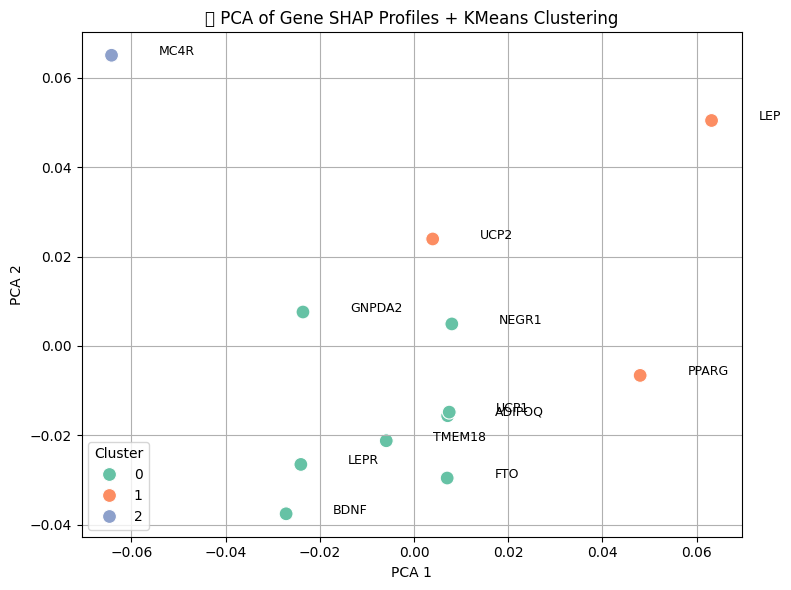

In [ ]:
# ⚙️ 3. 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(x=gene_pca[:, 0], y=gene_pca[:, 1],
                hue=clusters, palette="Set2", s=100)

# 유전자 이름 라벨링
for i, gene in enumerate(gene_feature_shap_df.index):
    plt.text(gene_pca[i, 0] + 0.01, gene_pca[i, 1], gene, fontsize=9)

plt.title("PCA of Gene SHAP Profiles + KMeans Clustering")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

### PCA분석
✅ 1. explained_variance_ratio_: 각 주성분이 전체 분산(정보)에서 차지하는 비율

✅ 2. components_: 각 PCA 주성분이 원래 feature들에 얼마나 영향을 받았는지 (= 각 feature의 가중치)

✅ 3. 각 클러스터의 대표 feature (군집 중심 → SHAP 값 기준)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
gene_pca = pca.fit_transform(gene_feature_shap_df)

# 얼마나 정보를 유지했는지 확인
print("📊 주성분 설명력:", pca.explained_variance_ratio_)
print("📊 누적 설명력:", pca.explained_variance_ratio_.sum())

📊 주성분 설명력: [0.36988601 0.33523066]
📊 누적 설명력: 0.7051166735714407


In [ ]:
# 각 주성분(PCA_1, PCA_2)이 어떤 feature로 구성됐는지 확인
pca_df = pd.DataFrame(pca.components_, columns=gene_feature_shap_df.columns, index=["PCA_1", "PCA_2"])

# 영향력 큰 feature 보기
print(pca_df.T.sort_values("PCA_1", ascending=False).head())  # PCA_1에 가장 큰 영향을 준 feature

                  PCA_1     PCA_2
height_cm      0.749427  0.375155
base_weight    0.250058  0.524431
sex_male       0.080077  0.133572
base_bmi      -0.069135  0.005873
base_pure_fat -0.152672  0.227487


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(gene_pca)

# 클러스터 번호를 gene_feature_shap_df에 추가
gene_clustered_df = gene_feature_shap_df.copy()
gene_clustered_df["cluster"] = clusters

# 각 클러스터별 평균 SHAP
cluster_feature_mean = gene_clustered_df.groupby("cluster").mean()

# 클러스터별 대표 feature 출력
for cluster_id, row in cluster_feature_mean.iterrows():
    top_features = row.sort_values(ascending=False).head(3)
    print(f"\n🧬 Cluster {cluster_id}의 대표 SHAP feature:")
    for feat, val in top_features.items():
        print(f"  - {feat}: {val:.4f}")


🧬 Cluster 0의 대표 SHAP feature:
  - base_bmi: 0.0385
  - age_yrs: 0.0338
  - height_cm: 0.0325

🧬 Cluster 1의 대표 SHAP feature:
  - height_cm: 0.0836
  - base_weight: 0.0572
  - base_bmi: 0.0347

🧬 Cluster 2의 대표 SHAP feature:
  - base_fat_pct: 0.1200
  - base_pure_fat: 0.0501
  - base_bmi: 0.0453


# 메타정보가 **결과 지표(체중, BMI, 체지방률, 순수 지방량)**에 어떤 영향을 미치는가?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
X = pd.read_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/subject_metadata.csv")  # (53, 8)

# 범주형 컬럼 자동 인코딩 (drop_first=True는 다중공선성 방지용)
X_encoded = pd.get_dummies(X, columns=['treatment', 'sex'], drop_first=True)

In [ ]:
# 1. bodycomp_tensor 불러오기
bodycomp_tensor = np.load("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/bodycomp_tensor.npy")  # (53, 4, 3)

# 2. C-A 시점 변화량을 타겟으로 설정
y = bodycomp_tensor[:, :, 2] - bodycomp_tensor[:, :, 0]  # (53, 4)

# 3. 타겟 이름 지정
target_names = ['weight_change', 'bmi_change', 'fat_pct_change', 'pure_fat_change']
y_df = pd.DataFrame(y, columns=target_names)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import shap

# 1. 합치기
df = pd.concat([X_encoded, y_df], axis=1)
df_clean = df.dropna()

# 2. 다시 분리
X_clean = df_clean[X_encoded.columns]
X_clean = X_clean.drop(columns=["subject_id"]) if "subject_id" in X_clean.columns else X_clean
y_clean = df_clean[y_df.columns]

# 3. 모델 학습
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(X_clean, y_clean)

# 4. SHAP 계산
body_shap_dict = {}
for i, label in enumerate(target_names):
    explainer = shap.TreeExplainer(model.estimators_[i])
    shap_values = explainer.shap_values(X_clean)
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    body_shap_dict[label] = mean_abs_shap

# 5. DataFrame 생성
body_feature_shap_df = pd.DataFrame(body_shap_dict, index=X_clean.columns).T

In [ ]:
X_clean.shape

(47, 8)

In [ ]:
y_clean.shape

(47, 4)

In [ ]:
body_feature_shap_df

age_yrs  height_cm  base_weight  base_bmi  base_fat_pct  \
weight_change    0.131664   0.211131     0.916616  0.296426      0.317395   
bmi_change       0.080430   0.069595     0.169453  0.088633      0.046689   
fat_pct_change   0.168328   0.163385     0.168700  0.327590      0.782277   
pure_fat_change  0.144903   0.201896     0.954594  0.436948      0.538897   

                 base_pure_fat  treatment_very-low-calorie diet  sex_male  
weight_change         0.345052                         0.228845  0.008492  
bmi_change            0.125185                         0.078229  0.003894  
fat_pct_change        0.593017                         0.020497  0.009214  
pure_fat_change       0.154510                         0.056223  0.010108

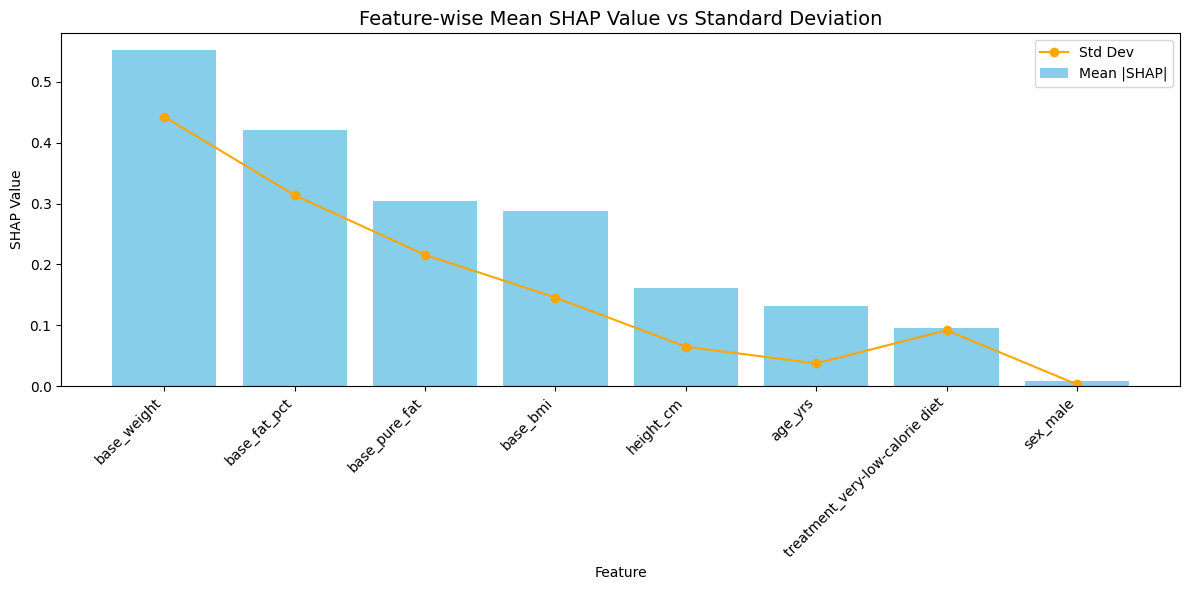

In [ ]:
import matplotlib.pyplot as plt

# 평균과 표준편차 계산
mean_importance = body_feature_shap_df.mean(axis=0)
std_importance = body_feature_shap_df.std(axis=0)

# 중요도 기준 정렬
sorted_features = mean_importance.sort_values(ascending=False).index
mean_sorted = mean_importance[sorted_features]
std_sorted = std_importance[sorted_features]

# 시각화
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.bar(sorted_features, mean_sorted, color='skyblue', label='Mean |SHAP|')
ax.plot(sorted_features, std_sorted, color='orange', marker='o', label='Std Dev')

plt.title("Feature-wise Mean SHAP Value vs Standard Deviation", fontsize=14)
plt.ylabel("SHAP Value")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import zscore
import pandas as pd

# z-score 계산 (axis=1: 각 결과지표 별로 민감한 feature)
z_array_1 = zscore(body_feature_shap_df, axis=1)
z_array_0 = zscore(body_feature_shap_df, axis=0)

# DataFrame으로 변환
body_shap_zscore_df_1 = pd.DataFrame(z_array_1, index=body_feature_shap_df.index, columns=body_feature_shap_df.columns)
body_shap_zscore_df_0 = pd.DataFrame(z_array_0, index=body_feature_shap_df.index, columns=body_feature_shap_df.columns)

In [ ]:
# 결과지표별로 가장 민감한 Feature
topk_metric_to_feature = {}
for label in body_shap_zscore_df_1.index:
    top_feats = body_shap_zscore_df_1.loc[label].sort_values(ascending=False).head(3)
    topk_metric_to_feature[label] = top_feats

print("🎯 결과지표별 Top-3 민감 Feature:")
for label, feats in topk_metric_to_feature.items():
    print(f"{label}: {list(feats.index)} (z: {feats.values.round(2)})")

🎯 결과지표별 Top-3 민감 Feature:
weight_change: ['base_weight', 'base_pure_fat', 'base_fat_pct'] (z: [2.42 0.15 0.04])
bmi_change: ['base_weight', 'base_pure_fat', 'base_bmi'] (z: [1.88 0.92 0.13])
fat_pct_change: ['base_fat_pct', 'base_pure_fat', 'base_bmi'] (z: [1.95 1.22 0.19])
pure_fat_change: ['base_weight', 'base_fat_pct', 'base_bmi'] (z: [2.17 0.77 0.42])


In [ ]:
# Feature별로 가장 민감한 결과지표
topk_feature_to_metric = {}
for feat in body_shap_zscore_df_0.columns:
    top_labels = body_shap_zscore_df_0[feat].sort_values(ascending=False).head(3)
    topk_feature_to_metric[feat] = top_labels

print("\n📊 Feature별 Top-3 민감 결과지표:")
for feat, labels in topk_feature_to_metric.items():
    print(f"{feat}: {list(labels.index)} (z: {labels.values.round(2)})")


📊 Feature별 Top-3 민감 결과지표:
age_yrs: ['fat_pct_change', 'pure_fat_change', 'weight_change'] (z: [1.15 0.42 0.01])
height_cm: ['weight_change', 'pure_fat_change', 'fat_pct_change'] (z: [0.89 0.72 0.03])
base_weight: ['pure_fat_change', 'weight_change', 'bmi_change'] (z: [ 1.05  0.95 -1.  ])
base_bmi: ['pure_fat_change', 'fat_pct_change', 'weight_change'] (z: [1.19 0.32 0.07])
base_fat_pct: ['fat_pct_change', 'pure_fat_change', 'weight_change'] (z: [ 1.33  0.43 -0.38])
base_pure_fat: ['fat_pct_change', 'weight_change', 'pure_fat_change'] (z: [ 1.55  0.22 -0.8 ])
treatment_very-low-calorie diet: ['weight_change', 'bmi_change', 'pure_fat_change'] (z: [ 1.67 -0.22 -0.5 ])
sex_male: ['pure_fat_change', 'fat_pct_change', 'weight_change'] (z: [0.91 0.54 0.24])


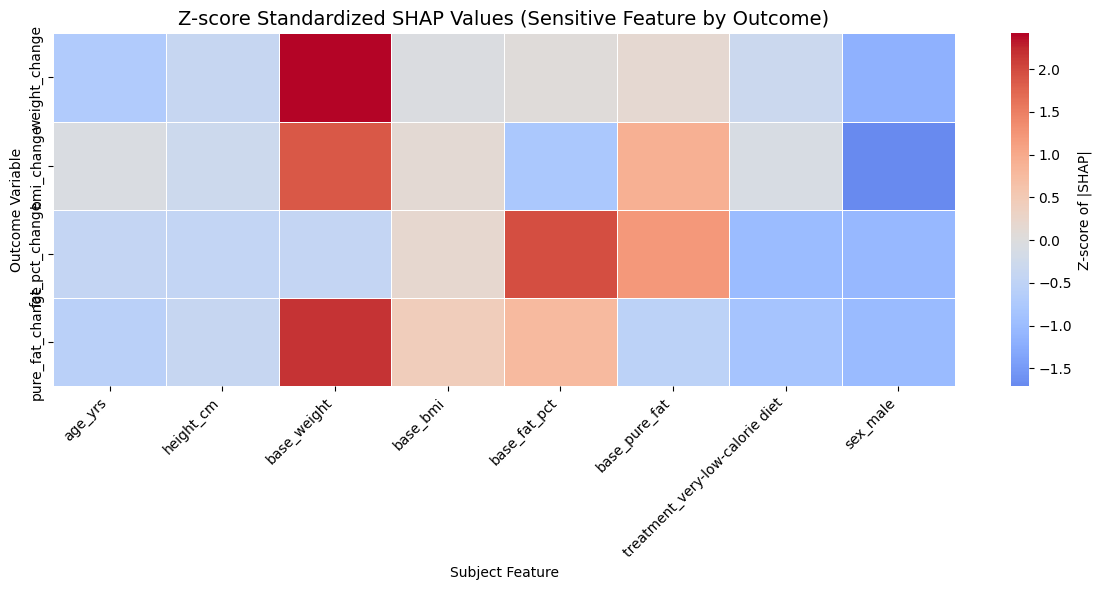

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(body_shap_zscore_df_1, cmap='coolwarm', center=0, annot=False, fmt=".2f",
            linewidths=0.5, cbar_kws={'label': 'Z-score of |SHAP|'})

plt.title("Z-score Standardized SHAP Values (Sensitive Feature by Outcome)", fontsize=14)
plt.xlabel("Subject Feature")
plt.ylabel("Outcome Variable")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

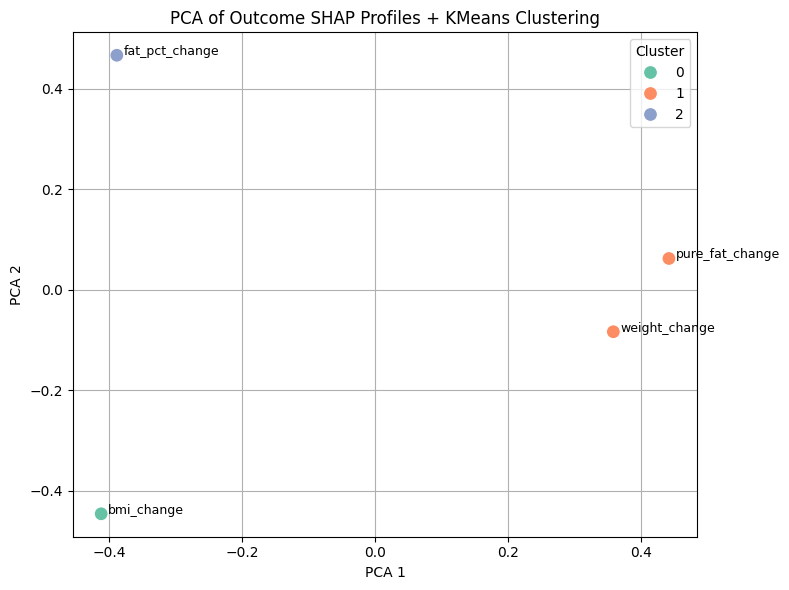

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# PCA (2D로 축소)
pca = PCA(n_components=2)
outcome_pca = pca.fit_transform(body_feature_shap_df)

# KMeans (3개 군집으로 가정)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(outcome_pca)

# 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(x=outcome_pca[:, 0], y=outcome_pca[:, 1],
                hue=clusters, palette="Set2", s=100)

# 결과지표 이름 라벨링
for i, label in enumerate(body_feature_shap_df.index):
    plt.text(outcome_pca[i, 0] + 0.01, outcome_pca[i, 1], label, fontsize=9)

plt.title("PCA of Outcome SHAP Profiles + KMeans Clustering")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

### 각 데이터 기본 정보 통계

In [ ]:
subject_metadata = pd.read_csv('/content/drive/MyDrive/BIO_MEDICAL_PROJECT/subject_metadata.csv')

In [ ]:
subject_metadata

treatment     sex  age_yrs  height_cm  base_weight  base_bmi  \
0   very-low-calorie diet  female     46.0      167.0        83.38     29.90   
1        low-calorie diet  female     40.0      172.0       100.01     33.81   
2        low-calorie diet    male     43.0      180.0        94.28     29.10   
3   very-low-calorie diet  female     51.0      165.0        85.04     31.24   
4        low-calorie diet  female     53.0      169.0       102.92     36.04   
5        low-calorie diet    male     63.0      185.5       119.63     34.77   
6                     NaN     NaN      NaN        NaN          NaN       NaN   
7   very-low-calorie diet  female     47.0      182.0        96.25     29.06   
8        low-calorie diet  female     67.0      155.5        86.03     35.58   
9   very-low-calorie diet  female     45.0      164.0        80.94     30.09   
10       low-calorie diet    male     60.0      169.5        94.98     33.06   
11  very-low-calorie diet  female     42.0      158.5        87.40     34.79   
12  very-low-calorie diet    male     48.0      186.0       107.12     30.96   
13       low-calorie diet    male     66.0      178.0        99.85     31.51   
14       low-calorie diet  female     58.0      168.5        91.06     32.07   
15  very-low-calorie diet    male     50.0      175.5        94.24     30.60   
16  very-low-calorie diet    male     65.0      188.5       114.08     32.10   
17  very-low-calorie diet  female     42.0      169.5        81.43     28.34   
18  very-low-calorie diet  female     43.0      163.5        79.23     29.64   
19  very-low-calorie diet    male     59.0      186.0        98.66     28.52   
20  very-low-calorie diet    male     52.0      178.5        99.62     31.27   
21  very-low-calorie diet    male     50.0      186.5       104.00     29.90   
22       low-calorie diet  female     50.0      164.0        90.06     33.48   
23       low-calorie diet    male     48.0      180.0        93.66     28.91   
24       low-calorie diet  female     50.0      159.0        72.87     28.82   
25       low-calorie diet  female     32.0      169.5        82.83     28.83   
26       low-calorie diet  female     53.0      170.0        79.31     27.44   
27  very-low-calorie diet  female     50.0      168.0        90.10     31.92   
28  very-low-calorie diet  female     60.0      169.5        96.72     33.66   
29       low-calorie diet  female     47.0      165.0        92.75     34.07   
30  very-low-calorie diet  female     41.0      154.0        80.34     33.88   
31  very-low-calorie diet  female     56.0      158.0        83.60     33.49   
32       low-calorie diet  female     56.0      162.5        76.21     28.86   
33  very-low-calorie diet    male     52.0      180.5        93.56     28.72   
34  very-low-calorie diet    male     61.0      182.5       105.43     31.65   
35  very-low-calorie diet  female     53.0      165.0        85.66     31.46   
36  very-low-calorie diet  female     43.0      173.5        98.10     32.59   
37  very-low-calorie diet  female     66.0      170.0        79.63     27.55   
38       low-calorie diet    male     41.0      181.0       105.07     32.07   
39       low-calorie diet    male     39.0      177.0        99.32     31.70   
40  very-low-calorie diet    male     56.0      179.0        96.67     30.17   
41       low-calorie diet  female     62.0      174.5       101.96     33.48   
42       low-calorie diet    male     65.0      176.0        94.28     30.44   
43  very-low-calorie diet    male     45.0      179.0        91.85     28.67   
44       low-calorie diet    male     34.0      184.0        94.09     27.79   
45                    NaN     NaN      NaN        NaN          NaN       NaN   
46  very-low-calorie diet    male     35.0      165.0        86.70     31.85   
47       low-calorie diet    male     56.0      171.0        93.36     31.93   
48       low-calorie diet    male     67.0      168.5        82.42     29.03   
49       low-cal

In [ ]:
# 각 열마다 통계값 계산 (결측치 제외)
stats_df = X.describe(include='all').T[['mean', 'std', 'min', '50%', 'max']]
stats_df.rename(columns={'50%': 'median'}, inplace=True)

# 결과 확인
print(stats_df)

                    mean       std       min    median     max
treatment            NaN       NaN       NaN       NaN     NaN
sex                  NaN       NaN       NaN       NaN     NaN
age_yrs        51.509804  9.176868      32.0      51.0    67.0
height_cm      171.95098   8.95112     154.0     170.0   188.5
base_weight     92.13451  9.897396     72.87     93.56  119.63
base_bmi           31.15  2.267251     27.44     31.27   36.04
base_fat_pct   40.257143  8.670232      22.4      42.5    55.7
base_pure_fat  36.623102  7.922459  21.07616  35.71696  53.658


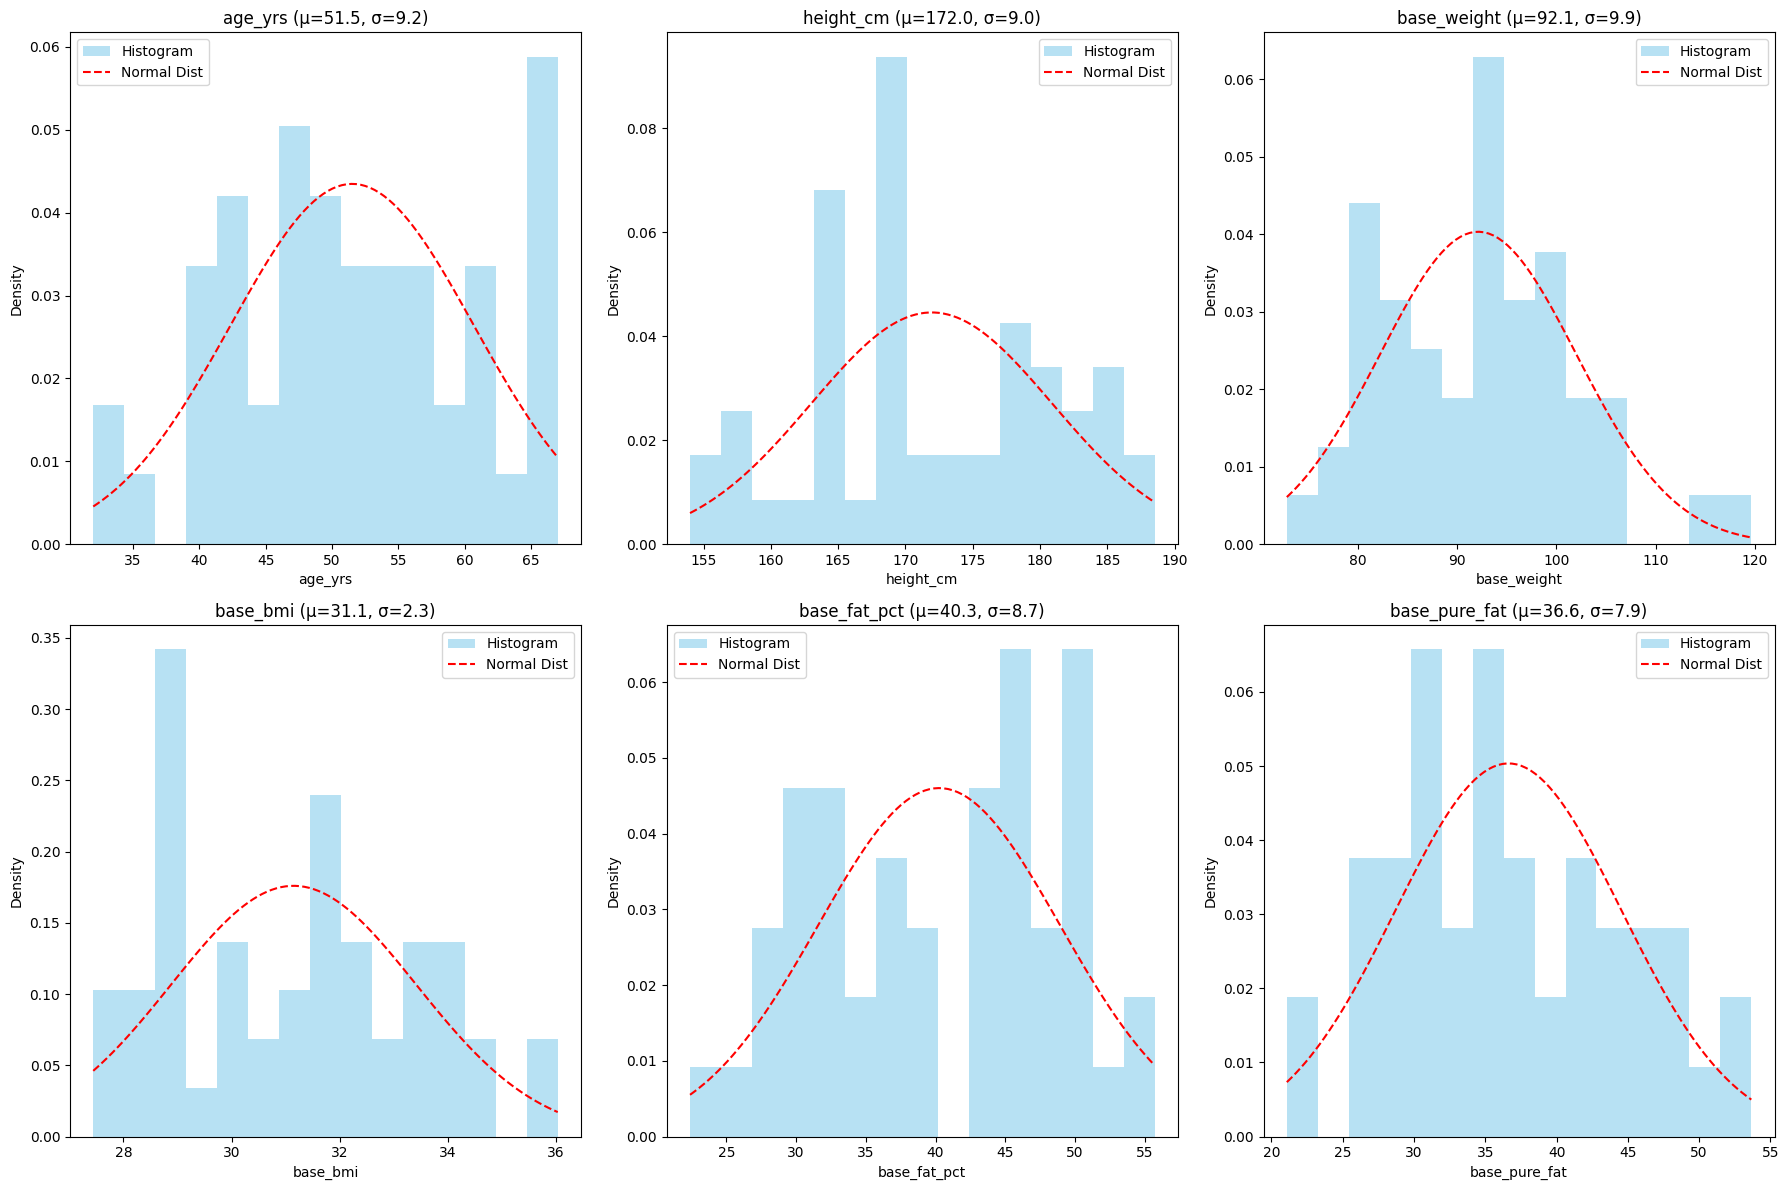

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# 예시 데이터프레임: df_meta는 너가 올린 메타정보가 담긴 df
# df_meta = pd.read_csv(...) 등으로 이미 로드되어 있다고 가정

# 시각화할 열 목록
columns = ["age_yrs", "height_cm", "base_weight", "base_bmi", "base_fat_pct", "base_pure_fat"]

# 그래프 설정
plt.figure(figsize=(18, 12))
for i, col in enumerate(columns, 1):
    plt.subplot(2, 3, i)

    # 결측치 제거
    data = subject_metadata[col].dropna()

    # 평균, 표준편차 계산
    mu, std = data.mean(), data.std()

    # 정규분포 곡선 그리기 위한 범위
    x = np.linspace(data.min(), data.max(), 100)
    y = norm.pdf(x, mu, std)

    # 히스토그램 & 정규분포
    plt.hist(data, bins=15, density=True, alpha=0.6, color='skyblue', label='Histogram')
    plt.plot(x, y, 'r--', label='Normal Dist')

    plt.title(f"{col} (μ={mu:.1f}, σ={std:.1f})")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()

plt.tight_layout()
plt.show()

# 결과지표 감소가 큰 유전자 추리기

In [ ]:
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

gene_expr=pd.read_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/gene_expr.csv")
gene_tensor = np.load("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/gene_expression_tensor.npy")
body_tensor = np.load("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/bodycomp_tensor.npy")

In [ ]:
# 1. 입력 (X), 타겟 (y)
X = gene_tensor[:, :, 2] - gene_tensor[:, :, 0]  # shape (53, 30000)
y = body_tensor[:, :, 2] - body_tensor[:, :, 0]  # 순수 지방량 변화 (shape: 53,)

# 2. 결측치 제거
valid_mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y).any(axis=1)
X = X[valid_mask]
y = y[valid_mask]

from sklearn.multioutput import MultiOutputRegressor
import shap

# 모델 훈련 (여기서 X: DataFrame, y: DataFrame or ndarray with shape (n_samples, 4))
base_model = xgb.XGBRegressor(n_estimators=100, max_depth=4, random_state=42)
model = MultiOutputRegressor(base_model)
model.fit(X, y)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))

In [ ]:
genes = sorted(gene_expr['gene_symbol'].unique())

In [ ]:
# SHAP 결과 저장용 리스트
shap_all = []

# 타겟 이름 지정
target_names = ['fat_mass', 'fat_pct', 'bmi', 'weight']

# 4개의 타겟 각각에 대해 SHAP 계산
for i, name in enumerate(target_names):
    # 각 타겟별 모델 추출
    sub_model = model.estimators_[i]

    # SHAP explainer 생성
    explainer = shap.Explainer(sub_model, X)
    shap_values = explainer(X)

    # 평균 SHAP 계산
    mean_shap = np.abs(shap_values.values).mean(axis=0)  # shape: (n_features,)
    shap_all.append(mean_shap)

# 4개 타겟별 평균 SHAP을 하나의 DataFrame으로 결합
shap_df = pd.DataFrame(np.array(shap_all).T, columns=[f"SHAP_{name}" for name in target_names])
shap_df['Gene'] = genes
shap_df = shap_df[['Gene'] + [f"SHAP_{name}" for name in target_names]]

In [ ]:
X.shape

(47, 20074)

In [ ]:
y.shape

(47, 4)

In [ ]:
print(type(X))

<class 'numpy.ndarray'>


In [ ]:
shap_df.to_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/multi_shap_df.csv")

In [ ]:
shap_df

Gene  SHAP_fat_mass  SHAP_fat_pct  SHAP_bmi  SHAP_weight
0           A1BG       0.046572      0.013271  0.017219     0.033393
1           A1CF       0.009782      0.010227  0.029263     0.041264
2          A2LD1       0.016421      0.008189  0.028805     0.031332
3            A2M       0.005397      0.013745  0.011292     0.026048
4          A2ML1       0.007648      0.000000  0.003713     0.001520
...          ...            ...           ...       ...          ...
20069        ZYX       0.000000      0.000000  0.000000     0.000000
20070      ZZEF1       0.000000      0.000000  0.000000     0.000000
20071       ZZZ3       0.000000      0.000000  0.000000     0.000000
20072  psiTPTE22       0.000000      0.000000  0.000000     0.000000
20073       tAKR       0.000000      0.000000  0.000000     0.000000

[20074 rows x 5 columns]

In [ ]:
# 타겟별 컬럼 지정
target_columns = ['SHAP_fat_mass', 'SHAP_fat_pct', 'SHAP_bmi', 'SHAP_weight']

# 각 타겟별로 SHAP > 0인 유전자 수와 비율 계산
for col in target_columns:
    nonzero_df = shap_df[shap_df[col] > 0]
    num_nonzero = nonzero_df.shape[0]
    total_genes = shap_df.shape[0]
    ratio = num_nonzero / total_genes
    print(f"✅ [{col}] SHAP > 0인 유전자 수: {num_nonzero}")
    print(f"📊 비율: {ratio:.4%}\n")

✅ [SHAP_fat_mass] SHAP > 0인 유전자 수: 148
📊 비율: 0.7373%

✅ [SHAP_fat_pct] SHAP > 0인 유전자 수: 130
📊 비율: 0.6476%

✅ [SHAP_bmi] SHAP > 0인 유전자 수: 137
📊 비율: 0.6825%

✅ [SHAP_weight] SHAP > 0인 유전자 수: 151
📊 비율: 0.7522%



In [ ]:
# 비만 관련 유전자 목록
obesity_genes = ['FTO', 'MC4R', 'LEP', 'LEPR', 'ADIPOQ', 'PPARG',
                 'UCP1', 'UCP2', 'BDNF', 'GNPDA2', 'TMEM18', 'NEGR1']

# 해당 유전자 필터링
shap_obesity_rank = shap_df[shap_df['Gene'].isin(obesity_genes)]

# 전체 정렬 출력
print(shap_obesity_rank.sort_values(by='Gene'))  # 또는 원하는 SHAP 열 기준 정렬

         Gene  SHAP_fat_mass  SHAP_fat_pct  SHAP_bmi  SHAP_weight
324    ADIPOQ            0.0           0.0       0.0          0.0
1436     BDNF            0.0           0.0       0.0          0.0
6600      FTO            0.0           0.0       0.0          0.0
7066   GNPDA2            0.0           0.0       0.0          0.0
9288      LEP            0.0           0.0       0.0          0.0
9289     LEPR            0.0           0.0       0.0          0.0
10364    MC4R            0.0           0.0       0.0          0.0
11611   NEGR1            0.0           0.0       0.0          0.0
13646   PPARG            0.0           0.0       0.0          0.0
17811  TMEM18            0.0           0.0       0.0          0.0
18682    UCP1            0.0           0.0       0.0          0.0
18683    UCP2            0.0           0.0       0.0          0.0


In [ ]:
print(shap_df[target_columns].describe())

       SHAP_fat_mass  SHAP_fat_pct      SHAP_bmi   SHAP_weight
count   20074.000000  20074.000000  20074.000000  20074.000000
mean        0.000211      0.000066      0.000202      0.000218
std         0.006888      0.002046      0.012585      0.006343
min         0.000000      0.000000      0.000000      0.000000
25%         0.000000      0.000000      0.000000      0.000000
50%         0.000000      0.000000      0.000000      0.000000
75%         0.000000      0.000000      0.000000      0.000000
max         0.559918      0.156273      1.596946      0.463440


In [ ]:
shap_df_sorted = shap_df.sort_values(by='SHAP_fat_mass', ascending=False).reset_index(drop=True)

In [ ]:
shap_df_sorted.to_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/shap_df_sorted.csv")

In [ ]:
shap_weight_genes = shap_df[shap_df['SHAP_weight'] > 0]\
    .sort_values(by='SHAP_weight', ascending=False)['Gene'].tolist()
shap_bmi_genes = shap_df[shap_df['SHAP_bmi'] > 0]\
    .sort_values(by='SHAP_bmi', ascending=False)['Gene'].tolist()

shap_fat_pct_genes = shap_df[shap_df['SHAP_fat_pct'] > 0]\
    .sort_values(by='SHAP_fat_pct', ascending=False)['Gene'].tolist()

shap_fat_mass_genes = shap_df[shap_df['SHAP_fat_mass'] > 0]\
    .sort_values(by='SHAP_fat_mass', ascending=False)['Gene'].tolist()

In [ ]:
len(shap_fat_mass_genes)

148

In [ ]:
shap_weight_genes[:10]

['BTN2A1',
 'PTPRD',
 'HNRNPA1P10',
 'CDCA5',
 'C8orf80',
 'RGP1',
 'ANP32B',
 'RGS11',
 'CBY1',
 'OR6N2']

In [ ]:
shap_bmi_genes[:10]

['ORMDL3',
 'PPP2R1A',
 'C20orf46',
 'CSRNP3',
 'COL8A1',
 'GADD45G',
 'THPO',
 'TMEM115',
 'AMOTL1',
 'NUBP2']

In [ ]:
shap_fat_pct_genes[:10]

['BTN2A1',
 'ARPP21',
 'C11orf68',
 'ADPRHL1',
 'HELLS',
 'FBLN5',
 'KCNAB1',
 'C12orf32',
 'APOBEC3C',
 'ZCCHC2']

In [ ]:
shap_fat_mass_genes[:10]

['HELLS',
 'ZNF100',
 'BTN2A1',
 'CCDC13',
 'DR1',
 'TRMT5',
 'GRIA3',
 'BCAP31',
 'ZNF257',
 'C20orf71']

In [ ]:
# 4개 SHAP 양수 유전자 리스트 교집합
common_genes = list(
    set(shap_weight_genes) &
    set(shap_bmi_genes) &
    set(shap_fat_pct_genes) &
    set(shap_fat_mass_genes)
)

# 결과 확인
print(f"✅ 모든 지표에서 SHAP > 0인 유전자 수: {len(common_genes)}")
print(common_genes)

✅ 모든 지표에서 SHAP > 0인 유전자 수: 6
['A1BG', 'AANAT', 'A4GALT', 'A1CF', 'A2LD1', 'A2M']


In [ ]:
all_genes = list(
    set(shap_weight_genes) |
    set(shap_bmi_genes) |
    set(shap_fat_pct_genes) |
    set(shap_fat_mass_genes)
)

# 결과 확인
print(f"✅ 모든 지표에서 SHAP > 0인 유전자 수: {len(all_genes)}")
print(all_genes)

✅ 모든 지표에서 SHAP > 0인 유전자 수: 490
['IMP3', 'ABCA13', 'ZNF530', 'COQ7', 'ACO2', 'C3orf18', 'HHIP', 'IER2', 'MUC20', 'SLC6A8', 'A4GALT', 'CCDC13', 'ABCB10', 'RND1', 'PEX7', 'LILRA5', 'ANXA9', 'C8orf80', 'HIST1H4C', 'IL28A', 'ADRA1A', 'RAB5B', 'IL1F5', 'AASDH', 'OGN', 'EPDR1', 'DDX41', 'ACSM3', 'AACS', 'NAPSB', 'ABHD12', 'TXLNG', 'C16orf55', 'AP4M1', 'CRISP1', 'MYLIP', 'ATP1A3', 'C10orf55', 'AK2', 'AKNAD1', 'ACCN1', 'ACBD7', 'ZCCHC2', 'ALG3', 'SNORA67', 'GAPDHS', 'ZNF69', 'ZADH2', 'ABCB9', 'ARHGAP26', 'CTXN1', 'DDX24', 'C1orf100', 'PRAMEF11', 'ANKRD52', 'STOML1', 'NCRNA00208', 'BRMS1L', 'CDK4', 'ABCG4', 'ADAMTS10', 'C9orf141', 'MIR146A', 'AGAP5', 'FNDC5', 'SHISA2', 'TMEM182', 'IL4I1', 'USH1C', 'AGPHD1', 'MYH4', 'ABCA7', 'FLJ40453', 'PSMD11', 'HAO1', 'MYEOV2', 'TRIP4', 'FAM129A', 'AAK1', 'CDCA5', 'ANKRD42', 'GLP1R', 'RAB6B', 'ALPP', 'AARS2', 'DAOA', 'NPLOC4', 'KCNS1', 'A2ML1', 'AADACL4', 'GPRC6A', 'ABCD1', 'PPP2R1A', 'DAZAP1', 'C4orf46', 'AKAP8', 'ADCK2', 'C2orf84', 'DOK7', 'ELL', 'ARHGAP22',

In [ ]:
shap_df_sorted

Gene  SHAP_fat_mass  SHAP_fat_pct  SHAP_bmi  SHAP_weight
0       HELLS       0.559918      0.062189    0.0016     0.000000
1      ZNF100       0.477549      0.000000    0.0000     0.000000
2      BTN2A1       0.342814      0.156273    0.0000     0.463440
3      CCDC13       0.233836      0.000000    0.0000     0.000000
4         DR1       0.205127      0.000000    0.0000     0.000000
...       ...            ...           ...       ...          ...
20069  GAPVD1       0.000000      0.000000    0.0000     0.000000
20070    GAPT       0.000000      0.000000    0.0000     0.000000
20071  GAPDHS       0.000000      0.000000    0.0000     0.002778
20072   GAPDH       0.000000      0.000000    0.0000     0.000000
20073    GAS2       0.000000      0.000000    0.0000     0.000000

[20074 rows x 5 columns]

# **SHAP 유전자 필터링 + Optuna 튜닝 + 교차검증**

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 19.2 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, r2_score
import numpy as np
import pandas as pd

# 1. SHAP 높은 유전자만 필터링
selected_genes = shap_df[shap_df['SHAP_fat_mass'] > 0]\
    .sort_values(by='SHAP_fat_mass', ascending=False)['Gene'].tolist()

X_filtered = pd.DataFrame(X, columns=genes)[selected_genes]  # X는 (n_samples, 30000) / genes는 전체 유전자명 리스트

In [ ]:
X_filtered.shape

(47, 148)

In [ ]:
# 2. Optuna 튜닝
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 400),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0)
    }

    base_model = XGBRegressor(**params, random_state=42)
    model = MultiOutputRegressor(base_model)

    # ⚠️ 여기서 교차검증으로 모델 평가 (fit 전에!)
    score = cross_val_score(model, X_filtered, y, cv=3, scoring="r2").mean()
    return score

# 3. 최적화 실행
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2025-06-14 10:52:26,849] A new study created in memory with name: no-name-a077dbbb-15a6-4295-9b18-fe8239b7bf91
[I 2025-06-14 10:52:49,904] Trial 0 finished with value: 0.30409378198760956 and parameters: {'n_estimators': 140, 'max_depth': 6, 'learning_rate': 0.13380791282111335, 'subsample': 0.6312770992115407, 'colsample_bytree': 0.9470885752886788}. Best is trial 0 with value: 0.30409378198760956.
[I 2025-06-14 10:52:58,301] Trial 1 finished with value: 0.30395203029667656 and parameters: {'n_estimators': 283, 'max_depth': 5, 'learning_rate': 0.07526830365117564, 'subsample': 0.7480791956593174, 'colsample_bytree': 0.8423655115966114}. Best is trial 0 with value: 0.30409378198760956.
[I 2025-06-14 10:53:03,452] Trial 2 finished with value: 0.2537067199954735 and parameters: {'n_estimators': 381, 'max_depth': 4, 'learning_rate': 0.09982474462585966, 'subsample': 0.9190812233586856, 'colsample_bytree': 0.9150761627808381}. Best is trial 0 with value: 0.30409378198760956.
[I 2025-06-

In [ ]:
# 4. 최적 파라미터 확인
print("✅ Best params:", study.best_params)

✅ Best params: {'n_estimators': 103, 'max_depth': 8, 'learning_rate': 0.19496324256435815, 'subsample': 0.6078637761697006, 'colsample_bytree': 0.7491690860158734}


In [ ]:
from sklearn.metrics import r2_score

y_true = [3, 5, 4, 7]
y_pred = [2.8, 5.1, 4.2, 6.9]

r2 = r2_score(y_true, y_pred)
print("R² score:", r2)

R² score: 0.9885714285714285


### 1안 vs 2안-> 새롭게

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import optuna
import pandas as pd

# 1. 데이터셋 준비
# X: shape (47, 30000), y: shape (47, 4), genes: 유전자 이름 30000개 리스트

# ▶ 실험 A: SHAP_fat_mass 기준 상위 유전자 148개
selected_genes_1 = shap_df[shap_df['SHAP_fat_mass'] > 0]\
    .sort_values(by='SHAP_fat_mass', ascending=False)['Gene'].tolist()

X_filtered_1 = pd.DataFrame(X, columns=genes)[selected_genes_1]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_filtered_1, y, test_size=0.2, random_state=42)

# ▶ 실험 B: 모든 SHAP > 0 유전자 교집합 490개
selected_genes_2 = list(
    set(shap_weight_genes) & set(shap_bmi_genes) &
    set(shap_fat_pct_genes) & set(shap_fat_mass_genes)
)
X_filtered_2 = pd.DataFrame(X, columns=genes)[selected_genes_2]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_filtered_2, y, test_size=0.2, random_state=42)

In [ ]:
# ▶ 실험 B: 모든 SHAP > 0 유전자 교집합 490개
selected_genes_2 = list(
    set(shap_weight_genes) | set(shap_bmi_genes) |
    set(shap_fat_pct_genes) | set(shap_fat_mass_genes)
)
X_filtered_2 = pd.DataFrame(X, columns=genes)[selected_genes_2]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_filtered_2, y, test_size=0.2, random_state=42)

In [ ]:
# 2. Optuna 튜닝 함수
def optimize_model(X_train, y_train):
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 400),
            "max_depth": trial.suggest_int("max_depth", 3, 8),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0)
        }
        base_model = XGBRegressor(**params, random_state=42)
        model = MultiOutputRegressor(base_model)
        score = cross_val_score(model, X_train, y_train, cv=3, scoring="r2").mean()
        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30)
    return study.best_params

In [ ]:
# 3. A 모델 학습 및 평가
params_1 = optimize_model(X_train1, y_train1)
model_1 = MultiOutputRegressor(XGBRegressor(**params_1, random_state=42))
model_1.fit(X_train1, y_train1)
y_pred1 = model_1.predict(X_test1)
r2_1 = r2_score(y_test1, y_pred1)

[I 2025-06-14 11:48:58,233] A new study created in memory with name: no-name-7f23bde4-7b82-4bbb-9082-f11d76b7c557
[I 2025-06-14 11:49:16,922] Trial 0 finished with value: 0.13206083276250566 and parameters: {'n_estimators': 397, 'max_depth': 8, 'learning_rate': 0.03955273148941897, 'subsample': 0.9786578700213597, 'colsample_bytree': 0.8902112837514986}. Best is trial 0 with value: 0.13206083276250566.
[I 2025-06-14 11:49:21,607] Trial 1 finished with value: 0.1564216450751502 and parameters: {'n_estimators': 332, 'max_depth': 3, 'learning_rate': 0.07481025082031736, 'subsample': 0.9634085501713483, 'colsample_bytree': 0.9899024957305325}. Best is trial 1 with value: 0.1564216450751502.
[I 2025-06-14 11:49:29,388] Trial 2 finished with value: 0.38739760338130275 and parameters: {'n_estimators': 248, 'max_depth': 6, 'learning_rate': 0.0463727531794919, 'subsample': 0.6631229772912468, 'colsample_bytree': 0.9290829508411687}. Best is trial 2 with value: 0.38739760338130275.
[I 2025-06-14

In [ ]:
# 4. B 모델 학습 및 평가
params_2 = optimize_model(X_train2, y_train2)
model_2 = MultiOutputRegressor(XGBRegressor(**params_2, random_state=42))
model_2.fit(X_train2, y_train2)
y_pred2 = model_2.predict(X_test2)
r2_2 = r2_score(y_test2, y_pred2)

[I 2025-06-14 11:53:20,285] A new study created in memory with name: no-name-fb89ea0a-9ece-4ea6-a273-ebf77b59c18c
[I 2025-06-14 11:53:34,936] Trial 0 finished with value: 0.33620792936359395 and parameters: {'n_estimators': 217, 'max_depth': 5, 'learning_rate': 0.025383333748562942, 'subsample': 0.6593564394906789, 'colsample_bytree': 0.8650130706140933}. Best is trial 0 with value: 0.33620792936359395.
[I 2025-06-14 11:53:49,669] Trial 1 finished with value: 0.2711455090279125 and parameters: {'n_estimators': 237, 'max_depth': 5, 'learning_rate': 0.017131578418022233, 'subsample': 0.7927927462642119, 'colsample_bytree': 0.7028642713591546}. Best is trial 0 with value: 0.33620792936359395.
[I 2025-06-14 11:53:59,683] Trial 2 finished with value: 0.16205911896294148 and parameters: {'n_estimators': 113, 'max_depth': 5, 'learning_rate': 0.1270869519578652, 'subsample': 0.9402943141146394, 'colsample_bytree': 0.7719408970899306}. Best is trial 0 with value: 0.33620792936359395.
[I 2025-06

In [ ]:
# 5. 결과 출력
print("✅ A안 (fat_mass 기준 상위 유전자, 개수:", len(selected_genes_1), ") R²:", r2_1)
print("✅ B안 (4개 SHAP 교집합 유전자, 개수:", len(selected_genes_2), ") R²:", r2_2)

✅ A안 (fat_mass 기준 상위 유전자, 개수: 148 ) R²: 0.2972445633164131
✅ B안 (4개 SHAP 교집합 유전자, 개수: 490 ) R²: 0.32601372544203827


In [ ]:
print("Model1 Best Parameters:", params_1)
print("Model2 Best Parameters:", params_2)

Model1 Best Parameters: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.09192640621676107, 'subsample': 0.6270860574659226, 'colsample_bytree': 0.9071239112846141}
Model2 Best Parameters: {'n_estimators': 346, 'max_depth': 8, 'learning_rate': 0.028294859818494805, 'subsample': 0.6564030607956486, 'colsample_bytree': 0.8456598138838493}


# model_2 기준으로 SHAP 재계산

In [ ]:
# 타겟 이름
target_names = ['fat_mass', 'fat_pct', 'bmi', 'weight']

# SHAP 결과 저장 리스트
shap_all = []

# 🔁 model_2 기준으로 SHAP 계산
for i, name in enumerate(target_names):
    sub_model = model_2.estimators_[i]  # model_2 사용
    explainer = shap.Explainer(sub_model, X_train2)  # X2는 model_2 학습에 사용한 입력
    shap_values = explainer(X_train2)
    mean_shap = np.abs(shap_values.values).mean(axis=0)
    shap_all.append(mean_shap)

# DataFrame으로 결합
shap_df = pd.DataFrame(np.array(shap_all).T, columns=[f"SHAP_{name}" for name in target_names])
shap_df['Gene'] = X_train2.columns  # X2의 컬럼명이 유전자명
shap_df = shap_df[['Gene'] + [f"SHAP_{name}" for name in target_names]]

# 교집합 유전자: 4개 지표 모두 SHAP > 0
common_genes = list(
    set(shap_df[shap_df['SHAP_fat_mass'] > 0]['Gene']) &
    set(shap_df[shap_df['SHAP_fat_pct'] > 0]['Gene']) &
    set(shap_df[shap_df['SHAP_bmi'] > 0]['Gene']) &
    set(shap_df[shap_df['SHAP_weight'] > 0]['Gene'])
)

# 합집합 유전자: 4개 지표 중 하나라도 SHAP > 0
all_genes = list(
    set(shap_df[shap_df['SHAP_fat_mass'] > 0]['Gene']) |
    set(shap_df[shap_df['SHAP_fat_pct'] > 0]['Gene']) |
    set(shap_df[shap_df['SHAP_bmi'] > 0]['Gene']) |
    set(shap_df[shap_df['SHAP_weight'] > 0]['Gene'])
)

In [ ]:
# 결과 출력
print(f"🔁 교집합 유전자 수: {len(common_genes)}")
print(f"✅ 합집합 유전자 수: {len(all_genes)}")

# SHAP DataFrame 확인 (선택)
display(shap_df.head())

🔁 교집합 유전자 수: 138
✅ 합집합 유전자 수: 475


Gene  SHAP_fat_mass  SHAP_fat_pct  SHAP_bmi  SHAP_weight
0    IMP3       0.115690      0.030057  0.081708     0.056422
1  ABCA13       0.028906      0.008492  0.064059     0.016020
2  ZNF530       0.033554      0.005678  0.021947     0.013647
3    COQ7       0.041904      0.028367  0.018270     0.013629
4    ACO2       0.028415      0.002236  0.011134     0.017808

In [ ]:
shap_df

Gene  SHAP_fat_mass  SHAP_fat_pct  SHAP_bmi  SHAP_weight
0      IMP3       0.115690      0.030057  0.081708     0.056422
1    ABCA13       0.028906      0.008492  0.064059     0.016020
2    ZNF530       0.033554      0.005678  0.021947     0.013647
3      COQ7       0.041904      0.028367  0.018270     0.013629
4      ACO2       0.028415      0.002236  0.011134     0.017808
..      ...            ...           ...       ...          ...
485    FDXR       0.000028      0.000144  0.000000     0.002733
486   MEP1B       0.000000      0.000039  0.000000     0.000000
487   CASP7       0.000000      0.000000  0.001086     0.001492
488   ABCB8       0.000435      0.000506  0.000000     0.000000
489  ABCC11       0.000000      0.000000  0.000000     0.000415

[490 rows x 5 columns]

In [ ]:
model_1_shap_df=pd.read_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/shap_df_sorted.csv")

In [ ]:
model_1_shap_df

Unnamed: 0    Gene  SHAP_fat_mass  SHAP_fat_pct  SHAP_bmi  SHAP_weight
0               0   HELLS       0.559918      0.062189    0.0016     0.000000
1               1  ZNF100       0.477549      0.000000    0.0000     0.000000
2               2  BTN2A1       0.342814      0.156273    0.0000     0.463440
3               3  CCDC13       0.233836      0.000000    0.0000     0.000000
4               4     DR1       0.205127      0.000000    0.0000     0.000000
...           ...     ...            ...           ...       ...          ...
20069       20069  GAPVD1       0.000000      0.000000    0.0000     0.000000
20070       20070    GAPT       0.000000      0.000000    0.0000     0.000000
20071       20071  GAPDHS       0.000000      0.000000    0.0000     0.002778
20072       20072   GAPDH       0.000000      0.000000    0.0000     0.000000
20073       20073    GAS2       0.000000      0.000000    0.0000     0.000000

[20074 rows x 6 columns]

In [ ]:
shap_df

Gene  SHAP_fat_mass  SHAP_fat_pct  SHAP_bmi  SHAP_weight
0      IMP3       0.115690      0.030057  0.081708     0.056422
1    ABCA13       0.028906      0.008492  0.064059     0.016020
2    ZNF530       0.033554      0.005678  0.021947     0.013647
3      COQ7       0.041904      0.028367  0.018270     0.013629
4      ACO2       0.028415      0.002236  0.011134     0.017808
..      ...            ...           ...       ...          ...
485    FDXR       0.000028      0.000144  0.000000     0.002733
486   MEP1B       0.000000      0.000039  0.000000     0.000000
487   CASP7       0.000000      0.000000  0.001086     0.001492
488   ABCB8       0.000435      0.000506  0.000000     0.000000
489  ABCC11       0.000000      0.000000  0.000000     0.000415

[490 rows x 5 columns]

In [ ]:
len(all_genes)

475

In [ ]:
# 포함 여부 확인
missing_genes = all_genes[~all_genes.isin(shap_df['Gene'])]['Gene'].tolist()

# 결과 출력
print(f"model_1의 유전자 중 model_2 shap_df에 포함되지 않은 유전자 수: {len(missing_genes)}")
print("포함되지 않은 유전자 리스트 예시 (상위 10개):", missing_genes[:10])

model_1의 유전자 중 model_2 shap_df에 포함되지 않은 유전자 수: 19584
포함되지 않은 유전자 리스트 예시 (상위 10개): ['PLEKHO2', 'PLIN3', 'PLG', 'PLK1', 'PLK3', 'PLK1S1', 'PLGLA', 'PLGLB2', 'PLIN4', 'PLIN1']


In [ ]:
# 1. Gene 리스트 변환
shap_genes = set(shap_df['Gene'])         # shap_df의 유전자 집합
all_genes_set = set(all_genes)            # all_genes를 집합으로 변환

# 2. 부분집합 여부 확인
is_subset = all_genes_set.issubset(shap_genes)
print(f"all_genes는 shap_df['Gene']의 부분집합인가? {is_subset}")

# 3. 교집합과 차집합 구하기
intersection = list(all_genes_set & shap_genes)
difference = list(all_genes_set - shap_genes)

print(f"✅ 교집합 유전자 수: {len(intersection)}")
print(f"❌ shap_df에 없는 all_genes 내 유전자 수: {len(difference)}")

# 예시 출력
print("❌ 포함되지 않은 유전자 상위 10개:", difference[:10])

all_genes는 shap_df['Gene']의 부분집합인가? True
✅ 교집합 유전자 수: 475
❌ shap_df에 없는 all_genes 내 유전자 수: 0
❌ 포함되지 않은 유전자 상위 10개: []


In [ ]:
shap_df.to_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/model2_shap_df.csv")

In [ ]:
model2_shap_df=pd.read_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/model2_shap_df.csv")

In [ ]:
model2_shap_df.shape

(490, 6)

In [ ]:
model2_shap_df.columns

Index(['Unnamed: 0', 'Gene', 'SHAP_fat_mass', 'SHAP_fat_pct', 'SHAP_bmi',
       'SHAP_weight'],
      dtype='object')

In [ ]:
model2_shap_df['Gene'].to_list()

['IMP3',
 'ABCA13',
 'ZNF530',
 'COQ7',
 'ACO2',
 'C3orf18',
 'HHIP',
 'IER2',
 'MUC20',
 'SLC6A8',
 'A4GALT',
 'CCDC13',
 'ABCB10',
 'RND1',
 'PEX7',
 'LILRA5',
 'ANXA9',
 'C8orf80',
 'HIST1H4C',
 'IL28A',
 'ADRA1A',
 'RAB5B',
 'IL1F5',
 'AASDH',
 'OGN',
 'EPDR1',
 'DDX41',
 'ACSM3',
 'AACS',
 'NAPSB',
 'ABHD12',
 'TXLNG',
 'C16orf55',
 'AP4M1',
 'CRISP1',
 'MYLIP',
 'ATP1A3',
 'C10orf55',
 'AK2',
 'AKNAD1',
 'ACCN1',
 'ACBD7',
 'ZCCHC2',
 'ALG3',
 'SNORA67',
 'GAPDHS',
 'ZNF69',
 'ZADH2',
 'ABCB9',
 'ARHGAP26',
 'CTXN1',
 'DDX24',
 'C1orf100',
 'PRAMEF11',
 'ANKRD52',
 'STOML1',
 'NCRNA00208',
 'BRMS1L',
 'CDK4',
 'ABCG4',
 'ADAMTS10',
 'C9orf141',
 'MIR146A',
 'AGAP5',
 'FNDC5',
 'SHISA2',
 'TMEM182',
 'IL4I1',
 'USH1C',
 'AGPHD1',
 'MYH4',
 'ABCA7',
 'FLJ40453',
 'PSMD11',
 'HAO1',
 'MYEOV2',
 'TRIP4',
 'FAM129A',
 'AAK1',
 'CDCA5',
 'ANKRD42',
 'GLP1R',
 'RAB6B',
 'ALPP',
 'AARS2',
 'DAOA',
 'NPLOC4',
 'KCNS1',
 'A2ML1',
 'AADACL4',
 'GPRC6A',
 'ABCD1',
 'PPP2R1A',
 'DAZAP1',
 'C4

# **논문 gene sets → 실제 유전자 목록 추출하기**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gseapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.6/597.6 kB 16.8 MB/s eta 0:00:00


In [ ]:
import gseapy as gp
from tqdm import tqdm
import pandas as pd

# 너가 정의한 유전자 세트 목록
gene_sets_list = [
    "Transcriptional regulation of white adipocyte differentiation (reactome)",
    "Cholesterol biosynthesis (WP1795)",
    "Sphingolipid metabolism (reactome)",
    "Metabolism of amino acids and deriviates (WP2693)",
    "Branched chain amino acid catabolism (reactome)",
    "Lysine degradation (KEGG)",
    "Biosynthesis of unsaturated fatty acids (KEGG)",
    "Triglyceride biosynthesis (reactome)",
    "Lipid digestion mobilization and transport (WP2764)",
    "VEGFA/VEGFR2 pathway (reactome)",
    "Angiogenesis overview (WP1993)",
    "Transcriptional activation of mitochondrial biogenesis (reactome)",
    "Mitochondrial gene expression (WP391)",
    "Mitochondrial biogenesis (reactome)",
    "M phase (reactome)",
    "Cell cycle checkpoints (reactome)",
    "Regulation of DNA replication (reactome)",
    "Neuroactive ligand receptor interaction (KEGG)",
    "Dopminergic neurogenesis (WP2855)",
    "Neuronal system (reactome)",
    "Collagen biosynthesis and modifying enzymes (reactome)",
    "Laminin interactions (reactome)",
    "Extracellular matrix organization (reactome)",
    "Olfactory transduction (KEGG)",
    "Olfactory signaling pathway (reactome)",
    "Chromatin modifying enzymes (reactome)",
    "HATS acetylates histones (reactome)",
    "Epigenetic regulation of gene expression (reactome)",
    "Oxidative phosphorylation (KEGG)",
    "The citric acid TCA cycle and respiratory",
    "electron transport (reactome)",  # 수정될 수 있음
    "Pyruvate metabolism (reactome)",
    "Glycolysis and gluconeogenesis (WP534)",
    "Glucose metabolism (reactome)",
    "Pentose phosphate pathway (KEGG)",
    "Proteasome (KEGG)",
    "Proteasome degradation (WP183)",
    "Ubiquitin mediated proteolysis (KEGG)",
    "GPCR downstream signaling (WP1824)",
    "GPCRS other (WP117)",
    "GPCR ligand binding (reactome)",
    "Protein processing in endoplasmic reticulum (KEGG)",
    "Ribosome (KEGG)",
    "Trans-golgi network vesicle budding (reactome)",
    "SPRY regulation of FGF signaling (reactome)",
    "EGF-EGFR signaling pathway (WP437)",
    "Signaling by TGF-beta receptor complex (reactome)",
    "Cellular response to heat stress (reactome)",
    "Attenuation phase (reactome)",
    "Unfolded protein response UPR (reactome)",
    "TNF alpha signaling pathway (WP2808)",
    "Interferon gamma signaling (WP1836)",
    "LAIR pathway (Biocarta)",
    "RNA transport (KEGG)",
    "Spliceosome (KEGG)",
    "Eukaryotic translation initiation (reactome)"
]

In [ ]:
from gseapy import get_library_name

lib_names = get_library_name()
lib_names[:10]  # 상위 10개만 확인

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021']

In [ ]:
len(lib_names)

216

In [ ]:
lib_names

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'COMPARTMENTS_Curated_2025',
 'COMPARTMENTS_Experimental_2025',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Scre

In [ ]:
len(model2_shap_df['Gene'].to_list())

490

In [ ]:
import pandas as pd

model2_shap_df=pd.read_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/model2_shap_df.csv")

In [ ]:
len(model2_shap_df['Gene'].to_list())

490

In [ ]:
import gseapy as gp

enr = gp.enrichr(
    gene_list=model2_shap_df['Gene'].to_list(),  # 너의 gene list
    gene_sets="Reactome_Pathways_2024", # "GO_Biological_Process_2025"
    organism="Human",
    outdir=None,
)
enr.results.head()

Gene_set                                    Term Overlap  \
0  Reactome_Pathways_2024  ABC-family Proteins Mediated Transport   23/90   
1  Reactome_Pathways_2024   ABC Transporters in Lipid Homeostasis    9/18   
2  Reactome_Pathways_2024          mRNA Editing C to U Conversion     4/8   
3  Reactome_Pathways_2024              Formation of the Editosome     4/8   
4  Reactome_Pathways_2024            Transport of Small Molecules  36/724   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  1.846366e-17      1.988537e-14            0                     0   
1  1.181355e-10      6.361596e-08            0                     0   
2  2.303926e-05      6.203319e-03            0                     0   
3  2.303926e-05      6.203319e-03            0                     0   
4  5.036079e-05      1.084771e-02            0                     0   

   Odds Ratio  Combined Score  \
0   14.292211      550.689292   
1   40.542620      926.771400   
2   40.135802      428.582583   
3   40.135802      428.582583   
4    2.169322       21.468254   

                                               Genes  
0  ABCC3;ABCG8;ABCC1;PSMD11;ABCA5;ABCB7;ABCC5;ABC...  
1  ABCG8;ABCA10;ABCA5;ABCA3;ABCA9;ABCA7;ABCA12;AB...  
2                     APOBEC1;APOBEC3C;A1CF;APOBEC3B  
3                     APOBEC1;APOBEC3C;A1CF;APOBEC3B  
4  PSMD11;ATP8A1;ABCB7;AQP8;ABCB4;ABCB5;ATP1A3;AD...

In [ ]:
enr.results.shape

(1077, 10)

In [ ]:
import pandas as pd

def assign_category(term, categories):
    term_lower = term.lower()
    for category, keywords in categories.items():
        if any(keyword.lower() in term_lower for keyword in keywords):
            return category
    return "Uncategorized"

# 카테고리 정의
categories = {
    "Adipogenesis": ["adipogenesis"],
    "Amino acid metabolism": ["amino acid", "aa metabolism"],
    "Angiogenesis": ["angiogenesis", "blood vessel"],
    "Cell cycle": ["cell cycle", "mitosis", "g1", "g2", "checkpoint"],
    "Extracellular matrix organization": ["extracellular matrix", "ECM"],
    "Epigenetic organization": ["epigenetic", "histone", "chromatin", "methylation", "acetylation"],
    "Glucose metabolism": ["glucose", "glycolysis", "gluconeogenesis"],
    "G-protein coupled receptor": ["GPCR", "g-protein"],
    "Growth factors": ["growth factor", "EGF", "VEGF", "FGF", "PDGF"],
    "Immunity/inflammation": ["immune", "inflamm", "cytokine", "interferon", "T cell", "B cell"],
    "Lipid metabolism": ["lipid", "cholesterol", "sphingolipid", "fatty acid"],
    "Mitochondrial functioning": ["mitochondria", "mitochondrial"],
    "Neuronal regulation": ["neuron", "synapse", "neuro", "brain"],
    "Olfactory regulation": ["olfactory", "odor"],
    "OXPHOS/TCA": ["oxidative phosphorylation", "TCA", "citric acid", "respiratory chain"],
    "Proteasomal degradation": ["proteasome", "ubiquitin"],
    "Protein modifications": ["phosphorylation", "sumoylation", "modification", "acetylation"],
    "Stress response": ["stress", "heat shock", "DNA damage"],
    "Transcription": ["transcription", "RNA polymerase", "gene expression"]
}

# enr.results에 새로운 열 추가
enr.results['Mapped_Category'] = enr.results['Term'].apply(lambda x: assign_category(x, categories))

# 결과 미리 보기
enr.results[['Term', 'Mapped_Category']].head(10)

Term   Mapped_Category
0         ABC-family Proteins Mediated Transport     Uncategorized
1          ABC Transporters in Lipid Homeostasis  Lipid metabolism
2                 mRNA Editing C to U Conversion     Uncategorized
3                     Formation of the Editosome     Uncategorized
4                   Transport of Small Molecules     Uncategorized
5                                   mRNA Editing     Uncategorized
6                      ABC Transporter Disorders     Uncategorized
7       NFE2L2 Regulating MDR Associated Enzymes     Uncategorized
8                          Fatty Acid Metabolism  Lipid metabolism
9  Beta-oxidation of Very Long Chain Fatty Acids  Lipid metabolism

In [ ]:
# 너가 입력한 유전자 리스트
gene_list = model2_shap_df['Gene'].str.upper().tolist()  # 대소문자 일치 처리

In [ ]:
gene_list

['IMP3',
 'ABCA13',
 'ZNF530',
 'COQ7',
 'ACO2',
 'C3ORF18',
 'HHIP',
 'IER2',
 'MUC20',
 'SLC6A8',
 'A4GALT',
 'CCDC13',
 'ABCB10',
 'RND1',
 'PEX7',
 'LILRA5',
 'ANXA9',
 'C8ORF80',
 'HIST1H4C',
 'IL28A',
 'ADRA1A',
 'RAB5B',
 'IL1F5',
 'AASDH',
 'OGN',
 'EPDR1',
 'DDX41',
 'ACSM3',
 'AACS',
 'NAPSB',
 'ABHD12',
 'TXLNG',
 'C16ORF55',
 'AP4M1',
 'CRISP1',
 'MYLIP',
 'ATP1A3',
 'C10ORF55',
 'AK2',
 'AKNAD1',
 'ACCN1',
 'ACBD7',
 'ZCCHC2',
 'ALG3',
 'SNORA67',
 'GAPDHS',
 'ZNF69',
 'ZADH2',
 'ABCB9',
 'ARHGAP26',
 'CTXN1',
 'DDX24',
 'C1ORF100',
 'PRAMEF11',
 'ANKRD52',
 'STOML1',
 'NCRNA00208',
 'BRMS1L',
 'CDK4',
 'ABCG4',
 'ADAMTS10',
 'C9ORF141',
 'MIR146A',
 'AGAP5',
 'FNDC5',
 'SHISA2',
 'TMEM182',
 'IL4I1',
 'USH1C',
 'AGPHD1',
 'MYH4',
 'ABCA7',
 'FLJ40453',
 'PSMD11',
 'HAO1',
 'MYEOV2',
 'TRIP4',
 'FAM129A',
 'AAK1',
 'CDCA5',
 'ANKRD42',
 'GLP1R',
 'RAB6B',
 'ALPP',
 'AARS2',
 'DAOA',
 'NPLOC4',
 'KCNS1',
 'A2ML1',
 'AADACL4',
 'GPRC6A',
 'ABCD1',
 'PPP2R1A',
 'DAZAP1',
 'C4

In [ ]:
print(enr.results['Genes'].iloc[0])

ABCC3;ABCG8;ABCC1;PSMD11;ABCA5;ABCB7;ABCC5;ABCB4;ABCA3;ABCC6;ABCB5;ABCA9;ABCB8;ABCA7;ABCB9;ABCA8;ABCA12;ABCC10;ABCC11;ABCA10;ABCB10;ABCD1;ABCG4


In [ ]:
# 유전자 매칭 함수 정의
def get_matched_genes(genes_string, input_gene_list):
    # Reactome 결과에서 가져온 gene list는 쉼표로 구분되어 있음
    genes = [g.strip().upper() for g in genes_string.split(";")]
    matched = [g for g in genes if g in input_gene_list]
    return matched

# 새로운 열로 추가
enr.results['Matched_Genes'] = enr.results['Genes'].apply(lambda x: get_matched_genes(x, gene_list))

# 결과 확인
enr.results[['Term', 'Mapped_Category', 'Matched_Genes']].head()

Term   Mapped_Category  \
0  ABC-family Proteins Mediated Transport     Uncategorized   
1   ABC Transporters in Lipid Homeostasis  Lipid metabolism   
2          mRNA Editing C to U Conversion     Uncategorized   
3              Formation of the Editosome     Uncategorized   
4            Transport of Small Molecules     Uncategorized   

                                       Matched_Genes  
0  [ABCC3, ABCG8, ABCC1, PSMD11, ABCA5, ABCB7, AB...  
1  [ABCG8, ABCA10, ABCA5, ABCA3, ABCA9, ABCA7, AB...  
2                [APOBEC1, APOBEC3C, A1CF, APOBEC3B]  
3                [APOBEC1, APOBEC3C, A1CF, APOBEC3B]  
4  [PSMD11, ATP8A1, ABCB7, AQP8, ABCB4, ABCB5, AT...

In [ ]:
enr.results.to_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/gene_mapped_category.csv")

In [ ]:
import pandas as pd

# 1. 'Genes' 열을 리스트로 변환
enr_df = enr.results.copy()
enr_df['Gene_List'] = enr_df['Genes'].str.split(';')  # 구분자가 , 일 수도 있으니 확인 필요

# 2. 각 유전자마다 행 분리 (1 row = 1 유전자)
expanded_df = enr_df.explode('Gene_List')
expanded_df['Gene_List'] = expanded_df['Gene_List'].str.strip()  # 공백 제거

# 3. 열 이름 정리 및 선택
final_df = expanded_df[['Gene_List', 'Term', 'Mapped_Category']].rename(columns={'Gene_List': 'Gene'})

# (선택) 원래 SHAP 값 정보 붙이기
if 'FatMassEffect' in model2_shap_df.columns:
    final_df = final_df.merge(model2_shap_df[['Gene', 'FatMassEffect']], on='Gene', how='left')

# 최종 확인
final_df.head()

Gene                                    Term Mapped_Category
0   ABCC3  ABC-family Proteins Mediated Transport   Uncategorized
0   ABCG8  ABC-family Proteins Mediated Transport   Uncategorized
0   ABCC1  ABC-family Proteins Mediated Transport   Uncategorized
0  PSMD11  ABC-family Proteins Mediated Transport   Uncategorized
0   ABCA5  ABC-family Proteins Mediated Transport   Uncategorized

In [ ]:
final_df

Gene                                    Term Mapped_Category
0       ABCC3  ABC-family Proteins Mediated Transport   Uncategorized
0       ABCG8  ABC-family Proteins Mediated Transport   Uncategorized
0       ABCC1  ABC-family Proteins Mediated Transport   Uncategorized
0      PSMD11  ABC-family Proteins Mediated Transport   Uncategorized
0       ABCA5  ABC-family Proteins Mediated Transport   Uncategorized
...       ...                                     ...             ...
1076   ZNF257         Gene Expression (Transcription)   Transcription
1076  BCL2L14         Gene Expression (Transcription)   Transcription
1076   ZNF420         Gene Expression (Transcription)   Transcription
1076   ZNF530         Gene Expression (Transcription)   Transcription
1076    MAPK3         Gene Expression (Transcription)   Transcription

[2856 rows x 3 columns]

In [ ]:
final_df.to_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/gene_mapped_category.csv")

In [ ]:
len(final_df['Gene'].unique())

262

In [ ]:
enr.results['Mapped_Category'].unique()

array(['Uncategorized', 'Lipid metabolism', 'Cell cycle',
       'Amino acid metabolism', 'Immunity/inflammation', 'Growth factors',
       'Transcription', 'Protein modifications',
       'Mitochondrial functioning', 'Stress response',
       'Neuronal regulation', 'Extracellular matrix organization',
       'G-protein coupled receptor', 'Proteasomal degradation',
       'Glucose metabolism', 'Epigenetic organization', 'OXPHOS/TCA',
       'Adipogenesis', 'Olfactory regulation'], dtype=object)

In [ ]:
enr.results.shape

(1077, 11)

In [ ]:
enr.results.columns

Index(['Gene_set', 'Term', 'Overlap', 'P-value', 'Adjusted P-value',
       'Old P-value', 'Old Adjusted P-value', 'Odds Ratio', 'Combined Score',
       'Genes', 'Mapped_Category'],
      dtype='object')

In [ ]:
enr.results

Gene_set                                    Term  Overlap  \
0     Reactome_Pathways_2024  ABC-family Proteins Mediated Transport    23/90   
1     Reactome_Pathways_2024   ABC Transporters in Lipid Homeostasis     9/18   
2     Reactome_Pathways_2024          mRNA Editing C to U Conversion      4/8   
3     Reactome_Pathways_2024              Formation of the Editosome      4/8   
4     Reactome_Pathways_2024            Transport of Small Molecules   36/724   
...                      ...                                     ...      ...   
1072  Reactome_Pathways_2024                  Adaptive Immune System   10/854   
1073  Reactome_Pathways_2024                        Deubiquitination    1/268   
1074  Reactome_Pathways_2024         RNA Polymerase II Transcription  18/1360   
1075  Reactome_Pathways_2024                   Developmental Biology  18/1385   
1076  Reactome_Pathways_2024         Gene Expression (Transcription)  20/1615   

           P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0     1.846366e-17      1.988537e-14            0                     0   
1     1.181355e-10      6.361596e-08            0                     0   
2     2.303926e-05      6.203319e-03            0                     0   
3     2.303926e-05      6.203319e-03            0                     0   
4     5.036079e-05      1.084771e-02            0                     0   
...            ...               ...          ...                   ...   
1072  9.977411e-01      9.998761e-01            0                     0   
1073  9.987578e-01      9.998761e-01            0                     0   
1074  9.990582e-01      9.998761e-01            0                     0   
1075  9.993328e-01      9.998761e-01            0                     0   
1076  9.998761e-01      9.998761e-01            0                     0   

      Odds Ratio  Combined Score  \
0      14.292211      550.689292   
1      40.542620      926.771400   
2      40.135802      428.582583   
3      40.135802      428.582583   
4       2.169322       21.468254   
...          ...             ...   
1072    0.460752        0.001042   
1073    0.147385        0.000183   
1074    0.516280        0.000486   
1075    0.506141        0.000338   
1076    0.477956        0.000059   

                                                  Genes  \
0     ABCC3;ABCG8;ABCC1;PSMD11;ABCA5;ABCB7;ABCC5;ABC...   
1     ABCG8;ABCA10;ABCA5;ABCA3;ABCA9;ABCA7;ABCA12;AB...   
2                        APOBEC1;APOBEC3C;A1CF;APOBEC3B   
3                        APOBEC1;APOBEC3C;A1CF;APOBEC3B   
4     PSMD11;ATP8A1;ABCB7;AQP8;ABCB4;ABCB5;ATP1A3;AD...   
...                                                 ...   
1072  BCAP31;MYLIP;PSMD11;BTN3A1;BTN2A1;PPP2R1A;TRIM...   
1073                                             PSMD11   
1074  ZNF100;PTPN1;NPM1;PSMD11;ELL;LGALS3;CCNE2;CDK4...   
1075  SPRR3;ATP6V0E1;PSMD11;PAX4;AKAP5;RND1;AIMP1;AI...   
1076  ZNF100;PTPN1;DR1;NPM1;PSMD11;ELL;AAAS;LGALS3;C...   

              Mapped_Category  
0               Uncategorized  
1            Lipid metabolism  
2               Uncategorized  
3               Uncategorized  
4               Uncategorized  
...                       ...  
1072    Immunity/inflammation  
1073  Proteasomal degradation  
1074            Transcription  
1075            Uncategorized  
1076            Transcription  

[1077 rows x 11 columns]

In [ ]:
# A: enr 결과에 매핑된 유전자 목록 (set)
A = set(final_df['Gene'].unique())

# B: 원래 SHAP 분석 유전자 목록
B_list = model2_shap_df['Gene'].tolist()
B = set(B_list)

# B에는 있고 A에는 없는 유전자
missing_genes = list(B - A)

# 누락된 유전자들의 model2_shap_df 내 인덱스 추출
missing_indices = [i for i, gene in enumerate(B_list) if gene in missing_genes]

# 결과 출력
print(f"누락된 유전자 수: {len(missing_genes)}")
print(f"누락 유전자 인덱스 예시 (최대 10개): {missing_indices[:10]}")

누락된 유전자 수: 228
누락 유전자 인덱스 예시 (최대 10개): [5, 7, 11, 16, 17, 18, 19, 22, 23, 25]


In [ ]:
print(len(A))
print(len(B))

262
490


In [ ]:
# 누락 유전자 + 인덱스 + SHAP값 확인용 DataFrame
missing_info_df = model2_shap_df.iloc[missing_indices].copy()
missing_info_df.reset_index(inplace=True)
missing_info_df.rename(columns={'index': 'Original_Index'}, inplace=True)

In [ ]:
missing_info_df

Original_Index  Unnamed: 0          Gene  SHAP_fat_mass  SHAP_fat_pct  \
0                 5           5       C3orf18       0.013539      0.020195   
1                 7           7          IER2       0.046894      0.006122   
2                11          11        CCDC13       0.052036      0.005249   
3                16          16         ANXA9       0.006444      0.004821   
4                17          17       C8orf80       0.003753      0.001664   
..              ...         ...           ...            ...           ...   
223             478         478         IQCA1       0.018697      0.000000   
224             479         479  LOC100129449       0.000000      0.000080   
225             480         480      C13orf38       0.001577      0.000000   
226             483         483        BMS1P1       0.021489      0.000000   
227             486         486         MEP1B       0.000000      0.000039   

     SHAP_bmi  SHAP_weight  
0    0.012775     0.022386  
1    0.033034     0.041490  
2    0.011890     0.008379  
3    0.001669     0.002982  
4    0.010029     0.014636  
..        ...          ...  
223  0.006097     0.017527  
224  0.000068     0.000000  
225  0.014016     0.010641  
226  0.000000     0.000000  
227  0.000000     0.000000  

[228 rows x 7 columns]

In [ ]:
missing_info_df.to_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/missing_info_df.csv")

In [ ]:
model2_shap_df

Unnamed: 0    Gene  SHAP_fat_mass  SHAP_fat_pct  SHAP_bmi  SHAP_weight
0             0    IMP3       0.115690      0.030057  0.081708     0.056422
1             1  ABCA13       0.028906      0.008492  0.064059     0.016020
2             2  ZNF530       0.033554      0.005678  0.021947     0.013647
3             3    COQ7       0.041904      0.028367  0.018270     0.013629
4             4    ACO2       0.028415      0.002236  0.011134     0.017808
..          ...     ...            ...           ...       ...          ...
485         485    FDXR       0.000028      0.000144  0.000000     0.002733
486         486   MEP1B       0.000000      0.000039  0.000000     0.000000
487         487   CASP7       0.000000      0.000000  0.001086     0.001492
488         488   ABCB8       0.000435      0.000506  0.000000     0.000000
489         489  ABCC11       0.000000      0.000000  0.000000     0.000415

[490 rows x 6 columns]

# **유전자 분석 타임~~ with Platform**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# platform.csv: 유전자 위치정보
platform_df = pd.read_csv('/content/drive/MyDrive/BIO_MEDICAL_PROJECT/platform (1).csv')  # gene_symb, RANGE_ST, seqname 포함

# SHAP 결과: SHAP score 포함된 DataFrame
shap_df = pd.read_csv('/content/drive/MyDrive/BIO_MEDICAL_PROJECT/model2_shap_df.csv')  # Gene, SHAP_xxx 컬럼 포함

In [ ]:
platform_df.columns

Index(['ID', 'GB_LIST', 'SPOT_ID', 'seqname', 'RANGE_GB', 'RANGE_STRAND',
       'RANGE_START', 'RANGE_STOP', 'total_probes', 'gene_assignment',
       'mrna_assignment', 'category', 'gene_symbol'],
      dtype='object')

In [ ]:
# 병합
merged = pd.merge(shap_df, platform_df, left_on='Gene', right_on='gene_symbol')

In [ ]:
merged

Unnamed: 0    Gene  SHAP_fat_mass  SHAP_fat_pct  SHAP_bmi  SHAP_weight  \
0             0    IMP3       0.115690      0.030057  0.081708     0.056422   
1             1  ABCA13       0.028906      0.008492  0.064059     0.016020   
2             2  ZNF530       0.033554      0.005678  0.021947     0.013647   
3             3    COQ7       0.041904      0.028367  0.018270     0.013629   
4             4    ACO2       0.028415      0.002236  0.011134     0.017808   
..          ...     ...            ...           ...       ...          ...   
526         488   ABCB8       0.000435      0.000506  0.000000     0.000000   
527         488   ABCB8       0.000435      0.000506  0.000000     0.000000   
528         488   ABCB8       0.000435      0.000506  0.000000     0.000000   
529         488   ABCB8       0.000435      0.000506  0.000000     0.000000   
530         489  ABCC11       0.000000      0.000000  0.000000     0.000415   

          ID                                           GB_LIST  \
0    7990540                                NM_018285,AY050497   
1    8132743                                NM_152701,AY204751   
2    8031778                                NM_020880,BC060865   
3    7993608                   NM_016138,NM_001190983,BC043272   
4    8073430                                NM_001098,BC014092   
..       ...                                               ...   
526  8137310                                NM_007188,BC141814   
527  8137330                                          AK128129   
528  8137332                                         NM_007188   
529  8137334                                NM_007188,AF086382   
530  8001271  NM_033151,NM_032583,NM_145186,NM_031490,AY040219   

                      SPOT_ID seqname      RANGE_GB RANGE_STRAND  RANGE_START  \
0     chr15:75931429-75941047   chr15   NC_000015.9            -     75931429   
1      chr7:48237834-48687091    chr7  NC_000007.13            +     48237834   
2     chr19:58111253-58124087   chr19   NC_000019.9            +     58111253   
3     chr16:19078927-19091354   chr16   NC_000016.9            +     19078927   
4     chr22:41865114-41924993   chr22  NC_000022.10            +     41865114   
..                        ...     ...           ...          ...          ...   
526  chr7:150725510-150742652    chr7  NC_000007.13            +    150725510   
527  chr7:150725888-150725998    chr7  NC_000007.13            +    150725888   
528  chr7:150743328-150743759    chr7  NC_000007.13            +    150743328   
529  chr7:150744311-150744456    chr7  NC_000007.13            +    150744311   
530   chr16:48200822-48281305   chr16   NC_000016.9            -     48200822   

     RANGE_STOP  total_probes  \
0      75941047            29   
1      48687091            80   
2      58124087            32   
3      19091354            31   
4      41924993            34   
..          ...           ...   
526   150742652            40   
527   150725998            25   
528   150743759            25   
529   150744456            25   
530    48281305            42   

                                       gene_assignment  \
0    NM_018285 // IMP3 // IMP3, U3 small nucleolar ...   
1    NM_152701 // ABCA13 // ATP-binding cassette, s...   
2    NM_020880 // ZNF530 // zinc finger protein 530...   
3    NM_016138 // COQ7 // coenzyme Q7 homolog, ubiq...   
4    NM_001098 // ACO2 // aconitase 2, mitochondria...   
..                                                 ...   
526  NM_007188 // ABCB8 // ATP-binding cassette, su...   
527  ENST00000356058 // ABCB8 // ATP-binding casset...   
528  NM_007188 // ABCB8 // ATP-binding cassette, su...   
529  NM_007188 // ABCB8 // ATP-binding cassette, su...   
530  NM_033151 // ABCC11 // ATP-binding cassette, s...   

                                       mrna_assignment category gene_symbol  
0    NM_018285 // RefSeq // Homo sapiens IMP3, U3 s...     main        IMP3  
1    NM_152701 // RefSeq // Homo sapiens

### SHAP 상위 유전자 위치 시각화

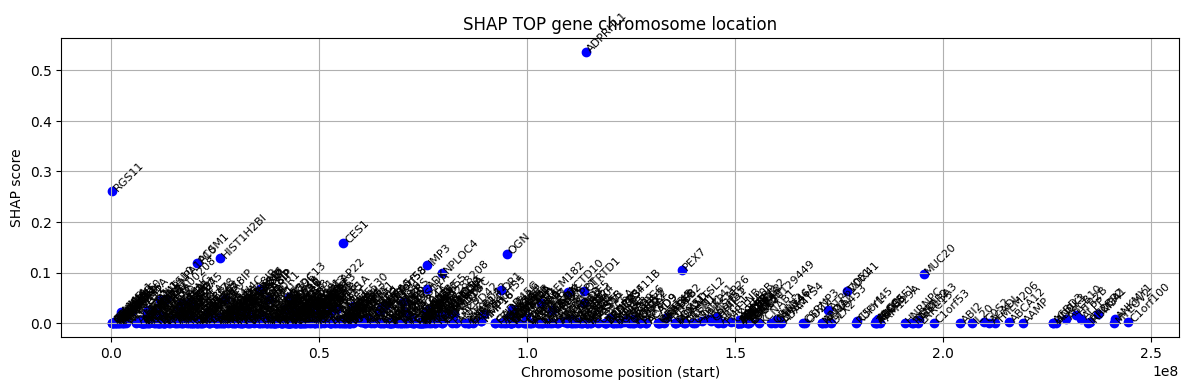

In [ ]:
# 시각화
plt.figure(figsize=(12, 4))
plt.scatter(merged['RANGE_START'], merged['SHAP_fat_mass'], c='blue')
for i in range(len(merged)):
    plt.text(merged['RANGE_START'].iloc[i], merged['SHAP_fat_mass'].iloc[i], merged['Gene'].iloc[i], fontsize=8, rotation=45)
plt.xlabel("Chromosome position (start)")
plt.ylabel("SHAP score")
plt.title("SHAP TOP gene chromosome location")
plt.grid(True)
plt.tight_layout()
plt.show()

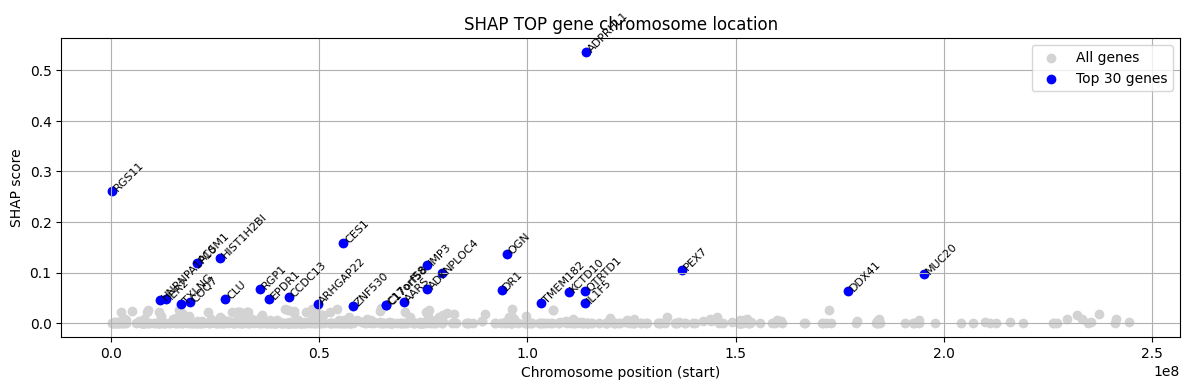

In [ ]:
import matplotlib.pyplot as plt

# Top N 유전자 선택 (예: SHAP_fat_mass 기준 상위 30개)
top_n = 30
top_genes = merged.sort_values('SHAP_fat_mass', ascending=False).head(top_n)

# 시각화
plt.figure(figsize=(12, 4))

# 전체 점 찍기 (라벨 없음)
plt.scatter(merged['RANGE_START'], merged['SHAP_fat_mass'], c='lightgray', label='All genes')

# Top N 점 다시 찍기 (색 다르게)
plt.scatter(top_genes['RANGE_START'], top_genes['SHAP_fat_mass'], c='blue', label=f'Top {top_n} genes')

# Top N에만 라벨 붙이기
for i in range(len(top_genes)):
    plt.text(top_genes['RANGE_START'].iloc[i],
             top_genes['SHAP_fat_mass'].iloc[i],
             top_genes['Gene'].iloc[i],
             fontsize=8, rotation=45)

plt.xlabel("Chromosome position (start)")
plt.ylabel("SHAP score")
plt.title("SHAP TOP gene chromosome location")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-38-3125221874>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shap_bin = merged.groupby('position_bin')['SHAP_fat_mass'].mean().reset_index()


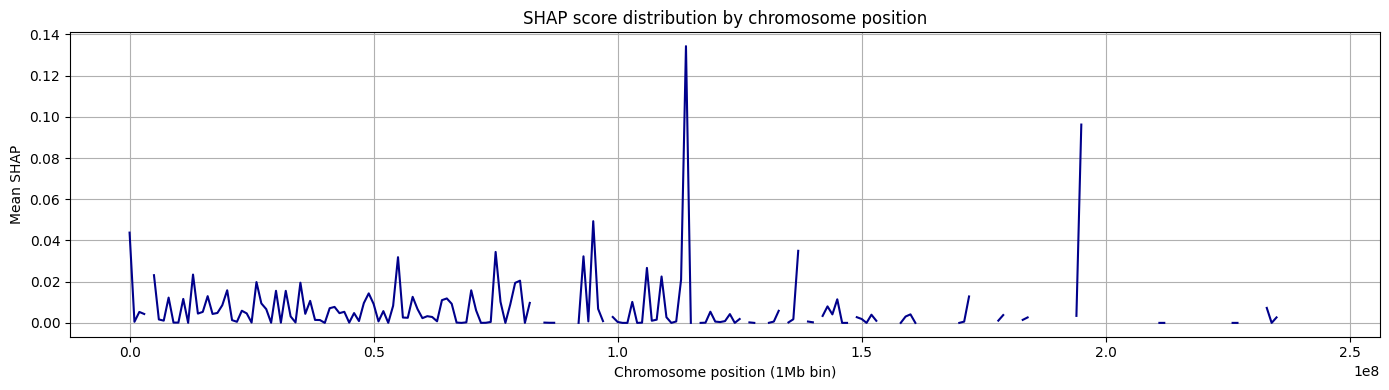

In [ ]:
import numpy as np

merged['position_bin'] = pd.cut(merged['RANGE_START'], bins=np.arange(0, 2.5e8, 1e6))
shap_bin = merged.groupby('position_bin')['SHAP_fat_mass'].mean().reset_index()
shap_bin['start'] = shap_bin['position_bin'].apply(lambda x: x.left)

plt.figure(figsize=(14, 4))
plt.plot(shap_bin['start'], shap_bin['SHAP_fat_mass'], color='darkblue')
plt.title("SHAP score distribution by chromosome position")
plt.xlabel("Chromosome position (1Mb bin)")
plt.ylabel("Mean SHAP")
plt.tight_layout()
plt.grid(True)
plt.show()

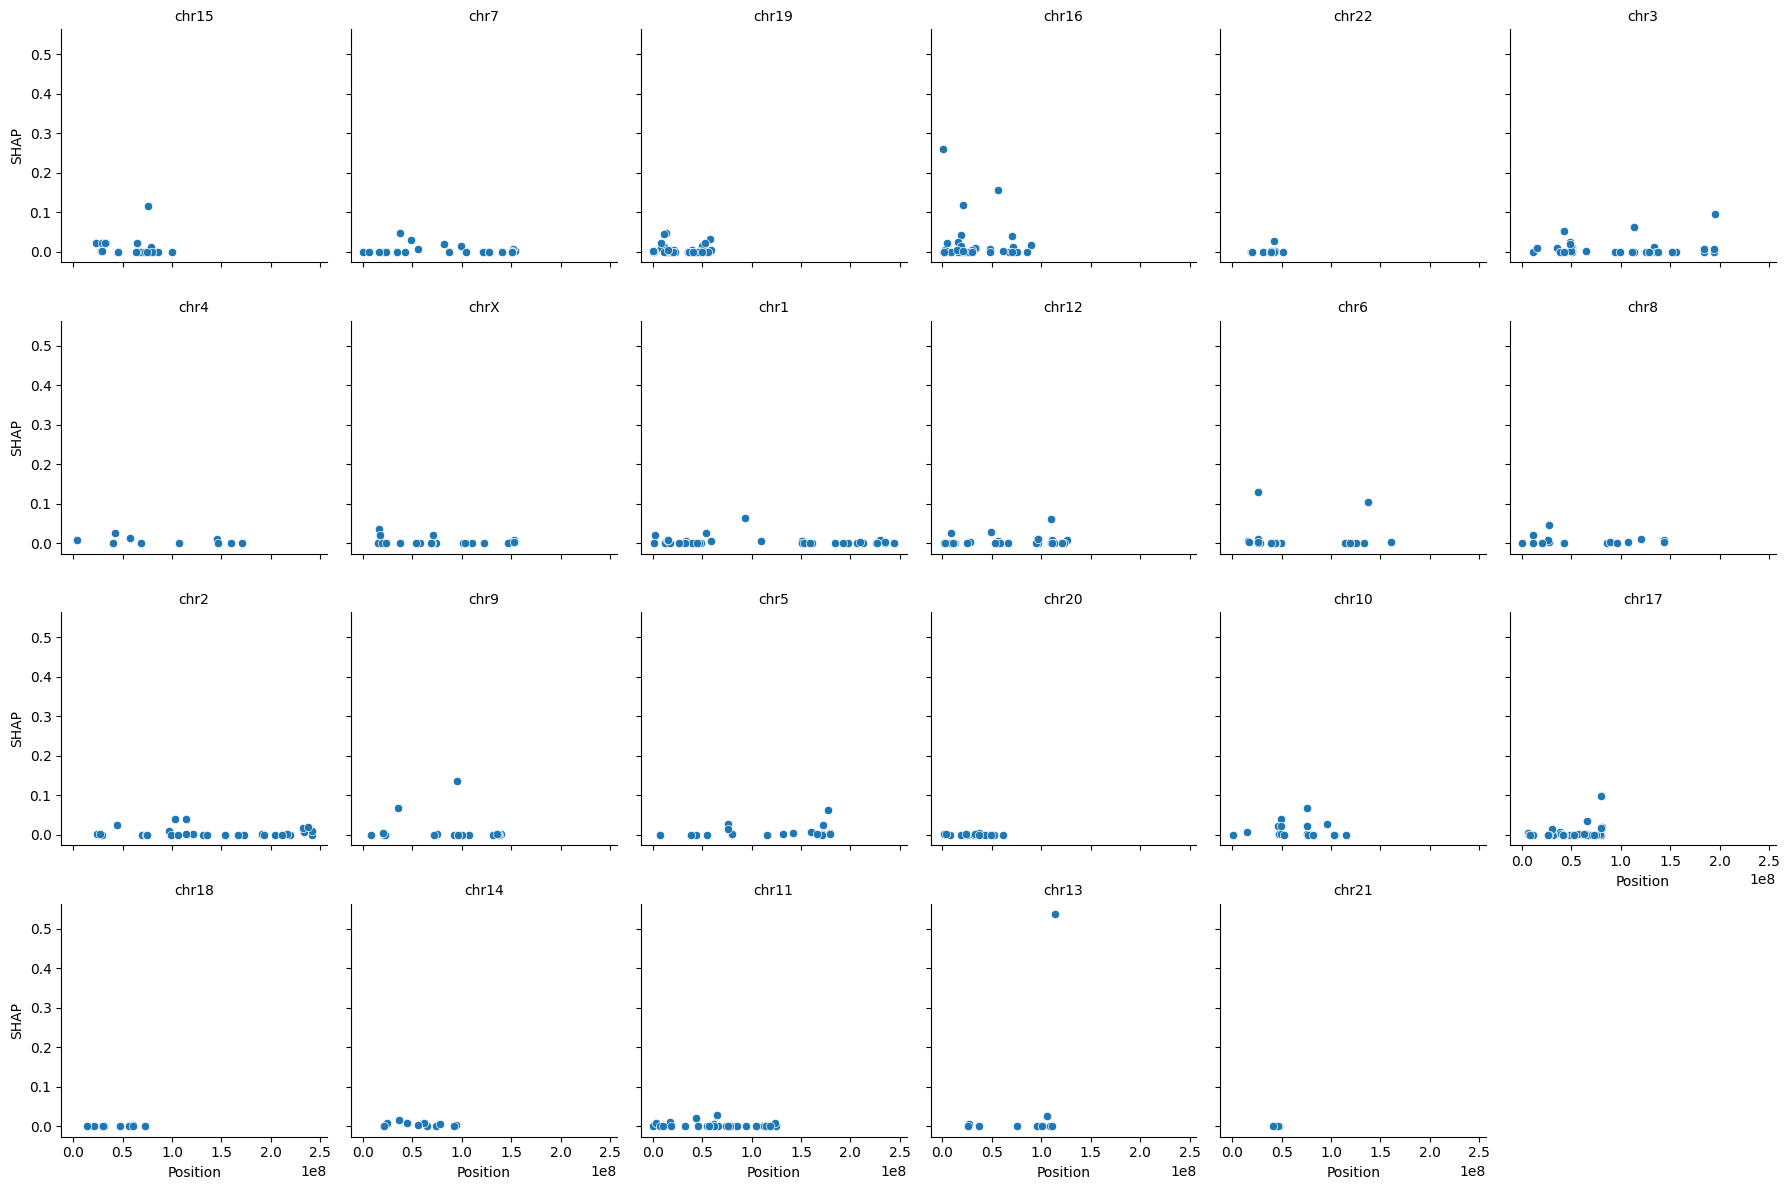

In [ ]:
import seaborn as sns
g = sns.FacetGrid(merged, col="seqname", col_wrap=6, height=3)
g.map_dataframe(sns.scatterplot, x="RANGE_START", y="SHAP_fat_mass")
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Position", "SHAP")
plt.tight_layout()
plt.show()

# 유전자 간 공동 조절 가능성, 염색체 기반 필터링, 그리고 실험자 성별과 모델 예측의 관계

In [ ]:
merged.columns

Index(['Unnamed: 0', 'Gene', 'SHAP_fat_mass', 'SHAP_fat_pct', 'SHAP_bmi',
       'SHAP_weight', 'ID', 'GB_LIST', 'SPOT_ID', 'seqname', 'RANGE_GB',
       'RANGE_STRAND', 'RANGE_START', 'RANGE_STOP', 'total_probes',
       'gene_assignment', 'mrna_assignment', 'category', 'gene_symbol',
       'position_bin'],
      dtype='object')

In [ ]:
# 염색체별 SHAP 높은 유전자 수 세기
chr_counts = merged.groupby('seqname')['SHAP_fat_mass'].mean().sort_values(ascending=False)
print(chr_counts)

seqname
chr13    0.054330
chr16    0.021692
chr15    0.015144
chr6     0.013320
chr10    0.011718
chr9     0.011134
chr3     0.009137
chr5     0.007772
chr8     0.007160
chr17    0.006794
chr19    0.006696
chr4     0.005824
chr12    0.005561
chr2     0.005281
chr7     0.005258
chrX     0.004770
chr14    0.004407
chr1     0.004350
chr22    0.003052
chr11    0.002453
chr20    0.000676
chr18    0.000581
chr21    0.000000
Name: SHAP_fat_mass, dtype: float64


In [ ]:
chr13_top = merged[merged['seqname'] == 'chr13'].sort_values('SHAP_fat_mass', ascending=False)
print(chr13_top[['Gene', 'SHAP_fat_mass']].head(10))

             Gene  SHAP_fat_mass
293       ADPRHL1       0.536428
94           DAOA       0.026687
93           DAOA       0.026687
71         SHISA2       0.004657
517      C13orf38       0.001577
172        ABHD13       0.001559
280  LOC100288208       0.000033
248        PABPC3       0.000000
198         CARS2       0.000000
310        CLDN10       0.000000


In [ ]:
shap_df['Gene'].to_list()

['IMP3',
 'ABCA13',
 'ZNF530',
 'COQ7',
 'ACO2',
 'C3orf18',
 'HHIP',
 'IER2',
 'MUC20',
 'SLC6A8',
 'A4GALT',
 'CCDC13',
 'ABCB10',
 'RND1',
 'PEX7',
 'LILRA5',
 'ANXA9',
 'C8orf80',
 'HIST1H4C',
 'IL28A',
 'ADRA1A',
 'RAB5B',
 'IL1F5',
 'AASDH',
 'OGN',
 'EPDR1',
 'DDX41',
 'ACSM3',
 'AACS',
 'NAPSB',
 'ABHD12',
 'TXLNG',
 'C16orf55',
 'AP4M1',
 'CRISP1',
 'MYLIP',
 'ATP1A3',
 'C10orf55',
 'AK2',
 'AKNAD1',
 'ACCN1',
 'ACBD7',
 'ZCCHC2',
 'ALG3',
 'SNORA67',
 'GAPDHS',
 'ZNF69',
 'ZADH2',
 'ABCB9',
 'ARHGAP26',
 'CTXN1',
 'DDX24',
 'C1orf100',
 'PRAMEF11',
 'ANKRD52',
 'STOML1',
 'NCRNA00208',
 'BRMS1L',
 'CDK4',
 'ABCG4',
 'ADAMTS10',
 'C9orf141',
 'MIR146A',
 'AGAP5',
 'FNDC5',
 'SHISA2',
 'TMEM182',
 'IL4I1',
 'USH1C',
 'AGPHD1',
 'MYH4',
 'ABCA7',
 'FLJ40453',
 'PSMD11',
 'HAO1',
 'MYEOV2',
 'TRIP4',
 'FAM129A',
 'AAK1',
 'CDCA5',
 'ANKRD42',
 'GLP1R',
 'RAB6B',
 'ALPP',
 'AARS2',
 'DAOA',
 'NPLOC4',
 'KCNS1',
 'A2ML1',
 'AADACL4',
 'GPRC6A',
 'ABCD1',
 'PPP2R1A',
 'DAZAP1',
 'C4

In [ ]:
top17_genes = shap_df.sort_values('SHAP_fat_mass', ascending=False)['Gene'].head(17).tolist()

In [ ]:
top17_genes

['ADPRHL1',
 'RGS11',
 'CES1',
 'OGN',
 'HIST1H2BI',
 'ACSM1',
 'IMP3',
 'PEX7',
 'NPLOC4',
 'MUC20',
 'RGP1',
 'ADK',
 'DR1',
 'QTRTD1',
 'DDX41',
 'KCTD10',
 'CCDC13']

# SHAP 기반 유전자 중요도 + 생물학적 경로(category) + time/treamtment별 유전자발현 양상

In [ ]:
gene_mapped_category=pd.read_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/gene_mapped_category.csv")
model2_shap_df=pd.read_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/model2_shap_df.csv")
gene_set_regulation_tensor_corrected=pd.read_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/gene_set_regulation_tensor_corrected.csv")

In [ ]:
# 1. explode gene_mapped_category to one gene per row
mapped_df = gene_mapped_category.explode("Matched_Genes")
mapped_df = mapped_df.rename(columns={"Matched_Genes": "Gene"})

# 2. 대소문자 정리
mapped_df['Gene'] = mapped_df['Gene'].str.upper()
model2_shap_df['Gene'] = model2_shap_df['Gene'].str.upper()

# 3. Merge: SHAP 값과 카테고리 연결
shap_category_merged = pd.merge(model2_shap_df, mapped_df[['Gene', 'Mapped_Category']], on='Gene', how='left')

In [ ]:
# SHAP 유전자 리스트 → 대소문자 & 공백 제거
model2_shap_df['Gene'] = model2_shap_df['Gene'].astype(str).str.strip().str.upper()

# matched_df (explode 후) → 동일하게 정제
mapped_df['Gene'] = mapped_df['Gene'].astype(str).str.strip().str.upper()

In [ ]:
set(model2_shap_df['Gene']).intersection(set(mapped_df['Gene']))

set()

In [ ]:
gene_mapped_category['Matched_Genes'].apply(len).value_counts()

Matched_Genes
9      187
10     168
8      118
11      61
17      60
      ... 
396      1
137      1
239      1
99       1
161      1
Name: count, Length: 107, dtype: int64

In [ ]:
shap_category_merged

Unnamed: 0    Gene  SHAP_fat_mass  SHAP_fat_pct  SHAP_bmi  SHAP_weight  \
0             0    IMP3       0.115690      0.030057  0.081708     0.056422   
1             1  ABCA13       0.028906      0.008492  0.064059     0.016020   
2             2  ZNF530       0.033554      0.005678  0.021947     0.013647   
3             3    COQ7       0.041904      0.028367  0.018270     0.013629   
4             4    ACO2       0.028415      0.002236  0.011134     0.017808   
..          ...     ...            ...           ...       ...          ...   
485         485    FDXR       0.000028      0.000144  0.000000     0.002733   
486         486   MEP1B       0.000000      0.000039  0.000000     0.000000   
487         487   CASP7       0.000000      0.000000  0.001086     0.001492   
488         488   ABCB8       0.000435      0.000506  0.000000     0.000000   
489         489  ABCC11       0.000000      0.000000  0.000000     0.000415   

    Mapped_Category  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  
..              ...  
485             NaN  
486             NaN  
487             NaN  
488             NaN  
489             NaN  

[490 rows x 7 columns]

In [ ]:
# regulation info 불러오기 (index reset)
reg_df = gene_set_regulation_tensor_corrected.reset_index()

# SHAP 카테고리와 regulation 매핑
final_df = pd.merge(shap_category_merged, reg_df, left_on="Mapped_Category", right_on="Gene_Set", how="left")

In [ ]:
final_df

Unnamed: 0    Gene  SHAP_fat_mass  SHAP_fat_pct  SHAP_bmi  SHAP_weight  \
0             0    IMP3       0.115690      0.030057  0.081708     0.056422   
1             1  ABCA13       0.028906      0.008492  0.064059     0.016020   
2             2  ZNF530       0.033554      0.005678  0.021947     0.013647   
3             3    COQ7       0.041904      0.028367  0.018270     0.013629   
4             4    ACO2       0.028415      0.002236  0.011134     0.017808   
..          ...     ...            ...           ...       ...          ...   
485         485    FDXR       0.000028      0.000144  0.000000     0.002733   
486         486   MEP1B       0.000000      0.000039  0.000000     0.000000   
487         487   CASP7       0.000000      0.000000  0.001086     0.001492   
488         488   ABCB8       0.000435      0.000506  0.000000     0.000000   
489         489  ABCC11       0.000000      0.000000  0.000000     0.000415   

    Mapped_Category  index Gene_Set Group Timepoint  Regulation  
0               NaN    NaN      NaN   NaN       NaN         NaN  
1               NaN    NaN      NaN   NaN       NaN         NaN  
2               NaN    NaN      NaN   NaN       NaN         NaN  
3               NaN    NaN      NaN   NaN       NaN         NaN  
4               NaN    NaN      NaN   NaN       NaN         NaN  
..              ...    ...      ...   ...       ...         ...  
485             NaN    NaN      NaN   NaN       NaN         NaN  
486             NaN    NaN      NaN   NaN       NaN         NaN  
487             NaN    NaN      NaN   NaN       NaN         NaN  
488             NaN    NaN      NaN   NaN       NaN         NaN  
489             NaN    NaN      NaN   NaN       NaN         NaN  

[490 rows x 12 columns]

In [ ]:
import sqlite3
import pandas as pd

# ① SQLite DB 연결
conn = sqlite3.connect("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/obesitygene_project.db")  # 경로에 따라 수정

# ② SQL 쿼리로 테이블 가져오기
query1 = "SELECT * FROM expression_change"
expression_change_df = pd.read_sql_query(query1, conn)

# ③ 필요 시 다른 테이블도 가져오기
expression_long_old_df = pd.read_sql_query("SELECT * FROM expression_long_old", conn)

# ④ 연결 종료
conn.close()

In [ ]:
conn = sqlite3.connect("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/obesitygene_project.db")
expression_long_df = pd.read_sql_query("SELECT * FROM expression_long", conn)
conn.close()

In [ ]:
expression_change_df

ID_REF subject_id   exp_C_A   exp_C_B   exp_B_A
0        7892501          1 -0.402629 -0.149945 -0.252684
1        7892502          1  1.251101  0.883600  0.367501
2        7892503          1 -1.115590 -0.330360 -0.785230
3        7892504          1  0.849925  0.743890  0.106035
4        7892505          1 -1.044279  0.261170 -1.305449
...          ...        ...       ...       ...       ...
1764736  8180414         61 -0.522933       NaN       NaN
1764737  8180415         61 -0.023247       NaN       NaN
1764738  8180416         61  0.040307       NaN       NaN
1764739  8180417         61 -0.013860       NaN       NaN
1764740  8180418         61 -0.794944       NaN       NaN

[1764741 rows x 5 columns]

In [ ]:
expression_long_old_df

ID_REF      gsm_id  expression
0        7892501  GSM2062466    4.428059
1        7892502  GSM2062466    3.015303
2        7892503  GSM2062466    2.469030
3        7892504  GSM2062466    7.469548
4        7892505  GSM2062466    2.655132
...          ...         ...         ...
5061139  8180414  GSM2062617    3.996389
5061140  8180415  GSM2062617    7.054198
5061141  8180416  GSM2062617    3.080801
5061142  8180417  GSM2062617    7.173843
5061143  8180418  GSM2062617    6.731832

[5061144 rows x 3 columns]

In [ ]:
expression_long_df

Empty DataFrame
Columns: [ID_REF, gsm_id, expression]
Index: []

In [ ]:
conn = sqlite3.connect("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/obesitygene_project.db")
timpoint_check_df = pd.read_sql_query("SELECT time_point FROM metadata", conn)
conn.close()

In [ ]:
timpoint_check_df

time_point
0                at study start
1      after weight loss period
2    after weight stable period
3                at study start
4      after weight loss period
..                          ...
147  after weight stable period
148              at study start
149    after weight loss period
150              at study start
151  after weight stable period

[152 rows x 1 columns]

# 머신러닝 X, y데이터셋 정의

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
model2_shap_df=pd.read_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/model2_shap_df.csv")

In [ ]:
model2_shap_df.columns

Index(['Unnamed: 0', 'Gene', 'SHAP_fat_mass', 'SHAP_fat_pct', 'SHAP_bmi',
       'SHAP_weight'],
      dtype='object')

In [ ]:
db_path="/content/drive/MyDrive/BIO_MEDICAL_PROJECT/obesitygene_project.db"

In [ ]:
import pandas as pd
model2_shap_df=pd.read_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/model2_shap_df.csv")

# 1. SHAP 상위 유전자 리스트 준비
gene_list = model2_shap_df['Gene'].unique().tolist()
# SQL에 넣기 위해 작은따옴표를 포함한 문자열로 변환
gene_list_str = ",".join(f"'{gene}'" for gene in gene_list)

In [ ]:
table_name = "expression_change"  # 확인할 테이블명
cursor.execute(f"PRAGMA table_info({table_name});")
columns = cursor.fetchall()

print(f"\n📑 '{table_name}' 테이블 컬럼 정보:")
for col in columns:
    print(f" - {col[1]} ({col[2]})")  # col[1]: 컬럼명, col[2]: 데이터 타입


📑 'expression_change' 테이블 컬럼 정보:
 - ID_REF (TEXT)
 - subject_id (TEXT)
 - exp_C_A (REAL)
 - exp_C_B (REAL)
 - exp_B_A (REAL)
 - exp_rate_AB (REAL)
 - exp_rate_BC (REAL)
 - exp_rate_AC (REAL)


In [ ]:
ALTER TABLE expression_change ADD COLUMN exp_rate_AB REAL;
ALTER TABLE expression_change ADD COLUMN exp_rate_BC REAL;
ALTER TABLE expression_change ADD COLUMN exp_rate_AC REAL;

UPDATE expression_change
SET exp_rate_AB = (
    SELECT ec.exp_B_A / w.gap_AB_weeks
    FROM expression_change AS ec
    JOIN week w ON ec.subject_id = w.subject_id
    WHERE ec.subject_id = expression_change.subject_id
);
UPDATE expression_change
SET exp_rate_BC = (
    SELECT ec.exp_C_B / w.gap_BC_weeks
    FROM expression_change AS ec
    JOIN week w ON ec.subject_id = w.subject_id
    WHERE ec.subject_id = expression_change.subject_id
);
UPDATE expression_change
SET exp_rate_AC = (
    SELECT ec.exp_C_A / (w.gap_AB_weeks + w.gap_BC_weeks)
    FROM expression_change AS ec
    JOIN week w ON ec.subject_id = w.subject_id
    WHERE ec.subject_id = expression_change.subject_id
);
UPDATE expression_change
SET base_expression = (
    SELECT elo.expression
    FROM metadata m
    JOIN expression_long_old elo ON m.gsm_id = elo.gsm_id
    WHERE m.subject_id = expression_change.subject_id
      AND m.time_point = 'at study start'
);


In [ ]:
ALTER TABLE metadata ADD COLUMN base_weight_kg REAL;
ALTER TABLE metadata ADD COLUMN base_bmi_kg_m2 REAL;
ALTER TABLE metadata ADD COLUMN base_body_fat_pct REAL;
ALTER TABLE metadata ADD COLUMN base_pure_fat_kg REAL;

UPDATE metadata
SET
    base_weight_kg = (
        SELECT m2.weight_kg
        FROM metadata m2
        WHERE m2.subject_id = metadata.subject_id AND m2.time_point = 'at study start'
        LIMIT 1
    ),
    base_bmi_kg_m2 = (
        SELECT m2.bmi_kg_m2
        FROM metadata m2
        WHERE m2.subject_id = metadata.subject_id AND m2.time_point = 'at study start'
        LIMIT 1
    ),
    base_body_fat_pct = (
        SELECT m2.body_fat_pct
        FROM metadata m2
        WHERE m2.subject_id = metadata.subject_id AND m2.time_point = 'at study start'
        LIMIT 1
    ),
    base_pure_fat_kg = (
        SELECT m2.pure_fat_kg
        FROM metadata m2
        WHERE m2.subject_id = metadata.subject_id AND m2.time_point = 'at study start'
        LIMIT 1
    );

In [ ]:
ALTER TABLE weight_bmi_changes ADD COLUMN weight_kg_rate_AB REAL;
ALTER TABLE weight_bmi_changes ADD COLUMN weight_kg_rate_BC REAL;
ALTER TABLE weight_bmi_changes ADD COLUMN weight_kg_rate_AC REAL;

ALTER TABLE weight_bmi_changes ADD COLUMN bmi_rate_AB REAL;
ALTER TABLE weight_bmi_changes ADD COLUMN bmi_rate_BC REAL;
ALTER TABLE weight_bmi_changes ADD COLUMN bmi_rate_AC REAL;

ALTER TABLE weight_bmi_changes ADD COLUMN fat_rate_AB REAL;
ALTER TABLE weight_bmi_changes ADD COLUMN fat_rate_BC REAL;
ALTER TABLE weight_bmi_changes ADD COLUMN fat_rate_AC REAL;

ALTER TABLE weight_bmi_changes ADD COLUMN pure_fat_rate_AB REAL;
ALTER TABLE weight_bmi_changes ADD COLUMN pure_fat_rate_BC REAL;
ALTER TABLE weight_bmi_changes ADD COLUMN pure_fat_rate_AC REAL;

UPDATE weight_bmi_changes
SET
    weight_kg_rate_AB = weight_kg_B_A / (
        SELECT gap_AB_weeks FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    ),
    weight_kg_rate_BC = weight_kg_C_B / (
        SELECT gap_BC_weeks FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    ),
    weight_kg_rate_AC = weight_kg_C_A / (
        SELECT (gap_AB_weeks + gap_BC_weeks) FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    ),

    bmi_rate_AB = bmi_B_A / (
        SELECT gap_AB_weeks FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    ),
    bmi_rate_BC = bmi_C_B / (
        SELECT gap_BC_weeks FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    ),
    bmi_rate_AC = bmi_C_A / (
        SELECT (gap_AB_weeks + gap_BC_weeks) FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    ),

    fat_rate_AB = fat_B_A / (
        SELECT gap_AB_weeks FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    ),
    fat_rate_BC = fat_C_B / (
        SELECT gap_BC_weeks FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    ),
    fat_rate_AC = fat_C_A / (
        SELECT (gap_AB_weeks + gap_BC_weeks) FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    ),

    pure_fat_rate_AB = pure_fat_B_A / (
        SELECT gap_AB_weeks FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    ),
    pure_fat_rate_BC = pure_fat_C_B / (
        SELECT gap_BC_weeks FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    ),
    pure_fat_rate_AC = pure_fat_C_A / (
        SELECT (gap_AB_weeks + gap_BC_weeks) FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    );

In [ ]:
query1= f"""
-- 열 추가
ALTER TABLE expression_change ADD COLUMN exp_rate_AB REAL;
ALTER TABLE expression_change ADD COLUMN exp_rate_BC REAL;
ALTER TABLE expression_change ADD COLUMN exp_rate_AC REAL;
ALTER TABLE expression_change ADD COLUMN base_expression REAL;

UPDATE expression_change
SET exp_rate_AB = (
    SELECT ec.exp_B_A / w.gap_AB_weeks
    FROM expression_change AS ec
    JOIN week w ON ec.subject_id = w.subject_id
    WHERE ec.subject_id = expression_change.subject_id
);
UPDATE expression_change
SET exp_rate_BC = (
    SELECT ec.exp_C_B / w.gap_BC_weeks
    FROM expression_change AS ec
    JOIN week w ON ec.subject_id = w.subject_id
    WHERE ec.subject_id = expression_change.subject_id
);
UPDATE expression_change
SET exp_rate_AC = (
    SELECT ec.exp_C_A / (w.gap_AB_weeks + w.gap_BC_weeks)
    FROM expression_change AS ec
    JOIN week w ON ec.subject_id = w.subject_id
    WHERE ec.subject_id = expression_change.subject_id
);
"""

query2 = f"""
SELECT ec.*, p.gene_symbol
FROM expression_change ec
JOIN platform p ON ec.ID_REF = p.ID
WHERE p.gene_symbol IN ({gene_list_str})
"""

query3=f"""
ALTER TABLE expression_change ADD COLUMN base_expression REAL;

UPDATE expression_change
SET base_expression = (
    SELECT elo.expression
    FROM metadata m
    JOIN expression_long_old elo ON m.gsm_id = elo.gsm_id
    WHERE m.subject_id = expression_change.subject_id
      AND m.time_point = 'at study start'
);
"""

query4=f"""
ALTER TABLE metadata ADD COLUMN base_weight_kg REAL;
ALTER TABLE metadata ADD COLUMN base_bmi_kg_m2 REAL;
ALTER TABLE metadata ADD COLUMN base_body_fat_pct REAL;
ALTER TABLE metadata ADD COLUMN base_pure_fat_kg REAL;

UPDATE metadata
SET
    base_weight_kg = (
        SELECT m2.weight_kg
        FROM metadata m2
        WHERE m2.subject_id = metadata.subject_id AND m2.time_point = 'at study start'
        LIMIT 1
    ),
    base_bmi_kg_m2 = (
        SELECT m2.bmi_kg_m2
        FROM metadata m2
        WHERE m2.subject_id = metadata.subject_id AND m2.time_point = 'at study start'
        LIMIT 1
    ),
    base_body_fat_pct = (
        SELECT m2.body_fat_pct
        FROM metadata m2
        WHERE m2.subject_id = metadata.subject_id AND m2.time_point = 'at study start'
        LIMIT 1
    ),
    base_pure_fat_kg = (
        SELECT m2.pure_fat_kg
        FROM metadata m2
        WHERE m2.subject_id = metadata.subject_id AND m2.time_point = 'at study start'
        LIMIT 1
    );
"""

query5=f"""
ALTER TABLE weight_bmi_changes ADD COLUMN weight_kg_rate_AB REAL;
ALTER TABLE weight_bmi_changes ADD COLUMN weight_kg_rate_BC REAL;
ALTER TABLE weight_bmi_changes ADD COLUMN weight_kg_rate_AC REAL;

ALTER TABLE weight_bmi_changes ADD COLUMN bmi_rate_AB REAL;
ALTER TABLE weight_bmi_changes ADD COLUMN bmi_rate_BC REAL;
ALTER TABLE weight_bmi_changes ADD COLUMN bmi_rate_AC REAL;

ALTER TABLE weight_bmi_changes ADD COLUMN fat_rate_AB REAL;
ALTER TABLE weight_bmi_changes ADD COLUMN fat_rate_BC REAL;
ALTER TABLE weight_bmi_changes ADD COLUMN fat_rate_AC REAL;

ALTER TABLE weight_bmi_changes ADD COLUMN pure_fat_rate_AB REAL;
ALTER TABLE weight_bmi_changes ADD COLUMN pure_fat_rate_BC REAL;
ALTER TABLE weight_bmi_changes ADD COLUMN pure_fat_rate_AC REAL;

UPDATE weight_bmi_changes
SET
    weight_kg_rate_AB = weight_kg_B_A / (
        SELECT gap_AB_weeks FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    ),
    weight_kg_rate_BC = weight_kg_C_B / (
        SELECT gap_BC_weeks FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    ),
    weight_kg_rate_AC = weight_kg_C_A / (
        SELECT (gap_AB_weeks + gap_BC_weeks) FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    ),

    bmi_rate_AB = bmi_B_A / (
        SELECT gap_AB_weeks FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    ),
    bmi_rate_BC = bmi_C_B / (
        SELECT gap_BC_weeks FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    ),
    bmi_rate_AC = bmi_C_A / (
        SELECT (gap_AB_weeks + gap_BC_weeks) FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    ),

    fat_rate_AB = fat_B_A / (
        SELECT gap_AB_weeks FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    ),
    fat_rate_BC = fat_C_B / (
        SELECT gap_BC_weeks FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    ),
    fat_rate_AC = fat_C_A / (
        SELECT (gap_AB_weeks + gap_BC_weeks) FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    ),

    pure_fat_rate_AB = pure_fat_B_A / (
        SELECT gap_AB_weeks FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    ),
    pure_fat_rate_BC = pure_fat_C_B / (
        SELECT gap_BC_weeks FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    ),
    pure_fat_rate_AC = pure_fat_C_A / (
        SELECT (gap_AB_weeks + gap_BC_weeks) FROM week WHERE week.subject_id = weight_bmi_changes.subject_id
    );
"""

query6=f"""
DROP TABLE IF EXISTS expression_long;
"""

query7=f"""
DROP TABLE IF EXISTS week;

CREATE TABLE week AS
SELECT
    subject_id,
    treatment,
    CASE
        WHEN treatment = 'LCD' THEN 12
        WHEN treatment = 'VLCD' THEN 5
        ELSE NULL
    END AS gap_AB_weeks,
    4 AS gap_BC_weeks
FROM (
    SELECT DISTINCT subject_id, treatment
    FROM metadata
);
"""

In [ ]:
import sqlite3

# DB 연결
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.executescript(query7)
# cursor.executescript(query1)
cursor.executescript(query3)
cursor.executescript(query4)
cursor.executescript(query5)
cursor.executescript(query6)

# 변경사항 저장
conn.commit()

# 연결 종료
conn.close()

In [ ]:
import sqlite3

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

query = """
-- 1. 기존 테이블 백업
DROP TABLE IF EXISTS expression_change_backup;
CREATE TABLE expression_change_backup AS SELECT * FROM expression_change;

-- 2. 기존 테이블 삭제
DROP TABLE IF EXISTS expression_change;

-- 3. 새 테이블 생성 (원래 컬럼 + 새 컬럼만)
CREATE TABLE expression_change (
    ID_REF TEXT,
    subject_id TEXT,
    exp_C_A REAL,
    exp_C_B REAL,
    exp_B_A REAL,
    base_expression REAL,
    exp_rate_AB REAL,
    exp_rate_BC REAL,
    exp_rate_AC REAL
);

-- 4. 백업 테이블에서 데이터 복사
INSERT INTO expression_change (ID_REF, subject_id, exp_C_A, exp_C_B, exp_B_A, base_expression)
SELECT ID_REF, subject_id, exp_C_A, exp_C_B, exp_B_A, base_expression
FROM expression_change_backup;

-- 5. 발현율 열 계산
UPDATE expression_change
SET exp_rate_AB = exp_B_A / (
    SELECT
        CASE CAST(m.treatment AS TEXT)
            WHEN 'LCD' THEN 12
            WHEN 'VLCD' THEN 5
            ELSE NULL
        END
    FROM metadata m
    WHERE CAST(m.subject_id AS TEXT) = CAST(expression_change.subject_id AS TEXT)
    LIMIT 1
);

UPDATE expression_change
SET exp_rate_BC = exp_C_B / 4;

UPDATE expression_change
SET exp_rate_AC = exp_C_A / (
    SELECT
        CASE CAST(m.treatment AS TEXT)
            WHEN 'LCD' THEN 16
            WHEN 'VLCD' THEN 9
            ELSE NULL
        END
    FROM metadata m
    WHERE CAST(m.subject_id AS TEXT) = CAST(expression_change.subject_id AS TEXT)
    LIMIT 1
);

-- 필요시 백업 제거
DROP TABLE expression_change_backup;
"""

cursor.executescript(query)
conn.commit()
conn.close()

In [ ]:
import sqlite3

conn = sqlite3.connect(db_path)  # 경로에 맞게 수정
cursor = conn.cursor()

# 모든 테이블 이름 출력
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("📂 테이블 목록:")
for table in tables:
    print(" -", table[0])

📂 테이블 목록:
 - expression_long_old
 - platform
 - metadata
 - weight_bmi_changes
 - week
 - expression_change


In [ ]:
import sqlite3
import pandas as pd

conn = sqlite3.connect(db_path)

# 1. 전체 테이블 목록 확인
tables_df = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("📦 전체 테이블 목록:")
print(tables_df)

# 2. 각 테이블별 컬럼 구조 출력
for table_name in tables_df['name']:
    print(f"\n📄 테이블: {table_name}")
    columns_df = pd.read_sql_query(f"PRAGMA table_info({table_name});", conn)
    print(columns_df)

conn.close()

📦 전체 테이블 목록:
                  name
0  expression_long_old
1             platform
2             metadata
3   weight_bmi_changes
4                 week
5    expression_change

📄 테이블: expression_long_old
   cid        name     type  notnull dflt_value  pk
0    0      ID_REF  INTEGER        0       None   0
1    1      gsm_id     TEXT        0       None   0
2    2  expression     REAL        0       None   0

📄 테이블: platform
    cid             name     type  notnull dflt_value  pk
0     0               ID     TEXT        0       None   1
1     1          GB_LIST     TEXT        0       None   0
2     2          SPOT_ID     TEXT        0       None   0
3     3          seqname     TEXT        0       None   0
4     4         RANGE_GB     TEXT        0       None   0
5     5     RANGE_STRAND     TEXT        0       None   0
6     6      RANGE_START  INTEGER        0       None   0
7     7       RANGE_STOP  INTEGER        0       None   0
8     8     total_probes  INTEGER        0       No

### 개빡치지만 할 수 있어^^ expression_change테이블 데이터 증발돼서 다시 채워넣기


In [ ]:
import numpy as np
gene_tensor = np.load('/content/drive/MyDrive/BIO_MEDICAL_PROJECT/gene_expression_tensor.npy')

In [ ]:
gene_expr = pd.read_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/gene_expr.csv")
genes = sorted(gene_expr['gene_symbol'].unique())
subjects = sorted(gene_expr['subject_id'].unique())
timepoints = ['at study start', 'after weight loss period', 'after weight stable period']

In [ ]:
import numpy as np
import pandas as pd

# 전제: gene_tensor, genes, subjects, timepoints 정의되어 있음
# shape = (subjects, genes, timepoints)
n_subjects, n_genes, n_timepoints = gene_tensor.shape

# 반복용 리스트 초기화
records = []

for subj_idx in range(n_subjects):
    for gene_idx_ in range(n_genes):
        exp_A = gene_tensor[subj_idx, gene_idx_, 0]  # at study start
        exp_B = gene_tensor[subj_idx, gene_idx_, 1]  # after weight loss
        exp_C = gene_tensor[subj_idx, gene_idx_, 2]  # after weight stable

        # 변화량 계산
        exp_B_A = exp_B - exp_A if not np.isnan(exp_B) and not np.isnan(exp_A) else np.nan
        exp_C_B = exp_C - exp_B if not np.isnan(exp_C) and not np.isnan(exp_B) else np.nan
        exp_C_A = exp_C - exp_A if not np.isnan(exp_C) and not np.isnan(exp_A) else np.nan

        # subject_id와 gene_id
        subject_id = subjects[subj_idx]
        gene_symbol = genes[gene_idx_]

        # 저장
        records.append({
            "ID_REF": gene_symbol,
            "subject_id": subject_id,
            "exp_C_A": exp_C_A,
            "exp_C_B": exp_C_B,
            "exp_B_A": exp_B_A,
            "base_expression": exp_A
        })

# 데이터프레임 생성
expression_change_df = pd.DataFrame(records)

In [ ]:
expression_change_df

ID_REF  subject_id   exp_C_A   exp_C_B   exp_B_A  base_expression
0             A1BG           1 -0.203501  0.024903 -0.228405         4.328981
1             A1CF           1 -0.257881 -0.235089 -0.022792         2.366574
2            A2LD1           1 -0.076882  0.116908 -0.193790         5.501513
3              A2M           1 -0.070258 -0.424274  0.354016        10.889041
4            A2ML1           1 -0.053789 -0.089855  0.036066         2.860868
...            ...         ...       ...       ...       ...              ...
1063917        ZYX          61  0.035611 -0.108323  0.143934         7.481585
1063918      ZZEF1          61 -0.025402  0.089332 -0.114734         7.426352
1063919       ZZZ3          61 -0.152688 -0.021574 -0.131114         7.350847
1063920  psiTPTE22          61  0.224251  0.151044  0.073207         5.162764
1063921       tAKR          61  0.037089  0.165998 -0.128909         2.499892

[1063922 rows x 6 columns]

In [ ]:
conn = sqlite3.connect(db_path)
metadata_df=pd.read_sql("SELECT * FROM metadata", conn)
conn.close()

In [ ]:
metadata_df

gsm_id subject_id                                tissue  \
0    GSM2062466          1  abdominal subcutaneous white adipose   
1    GSM2062467          1  abdominal subcutaneous white adipose   
2    GSM2062468          1  abdominal subcutaneous white adipose   
3    GSM2062469          2  abdominal subcutaneous white adipose   
4    GSM2062470          2  abdominal subcutaneous white adipose   
..          ...        ...                                   ...   
147  GSM2062613         56  abdominal subcutaneous white adipose   
148  GSM2062614         59  abdominal subcutaneous white adipose   
149  GSM2062615         59  abdominal subcutaneous white adipose   
150  GSM2062616         61  abdominal subcutaneous white adipose   
151  GSM2062617         61  abdominal subcutaneous white adipose   

                 treatment                  time_point     sex  age_yrs  \
0    very-low-calorie diet              at study start  female     46.0   
1    very-low-calorie diet    after weight loss period  female     46.0   
2    very-low-calorie diet  after weight stable period  female     46.0   
3    very-low-calorie diet              at study start  female     45.0   
4    very-low-calorie diet    after weight loss period  female     45.0   
..                     ...                         ...     ...      ...   
147       low-calorie diet  after weight stable period    male     56.0   
148       low-calorie diet              at study start    male     67.0   
149       low-calorie diet    after weight loss period    male     67.0   
150  very-low-calorie diet              at study start    male     52.0   
151  very-low-calorie diet  after weight stable period    male     52.0   

     height_cm  weight_kg  bmi_kg_m2  body_fat_pct  pure_fat_kg  \
0        167.0      83.38      29.90          39.9     33.26862   
1        167.0      75.16      26.95          35.8     26.90728   
2        167.0      73.79      26.46          32.4     23.90796   
3        164.0      80.94      30.09          46.7     37.79898   
4        164.0      71.92      26.74          43.0     30.92560   
..         ...        ...        ...           ...          ...   
147      171.0      89.98      30.77          36.5     32.84270   
148      168.5      82.42      29.03          28.2     23.24244   
149      168.5      75.01      26.42          21.2     15.90212   
150      182.0      94.26      28.46          31.1     29.31486   
151      182.0      88.50      26.72          26.6     23.54100   

     base_weight_kg  base_bmi_kg_m2  base_body_fat_pct  base_pure_fat_kg  
0             83.38           29.90               39.9          33.26862  
1             83.38           29.90               39.9          33.26862  
2             83.38           29.90               39.9          33.26862  
3             80.94           30.09               46.7          37.79898  
4             80.94           30.09               46.7          37.79898  
..              ...             ...                ...               ...  
147           93.36           31.93               40.0          37.34400  
148           82.42           29.03               28.2          23.24244  
149           82.42           29.03               28.2          23.24244  
150           94.26           28.46               31.1          29.31486  
151           94.26           28.46               31.1          29.31486  

[152 rows x 16 columns]

In [ ]:
# treatment 정보 필요 (subject_id → treatment)
treatment_map = metadata_df[metadata_df['time_point'] == 'at study start'] \
    .set_index('subject_id')['treatment'].to_dict()

def compute_rate(row, gap_A_B, gap_B_C):
    rate_AB = row['exp_B_A'] / gap_A_B if pd.notnull(row['exp_B_A']) else np.nan
    rate_BC = row['exp_C_B'] / gap_B_C if pd.notnull(row['exp_C_B']) else np.nan
    total_gap = gap_A_B + gap_B_C
    rate_AC = row['exp_C_A'] / total_gap if pd.notnull(row['exp_C_A']) else np.nan
    return pd.Series([rate_AB, rate_BC, rate_AC], index=['exp_rate_AB', 'exp_rate_BC', 'exp_rate_AC'])

# 변화율 열 추가
expression_change_df[['exp_rate_AB', 'exp_rate_BC', 'exp_rate_AC']] = expression_change_df.apply(
    lambda row: compute_rate(
        row,
        12 if treatment_map.get(row['subject_id']) == 'LCD' else 5,
        4
    ),
    axis=1
)

In [ ]:
expression_change_df.shape

(1063922, 9)

In [ ]:
expression_change_df.columns
# ['ID_REF', 'subject_id', 'exp_C_A', 'exp_C_B', 'exp_B_A', 'base_expression',
#  'exp_rate_AB', 'exp_rate_BC', 'exp_rate_AC']

Index(['ID_REF', 'subject_id', 'exp_C_A', 'exp_C_B', 'exp_B_A',
       'base_expression', 'exp_rate_AB', 'exp_rate_BC', 'exp_rate_AC'],
      dtype='object')

In [ ]:
import sqlite3

# SQLite 연결
conn = sqlite3.connect(db_path)  # 경로에 맞게 수정
cursor = conn.cursor()

# DataFrame 삽입 (if_exists='append' 이므로 기존 테이블에 덧붙임)
expression_change_df.to_sql("expression_change", conn, if_exists='append', index=False)

conn.commit()
conn.close()

In [ ]:
import sqlite3
import pandas as pd

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# 모든 테이블 이름 가져오기
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# 각 테이블별 행 수 확인
table_counts = {}
for (table_name,) in tables:
    cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
    count = cursor.fetchone()[0]
    table_counts[table_name] = count

# 보기 좋게 출력
df = pd.DataFrame(table_counts.items(), columns=["Table Name", "Row Count"])
print(df)

conn.close()

            Table Name  Row Count
0  expression_long_old    5061144
1             platform      33297
2             metadata        152
3   weight_bmi_changes         53
4                 week         53
5    expression_change    1063922


In [ ]:
query2 = f"""
SELECT ec.*, p.gene_symbol
FROM expression_change ec
JOIN platform p ON ec.ID_REF = p.ID
WHERE p.gene_symbol IN ({gene_list_str})
"""

In [ ]:
conn = sqlite3.connect(db_path)
expression_change = pd.read_sql("SELECT * FROM expression_change", conn)
conn.close()

In [ ]:
expression_change

Empty DataFrame
Columns: [ID_REF, subject_id, exp_C_A, exp_C_B, exp_B_A, base_expression, exp_rate_AB, exp_rate_BC, exp_rate_AC]
Index: []

In [ ]:
conn = sqlite3.connect(db_path)
expression_change_df = pd.read_sql(query2, conn)
conn.close()

In [ ]:
expression_change_df

Empty DataFrame
Columns: [ID_REF, subject_id, exp_C_A, exp_C_B, exp_B_A, base_expression, exp_rate_AB, exp_rate_BC, exp_rate_AC, gene_symbol]
Index: []

In [ ]:
# 3. SQL 실행
expression_change_df = pd.read_sql(query2, conn)

platform_df=pd.read_sql("SELECT * FROM platform", conn)

weight_bmi_changes_df = pd.read_sql("SELECT seqname, RANGE_START FROM weight_bmi_changes", conn)


# 🔷 Feature (X)
X = df[['exp_rate_AB', 'exp_rate_BC', 'exp_rate_AC',
        'weight_kg_rate_AB', 'weight_kg_rate_BC', 'weight_kg_rate_AC',
        'bmi_rate_AB', 'bmi_rate_BC', 'bmi_rate_AC',
        'fat_rate_AB', 'fat_rate_BC', 'fat_rate_AC',
        'pure_fat_rate_AB', 'pure_fat_rate_BC', 'pure_fat_rate_AC',
        'base_weight_kg', 'base_bmi_kg_m2', 'base_body_fat_pct', 'base_pure_fat_kg',
        'age_yrs', 'height_cm', 'sex', 'treatment']]

# 🔶 Label (y)
y = df[['weight_kg_C_A', 'bmi_C_A', 'fat_C_A', 'pure_fat_C_A']]

# 성별/처치 인코딩
X = pd.get_dummies(X, columns=['sex', 'treatment'], drop_first=True)

# 확인
print("✅ X shape:", X.shape)
print("✅ y shape:", y.shape)


DatabaseError: Execution failed on sql 'SELECT * FROM expression_change WHERE ': incomplete input

# 다시 드디어 머신러닝 데이터셋 만드는 차례~~

In [ ]:
x_columns = [
    # platform 테이블
    'seqname', 'RANGE_START',

    # metadata 테이블
    'treatment', 'sex', 'age_yrs',
    'base_weight_kg', 'base_bmi_kg_m2', 'base_body_fat_pct', 'base_pure_fat_kg',

    # weight_bmi_changes 테이블
    'weight_kg_rate_AB', 'weight_kg_rate_BC', 'weight_kg_rate_AC',
    'bmi_rate_AB', 'bmi_rate_BC', 'bmi_rate_AC',
    'fat_rate_AB', 'fat_rate_BC', 'fat_rate_AC',
    'pure_fat_rate_AB', 'pure_fat_rate_BC', 'pure_fat_rate_AC',

    # expression_change 테이블
    'base_expression', 'exp_rate_AB', 'exp_rate_BC', 'exp_rate_AC',
]

In [ ]:
conn = sqlite3.connect(db_path)

platform_df=pd.read_sql("SELECT * FROM platform", conn)
metadata_df=pd.read_sql("SELECT * FROM metadata", conn)
weight_bmi_changes_df=pd.read_sql("SELECT * FROM weight_bmi_changes", conn)
expression_change_df=pd.read_sql("SELECT * FROM expression_change", conn)

conn.close()

In [ ]:
platform=pd.read_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/platform.csv")
metadata=pd.read_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/metadata.csv")
weight_bmi_changes=pd.read_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/weight_bmi_changes.csv")
expression_change=pd.read_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/expression_change.csv")

In [ ]:
platform_df

ID                                            GB_LIST  \
0      7896736                                               None   
1      7896738                                               None   
2      7896740  NM_001005240,NM_001004195,NM_001005484,BC13684...   
3      7896742                                  BC118988,AL137655   
4      7896744  NM_001005277,NM_001005221,NM_001005224,NM_0010...   
...        ...                                                ...   
33292  8180416                                        NM_002551.3   
33293  8180417                                        NM_018396.2   
33294  8180418                                     NM_001040145.1   
33295  7976552                                               None   
33296  8020352                                               None   

                       SPOT_ID seqname      RANGE_GB RANGE_STRAND  \
0             chr1:53049-54936    chr1  NC_000001.10            +   
1             chr1:63015-63887    chr1  NC_000001.10            +   
2             chr1:69091-70008    chr1  NC_000001.10            +   
3           chr1:334129-334296    chr1  NC_000001.10            +   
4           chr1:367659-368597    chr1  NC_000001.10            +   
...                        ...     ...           ...          ...   
33292         flmrna->unmapped     ---          None          ---   
33293         flmrna->unmapped     ---          None          ---   
33294         flmrna->unmapped     ---          None          ---   
33295  chr14:96154516-96154596   chr14   NC_000014.8            +   
33296  chr18:14341593-14342513   chr18   NC_000018.9            +   

       RANGE_START  RANGE_STOP  total_probes  \
0            53049       54936             7   
1            63015       63887            31   
2            69091       70008            24   
3           334129      334296             6   
4           367659      368597            36   
...            ...         ...           ...   
33292            0           0            39   
33293            0           0            33   
33294            0           0             6   
33295     96154516    96154596             4   
33296     14341593    14342513             9   

                                         gene_assignment  \
0                                                    ---   
1                                                    ---   
2      NM_001005240 // OR4F17 // olfactory receptor, ...   
3      ENST00000388975 // SEPT14 // septin 14 // 7p11...   
4      NM_001005277 // OR4F16 // olfactory receptor, ...   
...                                                  ...   
33292                                                ---   
33293                                                ---   
33294                                                ---   
33295                                                ---   
33296                                                ---   

                                         mrna_assignment          category  \
0                                                    ---               ---   
1      ENST00000328113 // ENSEMBL // cdna:pseudogene ...              main   
2      NM_001005240 // RefSeq // Homo sapiens olfacto...              main   
3      ENST00000388975 // ENSEMBL // Septin-14 gene:E...              main   
4      NM_001005277 // RefSeq // Homo sapiens olfacto...              main   
...                                                  ...               ...   
33292  NM_002551.3 // --- // Homo sapiens olfactory r...  flmrna->unmapped   
33293  NM_018396.2 // --- // Homo sapiens methyltrans...  flmrna->unmapped   
33294  NM_001040145.1 // --- // Homo sapiens chromoso...  flmrna->unmapped   
33295                                                ---               ---   
33296                                                ---               ---   

      gene_symbol  
0            None  
1            None  
2          OR4F17  
3          SEPT14  
4          OR4F16  

In [ ]:
metadata_df

gsm_id subject_id                                tissue  \
0    GSM2062466          1  abdominal subcutaneous white adipose   
1    GSM2062467          1  abdominal subcutaneous white adipose   
2    GSM2062468          1  abdominal subcutaneous white adipose   
3    GSM2062469          2  abdominal subcutaneous white adipose   
4    GSM2062470          2  abdominal subcutaneous white adipose   
..          ...        ...                                   ...   
147  GSM2062613         56  abdominal subcutaneous white adipose   
148  GSM2062614         59  abdominal subcutaneous white adipose   
149  GSM2062615         59  abdominal subcutaneous white adipose   
150  GSM2062616         61  abdominal subcutaneous white adipose   
151  GSM2062617         61  abdominal subcutaneous white adipose   

                 treatment                  time_point     sex  age_yrs  \
0    very-low-calorie diet              at study start  female     46.0   
1    very-low-calorie diet    after weight loss period  female     46.0   
2    very-low-calorie diet  after weight stable period  female     46.0   
3    very-low-calorie diet              at study start  female     45.0   
4    very-low-calorie diet    after weight loss period  female     45.0   
..                     ...                         ...     ...      ...   
147       low-calorie diet  after weight stable period    male     56.0   
148       low-calorie diet              at study start    male     67.0   
149       low-calorie diet    after weight loss period    male     67.0   
150  very-low-calorie diet              at study start    male     52.0   
151  very-low-calorie diet  after weight stable period    male     52.0   

     height_cm  weight_kg  bmi_kg_m2  body_fat_pct  pure_fat_kg  \
0        167.0      83.38      29.90          39.9     33.26862   
1        167.0      75.16      26.95          35.8     26.90728   
2        167.0      73.79      26.46          32.4     23.90796   
3        164.0      80.94      30.09          46.7     37.79898   
4        164.0      71.92      26.74          43.0     30.92560   
..         ...        ...        ...           ...          ...   
147      171.0      89.98      30.77          36.5     32.84270   
148      168.5      82.42      29.03          28.2     23.24244   
149      168.5      75.01      26.42          21.2     15.90212   
150      182.0      94.26      28.46          31.1     29.31486   
151      182.0      88.50      26.72          26.6     23.54100   

     base_weight_kg  base_bmi_kg_m2  base_body_fat_pct  base_pure_fat_kg  
0             83.38           29.90               39.9          33.26862  
1             83.38           29.90               39.9          33.26862  
2             83.38           29.90               39.9          33.26862  
3             80.94           30.09               46.7          37.79898  
4             80.94           30.09               46.7          37.79898  
..              ...             ...                ...               ...  
147           93.36           31.93               40.0          37.34400  
148           82.42           29.03               28.2          23.24244  
149           82.42           29.03               28.2          23.24244  
150           94.26           28.46               31.1          29.31486  
151           94.26           28.46               31.1          29.31486  

[152 rows x 16 columns]

In [ ]:
weight_bmi_changes_df

subject_id  weight_kg_C_A  weight_kg_C_B  weight_kg_B_A  bmi_C_A  bmi_C_B  \
0           1          -9.59          -1.37          -8.22    -3.44    -0.49   
1           2          -9.97          -0.95          -9.02    -3.70    -0.35   
2           3          -9.47           2.13         -11.60    -2.97     0.68   
3           4          -4.91           0.11          -5.02    -2.07     0.05   
4           5         -12.65          -0.35         -12.30    -3.95    -0.11   
5           6          -3.94           1.87          -5.81    -1.57     0.75   
6           8          -5.66           0.58          -6.24    -2.08     0.21   
7           9          -9.94          -0.57          -9.37    -3.46    -0.20   
8          10         -10.48          -1.02          -9.46    -3.55    -0.35   
9          11          -9.73          -0.73          -9.00    -3.00    -0.22   
10         12          -5.14           0.97          -6.11    -1.89     0.36   
11         13         -11.14          -0.02         -11.12    -3.91    -0.01   
12         14         -10.08           0.67         -10.75    -2.93     0.20   
13         15            NaN          -0.19            NaN      NaN    -0.07   
14         18         -10.42            NaN            NaN    -3.15      NaN   
15         19          -3.93           0.36          -4.29    -1.63     0.15   
16         20          -9.44          -0.96          -8.48    -3.29    -0.34   
17         21          -4.67           0.24          -4.91    -1.86     0.09   
18         22          -5.65           4.06          -9.71    -1.63     1.17   
19         23         -11.85          -0.13         -11.72    -3.74    -0.04   
20         24         -10.14          -0.63          -9.51    -3.57    -0.22   
21         25          -8.41          -0.53          -7.88    -2.73    -0.17   
22         26         -12.16          -1.30         -10.86    -3.42    -0.37   
23         27          -7.62          -0.55          -7.07    -2.65    -0.19   
24         28          -8.92          -2.13          -6.79    -3.34    -0.80   
25         29         -11.34          -2.12          -9.22    -3.28    -0.61   
26         30          -9.31           0.40          -9.71    -2.68     0.11   
27         31          -5.82          -0.88          -4.94    -2.16    -0.33   
28         33          -6.70          -0.46          -6.24    -2.07    -0.14   
29         34          -9.51          -0.80          -8.71    -3.76    -0.32   
30         35          -6.38           0.35          -6.73    -2.22     0.12   
31         36         -10.35          -1.18          -9.17    -3.58    -0.41   
32         37          -8.18          -0.40          -7.78    -2.89    -0.14   
33         38         -11.86          -1.52         -10.34    -4.12    -0.53   
34         39          -3.68           0.40          -4.08    -1.35     0.15   
35         40          -8.43          -1.23          -7.20    -3.38    -0.49   
36         41          -8.67           0.33          -9.00    -3.28     0.13   
37         42         -12.87          -0.18         -12.69    -3.95    -0.05   
38         43         -11.72          -0.16         -11.56    -3.52    -0.05   
39         45          -7.61          -0.35          -7.26    -2.79    -0.13   
40         46         -11.69          -2.27          -9.42    -3.88    -0.75   
41         47          -8.64          -1.46          -7.18    -2.98    -0.50   
42         48          -8.66           0.43          -9.09    -2.64     0.13   
43         49         -10.64          -0.96          -9.68    -3.39    -0.30   
44         50          -4.33           0.06          -4.39    -1.42     0.02   
45         51          -8.82          -0.64          -8.18    -2.85    -0.21   
46         52          -8.13           1.81          -9.94    -2.54     0.57   
47         53            NaN            NaN          -9.28      NaN      NaN   
48         54            NaN          -0.41            NaN      NaN    -0.11   
49 

In [ ]:
expression_change_df

ID_REF subject_id   exp_C_A   exp_C_B   exp_B_A  base_expression  \
0             A1BG          1 -0.203501  0.024903 -0.228405         4.328981   
1             A1CF          1 -0.257881 -0.235089 -0.022792         2.366574   
2            A2LD1          1 -0.076882  0.116908 -0.193790         5.501513   
3              A2M          1 -0.070258 -0.424274  0.354016        10.889041   
4            A2ML1          1 -0.053789 -0.089855  0.036066         2.860868   
...            ...        ...       ...       ...       ...              ...   
1063917        ZYX         61  0.035611 -0.108323  0.143934         7.481585   
1063918      ZZEF1         61 -0.025402  0.089332 -0.114734         7.426352   
1063919       ZZZ3         61 -0.152688 -0.021574 -0.131114         7.350847   
1063920  psiTPTE22         61  0.224251  0.151044  0.073207         5.162764   
1063921       tAKR         61  0.037089  0.165998 -0.128909         2.499892   

         exp_rate_AB  exp_rate_BC  exp_rate_AC  
0          -0.045681     0.006226    -0.022611  
1          -0.004558    -0.058772    -0.028653  
2          -0.038758     0.029227    -0.008542  
3           0.070803    -0.106068    -0.007806  
4           0.007213    -0.022464    -0.005977  
...              ...          ...          ...  
1063917     0.028787    -0.027081     0.003957  
1063918    -0.022947     0.022333    -0.002822  
1063919    -0.026223    -0.005393    -0.016965  
1063920     0.014641     0.037761     0.024917  
1063921    -0.025782     0.041500     0.004121  

[1063922 rows x 9 columns]

In [ ]:
meta_base = metadata[metadata['time_point'] == 'at study start'].copy()
meta_base = meta_base[['subject_id', 'treatment', 'sex', 'age_yrs',
                       'base_weight_kg', 'base_bmi_kg_m2', 'base_body_fat_pct', 'base_pure_fat_kg']]

In [ ]:
platform.columns

Index(['ID', 'GB_LIST', 'SPOT_ID', 'seqname', 'RANGE_GB', 'RANGE_STRAND',
       'RANGE_START', 'RANGE_STOP', 'total_probes', 'gene_assignment',
       'mrna_assignment', 'category', 'gene_symbol'],
      dtype='object')

In [ ]:
expression_change.columns

Index(['ID_REF', 'subject_id', 'exp_C_A', 'exp_C_B', 'exp_B_A',
       'base_expression', 'exp_rate_AB', 'exp_rate_BC', 'exp_rate_AC'],
      dtype='object')

In [ ]:
expression_change

ID_REF  subject_id   exp_C_A   exp_C_B   exp_B_A  base_expression  \
0             A1BG           1 -0.203501  0.024903 -0.228405         4.328981   
1             A1CF           1 -0.257881 -0.235089 -0.022792         2.366574   
2            A2LD1           1 -0.076882  0.116908 -0.193790         5.501513   
3              A2M           1 -0.070258 -0.424274  0.354016        10.889041   
4            A2ML1           1 -0.053789 -0.089855  0.036066         2.860868   
...            ...         ...       ...       ...       ...              ...   
1063917        ZYX          61  0.035611 -0.108323  0.143934         7.481585   
1063918      ZZEF1          61 -0.025402  0.089332 -0.114734         7.426352   
1063919       ZZZ3          61 -0.152688 -0.021574 -0.131114         7.350847   
1063920  psiTPTE22          61  0.224251  0.151044  0.073207         5.162764   
1063921       tAKR          61  0.037089  0.165998 -0.128909         2.499892   

         exp_rate_AB  exp_rate_BC  exp_rate_AC  
0          -0.045681     0.006226    -0.022611  
1          -0.004558    -0.058772    -0.028653  
2          -0.038758     0.029227    -0.008542  
3           0.070803    -0.106068    -0.007806  
4           0.007213    -0.022464    -0.005977  
...              ...          ...          ...  
1063917     0.028787    -0.027081     0.003957  
1063918    -0.022947     0.022333    -0.002822  
1063919    -0.026223    -0.005393    -0.016965  
1063920     0.014641     0.037761     0.024917  
1063921    -0.025782     0.041500     0.004121  

[1063922 rows x 9 columns]

In [ ]:
expression_change.shape

(1063922, 9)

In [ ]:
import pandas as pd
model2_shap_df=pd.read_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/model2_shap_df.csv")

In [ ]:
# 1. SHAP 상위 유전자 리스트 준비
gene_list = model2_shap_df['Gene'].str.upper().unique().tolist()

# 2. 대소문자 통일
expression_change['ID_REF'] = expression_change['ID_REF'].str.upper()

# 3. SHAP 유전자만 필터링
filtered_expr_change = expression_change[expression_change['ID_REF'].isin(gene_list)].copy()

In [ ]:
len(gene_list)

490

In [ ]:
filtered_expr_change.columns

Index(['ID_REF', 'subject_id', 'exp_C_A', 'exp_C_B', 'exp_B_A',
       'base_expression', 'exp_rate_AB', 'exp_rate_BC', 'exp_rate_AC'],
      dtype='object')

In [ ]:
filtered_expr_change.shape

(25970, 9)

In [ ]:
# 유전자 발현값 wide 형식으로 변환
gene_df = filtered_expr_change[['ID_REF', 'subject_id', 'exp_C_A', 'exp_C_B', 'exp_B_A',
       'base_expression', 'exp_rate_AB', 'exp_rate_BC', 'exp_rate_AC']]
gene_df = gene_df.pivot(index='subject_id', columns='ID_REF', values=['exp_C_A', 'exp_C_B', 'exp_B_A',
       'base_expression', 'exp_rate_AB', 'exp_rate_BC', 'exp_rate_AC'])

In [ ]:
gene_df.shape

(53, 3430)

In [ ]:
X=gene_df

In [ ]:
cols_to_exclude = [
    'weight_kg_rate_AC','weight_kg_rate_AB','weight_kg_rate_BC',
    'bmi_rate_AB', 'bmi_rate_BC', 'bmi_rate_AC',
    'fat_rate_AB', 'fat_rate_BC', 'fat_rate_AC',
    'pure_fat_rate_AB', 'pure_fat_rate_BC', 'pure_fat_rate_AC'
]

weight_bmi_changes_filtered = weight_bmi_changes.drop(columns=cols_to_exclude)

In [ ]:
weight_bmi_changes_filtered.columns

Index(['subject_id', 'weight_kg_C_A', 'weight_kg_C_B', 'weight_kg_B_A',
       'bmi_C_A', 'bmi_C_B', 'bmi_B_A', 'fat_C_A', 'fat_C_B', 'fat_B_A',
       'pure_fat_C_A', 'pure_fat_C_B', 'pure_fat_B_A'],
      dtype='object')

In [ ]:
weight_bmi_changes

subject_id  weight_kg_C_A  weight_kg_C_B  weight_kg_B_A  bmi_C_A  bmi_C_B  \
0            1          -9.59          -1.37          -8.22    -3.44    -0.49   
1            2          -9.97          -0.95          -9.02    -3.70    -0.35   
2            3          -9.47           2.13         -11.60    -2.97     0.68   
3            4          -4.91           0.11          -5.02    -2.07     0.05   
4            5         -12.65          -0.35         -12.30    -3.95    -0.11   
5            6          -3.94           1.87          -5.81    -1.57     0.75   
6            8          -5.66           0.58          -6.24    -2.08     0.21   
7            9          -9.94          -0.57          -9.37    -3.46    -0.20   
8           10         -10.48          -1.02          -9.46    -3.55    -0.35   
9           11          -9.73          -0.73          -9.00    -3.00    -0.22   
10          12          -5.14           0.97          -6.11    -1.89     0.36   
11          13         -11.14          -0.02         -11.12    -3.91    -0.01   
12          14         -10.08           0.67         -10.75    -2.93     0.20   
13          15            NaN          -0.19            NaN      NaN    -0.07   
14          18         -10.42            NaN            NaN    -3.15      NaN   
15          19          -3.93           0.36          -4.29    -1.63     0.15   
16          20          -9.44          -0.96          -8.48    -3.29    -0.34   
17          21          -4.67           0.24          -4.91    -1.86     0.09   
18          22          -5.65           4.06          -9.71    -1.63     1.17   
19          23         -11.85          -0.13         -11.72    -3.74    -0.04   
20          24         -10.14          -0.63          -9.51    -3.57    -0.22   
21          25          -8.41          -0.53          -7.88    -2.73    -0.17   
22          26         -12.16          -1.30         -10.86    -3.42    -0.37   
23          27          -7.62          -0.55          -7.07    -2.65    -0.19   
24          28          -8.92          -2.13          -6.79    -3.34    -0.80   
25          29         -11.34          -2.12          -9.22    -3.28    -0.61   
26          30          -9.31           0.40          -9.71    -2.68     0.11   
27          31          -5.82          -0.88          -4.94    -2.16    -0.33   
28          33          -6.70          -0.46          -6.24    -2.07    -0.14   
29          34          -9.51          -0.80          -8.71    -3.76    -0.32   
30          35          -6.38           0.35          -6.73    -2.22     0.12   
31          36         -10.35          -1.18          -9.17    -3.58    -0.41   
32          37          -8.18          -0.40          -7.78    -2.89    -0.14   
33          38         -11.86          -1.52         -10.34    -4.12    -0.53   
34          39          -3.68           0.40          -4.08    -1.35     0.15   
35          40          -8.43          -1.23          -7.20    -3.38    -0.49   
36          41          -8.67           0.33          -9.00    -3.28     0.13   
37          42         -12.87          -0.18         -12.69    -3.95    -0.05   
38          43         -11.72          -0.16         -11.56    -3.52    -0.05   
39          45          -7.61          -0.35          -7.26    -2.79    -0.13   
40          46         -11.69          -2.27          -9.42    -3.88    -0.75   
41          47          -8.64          -1.46          -7.18    -2.98    -0.50   
42          48          -8.66           0.43          -9.09    -2.64     0.13   
43          49         -10.64          -0.96          -9.68    -3.39    -0.30   
44          50          -4.33           0.06          -4.39    -1.42     0.02   
45          51          -8.82          -0.64          -8.18    -2.85    -0.21   
46          52          -8.13           1.81          -9.94    -2.54     0.57   
47          53            NaN            NaN          -9.28      NaN      NaN   
48          54            NaN      

In [ ]:
y = weight_bmi_changes_filtered.set_index('subject_id')

In [ ]:
X

subject_id              treatment     sex  age_yrs  base_weight_kg  \
0            1  very-low-calorie diet  female     46.0           83.38   
1            2  very-low-calorie diet  female     45.0           80.94   
2            3  very-low-calorie diet    male     52.0           99.62   
3            4  very-low-calorie diet  female     41.0           80.34   
4            5  very-low-calorie diet    male     56.0           96.67   
5            6       low-calorie diet  female     66.0           82.09   
6            8       low-calorie diet  female     48.0           78.25   
7            9       low-calorie diet  female     53.0           97.56   
8           10       low-calorie diet  female     40.0          100.01   
9           11       low-calorie diet    male     43.0           94.28   
10          12  very-low-calorie diet  female     51.0           85.04   
11          13       low-calorie diet  female     53.0          102.92   
12          14       low-calorie diet    male     63.0          119.63   
13          18  very-low-calorie diet  female     47.0           96.25   
14          19       low-calorie diet  female     67.0           86.03   
15          20       low-calorie diet    male     60.0           94.98   
16          21  very-low-calorie diet  female     42.0           87.40   
17          22  very-low-calorie diet    male     48.0          107.12   
18          23       low-calorie diet    male     66.0           99.85   
19          24       low-calorie diet  female     58.0           91.06   
20          25  very-low-calorie diet    male     50.0           94.24   
21          26  very-low-calorie diet    male     65.0          114.08   
22          27  very-low-calorie diet  female     42.0           81.43   
23          28  very-low-calorie diet  female     43.0           79.23   
24          29  very-low-calorie diet    male     59.0           98.66   
25          30  very-low-calorie diet    male     50.0          104.00   
26          31       low-calorie diet  female     50.0           90.06   
27          33       low-calorie diet    male     48.0           93.66   
28          34       low-calorie diet  female     50.0           72.87   
29          35       low-calorie diet  female     32.0           82.83   
30          36       low-calorie diet  female     53.0           79.31   
31          37  very-low-calorie diet  female     50.0           90.10   
32          38  very-low-calorie diet  female     60.0           96.72   
33          39       low-calorie diet  female     47.0           92.75   
34          40  very-low-calorie diet  female     56.0           83.60   
35          41       low-calorie diet  female     56.0           76.21   
36          42  very-low-calorie diet    male     52.0           93.56   
37          43  very-low-calorie diet    male     61.0          105.43   
38          45  very-low-calorie diet  female     53.0           85.66   
39          46  very-low-calorie diet  female     43.0           98.10   
40          47  very-low-calorie diet  female     66.0           79.63   
41          48       low-calorie diet    male     41.0          105.07   
42          49       low-calorie diet    male     39.0           99.32   
43          50       low-calorie diet  female     62.0          101.96   
44          51       low-calorie diet    male     65.0           94.28   
45          52  very-low-calorie diet    male     45.0           91.85   
46          53       low-calorie diet    male     34.0           94.09   
47          55  very-low-calorie diet    male     35.0           86.70   
48          56       low-calorie diet    male     56.0           93.36   
49          59       low-calorie diet    male     67.0           82.42   
50          61  very-low-calorie diet    male     52.0           94.26   

    base_bmi_kg_m2  base_body_fat_pct  base_pure_fat_kg  weight_kg_C_A  \
0            29.90               39.9          33.26862          -9.59   
1      

In [ ]:
y.shape

(53, 12)

In [ ]:
X.to_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/X.csv")
y.to_csv("/content/drive/MyDrive/BIO_MEDICAL_PROJECT/y.csv")

### 다시 시작

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
y.shape

(53, 13)

In [ ]:
X.shape

(55, 3431)

In [ ]:
# 2. X와 y를 좌우로 합치기
combined = pd.concat([X, y], axis=1)

# 3. 결측값 있는 행 제거
combined_cleaned = combined.dropna()

# 4. 다시 X, y로 분리
X_cleaned = combined_cleaned[X.columns]
y_cleaned = combined_cleaned[y.columns]

In [ ]:
print(X_cleaned.shape, y_cleaned.shape)

(39, 3431) (39, 13)


In [ ]:
import sqlite3
import pandas as pd

# 유전자 리스트 문자열로 처리 (네가 query2에서 사용한 gene_list 그대로)
gene_list_str = ','.join(f"'{g}'" for g in gene_list)

conn = sqlite3.connect(db_path)
# 1. expression_change + platform (유전자 필터링 포함)
query_expr = f"""
SELECT ec.*, p.gene_symbol, p.seqname, p.RANGE_START
FROM expression_change ec
JOIN platform p ON ec.ID_REF = p.ID
WHERE p.gene_symbol IN ({gene_list_str})
"""
expr_df = pd.read_sql_query(query_expr, conn)

# 2. metadata
metadata_df = pd.read_sql_query("SELECT * FROM metadata", conn)

# 3. weight_bmi_changes
weight_df = pd.read_sql_query("SELECT * FROM weight_bmi_changes", conn)

# 4. join all
merged_df = expr_df \
    .merge(metadata_df, on='subject_id', how='left') \
    .merge(weight_df, on='subject_id', how='left')

# 5. 피쳐 X
X = merged_df[x_columns + ['exp_C_A', 'exp_C_B', 'exp_B_A']]  # 유전자별 발현값도 feature에 포함

# 6. 타겟 y
y_columns = [
    'weight_kg_C_A', 'weight_kg_C_B', 'weight_kg_B_A',
    'bmi_C_A', 'bmi_C_B', 'bmi_B_A',
    'fat_C_A', 'fat_C_B', 'fat_B_A',
    'pure_fat_C_A', 'pure_fat_C_B', 'pure_fat_B_A',
]
y = merged_df[y_columns]
conn.close()

In [ ]:
weight_df

subject_id  weight_kg_C_A  weight_kg_C_B  weight_kg_B_A  bmi_C_A  bmi_C_B  \
0           1          -9.59          -1.37          -8.22    -3.44    -0.49   
1           2          -9.97          -0.95          -9.02    -3.70    -0.35   
2           3          -9.47           2.13         -11.60    -2.97     0.68   
3           4          -4.91           0.11          -5.02    -2.07     0.05   
4           5         -12.65          -0.35         -12.30    -3.95    -0.11   
5           6          -3.94           1.87          -5.81    -1.57     0.75   
6           8          -5.66           0.58          -6.24    -2.08     0.21   
7           9          -9.94          -0.57          -9.37    -3.46    -0.20   
8          10         -10.48          -1.02          -9.46    -3.55    -0.35   
9          11          -9.73          -0.73          -9.00    -3.00    -0.22   
10         12          -5.14           0.97          -6.11    -1.89     0.36   
11         13         -11.14          -0.02         -11.12    -3.91    -0.01   
12         14         -10.08           0.67         -10.75    -2.93     0.20   
13         15            NaN          -0.19            NaN      NaN    -0.07   
14         18         -10.42            NaN            NaN    -3.15      NaN   
15         19          -3.93           0.36          -4.29    -1.63     0.15   
16         20          -9.44          -0.96          -8.48    -3.29    -0.34   
17         21          -4.67           0.24          -4.91    -1.86     0.09   
18         22          -5.65           4.06          -9.71    -1.63     1.17   
19         23         -11.85          -0.13         -11.72    -3.74    -0.04   
20         24         -10.14          -0.63          -9.51    -3.57    -0.22   
21         25          -8.41          -0.53          -7.88    -2.73    -0.17   
22         26         -12.16          -1.30         -10.86    -3.42    -0.37   
23         27          -7.62          -0.55          -7.07    -2.65    -0.19   
24         28          -8.92          -2.13          -6.79    -3.34    -0.80   
25         29         -11.34          -2.12          -9.22    -3.28    -0.61   
26         30          -9.31           0.40          -9.71    -2.68     0.11   
27         31          -5.82          -0.88          -4.94    -2.16    -0.33   
28         33          -6.70          -0.46          -6.24    -2.07    -0.14   
29         34          -9.51          -0.80          -8.71    -3.76    -0.32   
30         35          -6.38           0.35          -6.73    -2.22     0.12   
31         36         -10.35          -1.18          -9.17    -3.58    -0.41   
32         37          -8.18          -0.40          -7.78    -2.89    -0.14   
33         38         -11.86          -1.52         -10.34    -4.12    -0.53   
34         39          -3.68           0.40          -4.08    -1.35     0.15   
35         40          -8.43          -1.23          -7.20    -3.38    -0.49   
36         41          -8.67           0.33          -9.00    -3.28     0.13   
37         42         -12.87          -0.18         -12.69    -3.95    -0.05   
38         43         -11.72          -0.16         -11.56    -3.52    -0.05   
39         45          -7.61          -0.35          -7.26    -2.79    -0.13   
40         46         -11.69          -2.27          -9.42    -3.88    -0.75   
41         47          -8.64          -1.46          -7.18    -2.98    -0.50   
42         48          -8.66           0.43          -9.09    -2.64     0.13   
43         49         -10.64          -0.96          -9.68    -3.39    -0.30   
44         50          -4.33           0.06          -4.39    -1.42     0.02   
45         51          -8.82          -0.64          -8.18    -2.85    -0.21   
46         52          -8.13           1.81          -9.94    -2.54     0.57   
47         53            NaN            NaN          -9.28      NaN      NaN   
48         54            NaN          -0.41            NaN      NaN    -0.11   
49 

In [ ]:
metadata_df

gsm_id subject_id                                tissue  \
0    GSM2062466          1  abdominal subcutaneous white adipose   
1    GSM2062467          1  abdominal subcutaneous white adipose   
2    GSM2062468          1  abdominal subcutaneous white adipose   
3    GSM2062469          2  abdominal subcutaneous white adipose   
4    GSM2062470          2  abdominal subcutaneous white adipose   
..          ...        ...                                   ...   
147  GSM2062613         56  abdominal subcutaneous white adipose   
148  GSM2062614         59  abdominal subcutaneous white adipose   
149  GSM2062615         59  abdominal subcutaneous white adipose   
150  GSM2062616         61  abdominal subcutaneous white adipose   
151  GSM2062617         61  abdominal subcutaneous white adipose   

                 treatment                  time_point     sex  age_yrs  \
0    very-low-calorie diet              at study start  female     46.0   
1    very-low-calorie diet    after weight loss period  female     46.0   
2    very-low-calorie diet  after weight stable period  female     46.0   
3    very-low-calorie diet              at study start  female     45.0   
4    very-low-calorie diet    after weight loss period  female     45.0   
..                     ...                         ...     ...      ...   
147       low-calorie diet  after weight stable period    male     56.0   
148       low-calorie diet              at study start    male     67.0   
149       low-calorie diet    after weight loss period    male     67.0   
150  very-low-calorie diet              at study start    male     52.0   
151  very-low-calorie diet  after weight stable period    male     52.0   

     height_cm  weight_kg  bmi_kg_m2  body_fat_pct  pure_fat_kg  \
0        167.0      83.38      29.90          39.9     33.26862   
1        167.0      75.16      26.95          35.8     26.90728   
2        167.0      73.79      26.46          32.4     23.90796   
3        164.0      80.94      30.09          46.7     37.79898   
4        164.0      71.92      26.74          43.0     30.92560   
..         ...        ...        ...           ...          ...   
147      171.0      89.98      30.77          36.5     32.84270   
148      168.5      82.42      29.03          28.2     23.24244   
149      168.5      75.01      26.42          21.2     15.90212   
150      182.0      94.26      28.46          31.1     29.31486   
151      182.0      88.50      26.72          26.6     23.54100   

     base_weight_kg  base_bmi_kg_m2  base_body_fat_pct  base_pure_fat_kg  
0             83.38           29.90               39.9          33.26862  
1             83.38           29.90               39.9          33.26862  
2             83.38           29.90               39.9          33.26862  
3             80.94           30.09               46.7          37.79898  
4             80.94           30.09               46.7          37.79898  
..              ...             ...                ...               ...  
147           93.36           31.93               40.0          37.34400  
148           82.42           29.03               28.2          23.24244  
149           82.42           29.03               28.2          23.24244  
150           94.26           28.46               31.1          29.31486  
151           94.26           28.46               31.1          29.31486  

[152 rows x 16 columns]

# **데이터 증강 + PCA + 정규화 + Optuna 튜닝 + CatBoostRegressor 학습**

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 4.0 MB/s eta 0:00:00


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 11.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
import optuna
from sklearn.cluster import KMeans

In [ ]:
def augment_data(X, y, n_noise_samples=50, n_kmeans_clusters=10, kmeans_std=0.01, noise_std=0.01):
    # 1️⃣ 노이즈 증강
    X_noise = X.sample(n=n_noise_samples, replace=True, random_state=0)
    y_noise = y.loc[X_noise.index]

    noise = np.random.normal(0, noise_std, size=X_noise.shape)
    X_noise_augmented = pd.DataFrame(X_noise.to_numpy() + noise, columns=X.columns)
    y_noise_augmented = y_noise.reset_index(drop=True)

    # 2️⃣ KMeans 중심 기반 증강
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=n_kmeans_clusters, random_state=0, n_init=10)
    kmeans.fit(X_imputed)
    centers = kmeans.cluster_centers_
    noise_center = np.random.normal(0, kmeans_std, size=centers.shape)
    X_kmeans_augmented = pd.DataFrame(centers + noise_center, columns=X.columns)

    # y의 평균값으로 대응 (단순하게 처리)
    y_kmeans_augmented = pd.DataFrame([y.mean()] * len(X_kmeans_augmented), columns=y.columns)

    # 3️⃣ 원본 + 증강 합치기
    X_aug = pd.concat([X, X_noise_augmented, X_kmeans_augmented], ignore_index=True)
    y_aug = pd.concat([y.reset_index(drop=True), y_noise_augmented, y_kmeans_augmented], ignore_index=True)

    return X_aug, y_aug

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # 또는 'median'
X_imputed = imputer.fit_transform(X)
y_imputed = imputer.fit_transform(y)

# X와 y를 다시 DataFrame으로 변환
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
y_imputed = pd.DataFrame(imputer.fit_transform(y), columns=y.columns)

# 3. 증강
X_aug, y_aug = augment_data(X_imputed, y_imputed, n_noise_samples=100, n_kmeans_clusters=10, noise_std=0.01)

# 4. 정규화 및 차원 축소
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_aug)

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
X_pca.shape

(163, 50)

In [ ]:
y_aug

weight_kg_C_A  weight_kg_C_B  weight_kg_B_A   bmi_C_A  bmi_C_B   bmi_B_A  \
0        -9.590000      -1.370000        -8.2200 -3.440000  -0.4900 -2.950000   
1        -9.970000      -0.950000        -9.0200 -3.700000  -0.3500 -3.350000   
2        -9.470000       2.130000       -11.6000 -2.970000   0.6800 -3.650000   
3        -4.910000       0.110000        -5.0200 -2.070000   0.0500 -2.120000   
4       -12.650000      -0.350000       -12.3000 -3.950000  -0.1100 -3.840000   
..             ...            ...            ...       ...      ...       ...   
158      -8.589388      -0.248542        -8.4725 -2.892857  -0.0875 -2.854792   
159      -8.589388      -0.248542        -8.4725 -2.892857  -0.0875 -2.854792   
160      -8.589388      -0.248542        -8.4725 -2.892857  -0.0875 -2.854792   
161      -8.589388      -0.248542        -8.4725 -2.892857  -0.0875 -2.854792   
162      -8.589388      -0.248542        -8.4725 -2.892857  -0.0875 -2.854792   

      fat_C_A   fat_C_B   fat_B_A  pure_fat_C_A  pure_fat_C_B  pure_fat_B_A  
0   -7.500000 -3.400000 -4.100000      -9.36066     -2.999320     -6.361340  
1   -6.200000 -2.500000 -3.700000      -9.05613     -2.182750     -6.873380  
2   -6.400000  0.300000 -6.700000      -8.34544      0.707100     -9.052540  
3   -2.500000 -0.200000 -2.300000      -4.16890     -0.102240     -4.066660  
4   -8.900000 -1.900000 -7.000000     -11.63963     -1.687030     -9.952600  
..        ...       ...       ...           ...           ...           ...  
158 -5.697872 -0.858696 -4.932609      -8.16917     -0.864607     -7.372571  
159 -5.697872 -0.858696 -4.932609      -8.16917     -0.864607     -7.372571  
160 -5.697872 -0.858696 -4.932609      -8.16917     -0.864607     -7.372571  
161 -5.697872 -0.858696 -4.932609      -8.16917     -0.864607     -7.372571  
162 -5.697872 -0.858696 -4.932609      -8.16917     -0.864607     -7.372571  

[163 rows x 12 columns]

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
import optuna

def objective(trial):
    # CatBoost 개별 모델 파라미터
    params = {
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'iterations': 500,
        'early_stopping_rounds': 20,
        'verbose': 0
    }

    # 데이터 분할
    X_train, X_valid, y_train, y_valid = train_test_split(X_pca, y_aug, test_size=0.2, random_state=42)

    # CatBoost 모델 래핑
    base_model = CatBoostRegressor(**params)
    model = MultiOutputRegressor(base_model)

    # 학습
    model.fit(X_train, y_train)

    # 예측 및 평가 (평균 R² 점수 사용)
    y_pred = model.predict(X_valid)
    score = r2_score(y_valid, y_pred, multioutput='uniform_average')

    return score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print("Best trial:", study.best_trial.params)

[I 2025-06-15 15:45:21,750] A new study created in memory with name: no-name-f82fe8b4-e77c-41e4-a492-f09bb3c03ab3
[I 2025-06-15 15:46:37,860] Trial 0 finished with value: 0.9437186666464941 and parameters: {'depth': 6, 'learning_rate': 0.09364999080370458, 'l2_leaf_reg': 1.3549477465128414}. Best is trial 0 with value: 0.9437186666464941.
[I 2025-06-15 15:46:56,698] Trial 1 finished with value: 0.9407940967572817 and parameters: {'depth': 4, 'learning_rate': 0.045601633851738016, 'l2_leaf_reg': 2.845847043572926}. Best is trial 0 with value: 0.9437186666464941.
[I 2025-06-15 15:51:52,590] Trial 2 finished with value: 0.9404078568117832 and parameters: {'depth': 9, 'learning_rate': 0.23198351180012405, 'l2_leaf_reg': 1.5143812790334017}. Best is trial 0 with value: 0.9437186666464941.
[I 2025-06-15 15:59:15,168] Trial 3 finished with value: 0.9374898317625466 and parameters: {'depth': 10, 'learning_rate': 0.1580679234714706, 'l2_leaf_reg': 3.8607257289785477}. Best is trial 0 with value

Best trial: {'depth': 7, 'learning_rate': 0.05744430144006128, 'l2_leaf_reg': 5.443568430303479}


In [ ]:
from sklearn.metrics import r2_score

test_r2_scores = []

for i, col in enumerate(y_test.columns):
    y_pred = models[i].predict(X_test)
    r2 = r2_score(y_test[col], y_pred)
    print(f"✅ [Target {i+1}] {col} - Test R²: {r2:.4f}")
    test_r2_scores.append(r2)

✅ [Target 1] weight_kg_C_A - Test R²: 0.9472
✅ [Target 2] weight_kg_C_B - Test R²: 0.9743
✅ [Target 3] weight_kg_B_A - Test R²: 0.9521
✅ [Target 4] bmi_C_A - Test R²: 0.9191
✅ [Target 5] bmi_C_B - Test R²: 0.9702
✅ [Target 6] bmi_B_A - Test R²: 0.9064
✅ [Target 7] fat_C_A - Test R²: 0.9643
✅ [Target 8] fat_C_B - Test R²: 0.9443
✅ [Target 9] fat_B_A - Test R²: 0.9681
✅ [Target 10] pure_fat_C_A - Test R²: 0.9640
✅ [Target 11] pure_fat_C_B - Test R²: 0.9404
✅ [Target 12] pure_fat_B_A - Test R²: 0.9814


In [ ]:
print(f"\n📊 전체 평균 R²: {np.mean(test_r2_scores):.4f}")


📊 전체 평균 R²: 0.9527


In [ ]:
from catboost import CatBoostRegressor, Pool, cv, CatBoostError
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_aug, test_size=0.2, random_state=42)

# 모델 파라미터
best_params = study.best_params
best_params.update({
    'iterations': 500,
    'early_stopping_rounds': 20,
    'verbose': 100,  # 100 iteration마다 로그 출력
    'eval_metric': 'R2'
})

In [ ]:
# 3. 개별 타겟별 학습 및 시각화
models = []
evals = []

for i, col in enumerate(y_train.columns):
    print(f"\n🔁 [Target {i+1}] {col}")

    model = CatBoostRegressor(**best_params)
    train_pool = Pool(X_train, y_train[col])
    valid_pool = Pool(X_test, y_test[col])

    # 학습 로그 저장
    eval_result = {}
    model.fit(train_pool, eval_set=valid_pool, use_best_model=True, verbose=100, plot=False)

    # 학습 로그 가져오기
    eval_result = model.get_evals_result()

    # 저장
    models.append(model)
    evals.append(eval_result)


🔁 [Target 1] weight_kg_C_A
0:	learn: 2.3626933	test: 2.3374308	best: 2.3374308 (0)	total: 15.9ms	remaining: 7.92s
100:	learn: 0.5942491	test: 0.9484657	best: 0.9484657 (100)	total: 1.19s	remaining: 4.69s
200:	learn: 0.2120528	test: 0.6166183	best: 0.6166183 (200)	total: 2.34s	remaining: 3.48s
300:	learn: 0.1045256	test: 0.5587984	best: 0.5587984 (300)	total: 3.5s	remaining: 2.31s
400:	learn: 0.0595848	test: 0.5429490	best: 0.5429490 (400)	total: 4.66s	remaining: 1.15s
499:	learn: 0.0368465	test: 0.5393771	best: 0.5393771 (499)	total: 5.81s	remaining: 0us

bestTest = 0.5393770835
bestIteration = 499


🔁 [Target 2] weight_kg_C_B
0:	learn: 0.9443662	test: 1.2266630	best: 1.2266630 (0)	total: 15.1ms	remaining: 7.55s
100:	learn: 0.3187672	test: 0.4863891	best: 0.4863891 (100)	total: 1.17s	remaining: 4.63s
200:	learn: 0.1170388	test: 0.2570284	best: 0.2570284 (200)	total: 2.34s	remaining: 3.48s
300:	learn: 0.0566433	test: 0.2126356	best: 0.2126356 (300)	total: 3.85s	remaining: 2.54s
400:	le

In [ ]:
from sklearn.metrics import r2_score

test_r2_scores = []

for i, col in enumerate(y_test.columns):
    y_pred = models[i].predict(X_test)
    r2 = r2_score(y_test[col], y_pred)
    print(f"✅ [Target {i+1}] {col} - Test R²: {r2:.4f}")
    test_r2_scores.append(r2)

✅ [Target 1] weight_kg_C_A - Test R²: 0.9472
✅ [Target 2] weight_kg_C_B - Test R²: 0.9743
✅ [Target 3] weight_kg_B_A - Test R²: 0.9521
✅ [Target 4] bmi_C_A - Test R²: 0.9191
✅ [Target 5] bmi_C_B - Test R²: 0.9702
✅ [Target 6] bmi_B_A - Test R²: 0.9064
✅ [Target 7] fat_C_A - Test R²: 0.9643
✅ [Target 8] fat_C_B - Test R²: 0.9443
✅ [Target 9] fat_B_A - Test R²: 0.9681
✅ [Target 10] pure_fat_C_A - Test R²: 0.9640
✅ [Target 11] pure_fat_C_B - Test R²: 0.9404
✅ [Target 12] pure_fat_B_A - Test R²: 0.9814


In [ ]:
# 8. 결과 출력
print("📈 Best R2:", study.best_value)
print("🏆 Best Params:", study.best_params)

📈 Best R2: 0.9527034987248418
🏆 Best Params: {'depth': 7, 'learning_rate': 0.05744430144006128, 'l2_leaf_reg': 5.443568430303479}


In [ ]:
import pandas as pd

# PCA 결과의 차원 수에 맞춰 컬럼 이름 생성
pca_cols = [f'PC{i+1}' for i in range(X_test.shape[1])]
X_test_df = pd.DataFrame(X_test, columns=pca_cols)

# y_pred를 DataFrame으로 생성 (이미 위에서 함)
y_pred_df = pd.DataFrame(
    {col: model.predict(X_test) for col, model in zip(y_test.columns, models)},
    index=y_test.index
)
y_pred_df.columns = [f"{col}_pred" for col in y_test.columns]

# 실제값과 예측값 합치기
comparison_df = pd.concat([X_test_df.reset_index(drop=True),
                           y_test.reset_index(drop=True),
                           y_pred_df.reset_index(drop=True)], axis=1)

# 결과 보기
comparison_df.head()

PC1        PC2        PC3        PC4        PC5       PC6        PC7  \
0  -7.559905  12.391922  20.228006 -17.887566  20.266435  6.951591   5.290319   
1  -3.017356  15.488335  11.169405   3.601185   9.449762 -2.964863  -6.713661   
2  10.767944 -77.639374 -16.843192  17.596887  17.701202  8.304422   8.288884   
3  -7.357155  12.132615  19.882739 -17.764104  20.406946  7.162553   5.221936   
4  -6.535149  -1.097808   1.712374  -2.139165 -14.405146 -4.454726  13.818263   

         PC8        PC9       PC10  ...  weight_kg_B_A_pred  bmi_C_A_pred  \
0  13.101702  11.676898  13.242334  ...           -8.321878     -3.348592   
1 -14.027862  -7.607941   8.108031  ...           -6.132431     -1.684403   
2  10.757630   8.217599   2.479918  ...          -10.721630     -3.577607   
3  13.444973  11.882182  13.014606  ...           -8.323279     -3.412064   
4  -5.190914 -10.931750  -3.303848  ...          -11.429300     -3.589886   

   bmi_C_B_pred  bmi_B_A_pred  fat_C_A_pred  fat_C_B_pred  fat_B_A_pred  \
0     -0.457340     -2.966233     -7.325750     -3.240271     -4.209168   
1      0.677760     -2.359909     -2.994006      1.318536     -4.253065   
2     -0.065681     -3.677901     -6.109796     -1.844755     -4.129254   
3     -0.490409     -2.944256     -7.339858     -3.227749     -4.112447   
4     -0.059708     -3.610940     -8.978902      0.022282     -8.756700   

   pure_fat_C_A_pred  pure_fat_C_B_pred  pure_fat_B_A_pred  
0          -9.218999          -2.892228          -6.374073  
1          -4.238358           1.728219          -5.994959  
2         -10.772590          -1.732714          -9.015047  
3          -9.124468          -2.806266          -6.415743  
4         -11.307104          -0.133907         -11.339048  

[5 rows x 74 columns]